 ## Ising Ring Trotterization & Simulation
An exploration of quantum dynamics in spin systems using Qiskit. This project implements the time evolution of an Ising ring through Trotter decomposition, moving from theoretical derivation to circuit execution.

This notebook functions as soem "self-study notes". It explores various approaches to identify the most effective features of the Ising model, prioritizing insight and experimental breadth over optimal implementation.

Some simulations are computationally intensive and there is a large volume of plots. It is recommended to review the existing outputs rather than re-running the entire suite if you are on a time-constrained environment.

We aim to simulate the time evolution of the 1D Transverse Field Ising Model on a ring, governed by the Hamiltonian:$$H = H_Z + H_X, \quad \text{where} \quad H_Z = J \sum_{i=1}^{N} Z_i Z_{i+1} \quad \text{and} \quad H_X = h \sum_{i=1}^{N} X_i.$$Exact simulation via the unitary operator $U(t) = e^{-iHt}$ is non-trivial because the transverse field and the interaction terms do not commute ($[H_Z, H_X] \neq 0$). Specifically, any local Pauli operators sharing a site index fail to commute ($[Z_i Z_{i+1}, X_i] \neq 0$). However, the individual terms within $H_Z$ commute pairwise ($[Z_i Z_{i+1}, Z_j Z_{j+1}] = 0$), as do the terms within $H_X$. This structure allows us to approximate the evolution using a first-order Trotter-Suzuki decomposition. By discretizing the total time $t$ into $r$ steps of duration $\Delta t = t/r$, we approximate the propagator as:

$$
U(t) = e^{-i(H_Z + H_X)t} \approx \left( e^{-iH_Z \Delta t} e^{-iH_X \Delta t} \right)^r.
$$

$\textbf{Circuit Implementation}$

To implement this decomposition on a quantum processor, we map the unitary evolution operators to standard quantum logic gates.

$1. \textbf{The Interaction Layer}$ ($H_Z$)

The evolution generated by the interaction term is a product of two-qubit operators:

$$
e^{-iH_Z \Delta t} = \prod_{i=1}^{N} e^{-i J Z_i Z_{i+1} \Delta t}.
$$
In Qiskit, the standard rotation gate for the $ZZ$ interaction is defined as $\text{RZZ}(\theta) = e^{-i \frac{\theta}{2} Z \otimes Z}$. By comparing the exponents, we derive the required gate parameter:

$$
-i J \Delta t = -i \frac{\theta}{2} \implies \theta = 2J \Delta t.
$$

Thus, the $H_Z$ layer is implemented by applying $\text{RZZ}(2J \Delta t)$ gates on all nearest-neighbor pairs $(i, i+1)$, respecting the periodic boundary condition $N+1 \equiv 1$.

$2. \textbf{The Transverse Field Layer}$ ($H_X$)

Similarly, the evolution generated by the transverse field is a product of single-qubit operators:

$$
e^{-iH_X \Delta t} = \prod_{i=1}^{N} e^{-i h X_i \Delta t}.
$$

The standard single-qubit rotation is defined as $\text{RX}(\phi) = e^{-i \frac{\phi}{2} X}$. Mapping the physical parameters to the gate angle yields:

$$
-i h \Delta t = -i \frac{\phi}{2} \implies \phi = 2h \Delta t.
$$

The $H_X$ layer is therefore implemented by applying $\text{RX}(2h \Delta t)$ gates in parallel to all qubits $i=1, \dots, N$.

For example, for a 4-qubit system a single Trotter step looks like the following:

<img src="https://raw.githubusercontent.com/dmrapk/IsingRingTrotterization/main/images/TrotterStep.png" width="800px">



Where we are employing the convention:

<img src="https://raw.githubusercontent.com/dmrapk/IsingRingTrotterization/main/images/RZZ-1.png" width="1200px" height="120px">


Note that the last equality is simply the decomposition of the RZZ gate.

Repeating this step a total of $r$ times, we get the final Trotterized Circuit for the time evolution of an Ising Ring:

<img src="https://raw.githubusercontent.com/dmrapk/IsingRingTrotterization/main/images/TrotterCircuit-1.png" width="1000px">


Now let's implement this circuit in Qiskit. In the notebook cells that follow, we are using the most recent version of Qiskit, which at the time of writing this code is Version 2.1.0 .

In [ ]:
#!pip uninstall -y qiskit qiskit-terra qiskit-aer

!pip install pylatexenc
!pip install -q qiskit matplotlib numpy
!pip install qiskit-ibm-runtime
!pip install qiskit_aer
!pip install qiskit[visualization]
!pip install qiskit_algorithms
!pip install qiskit_addon_utils
!pip install dwave-ocean-sdk


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=2ebddd2a0b3205f7c014607be166300ab199a3e14e04d2f639e23b18a7e79b0e
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.9/363.9 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Trotterized Circuit
--------------------------------------------
Raw Depth:                        25
Depth (Excluding Barriers):       20  (Depth/step: 4.00)
Raw Gate Count:                   45
Gate Count (Excluding Barriers):  40  (Gates/step: 8.00)
Nonlocal Gate Count:              20
Gate Breakdown (no barriers):     RZZ: 20, RX: 20



Circuit for N=4 spins with 5 Trotter steps:


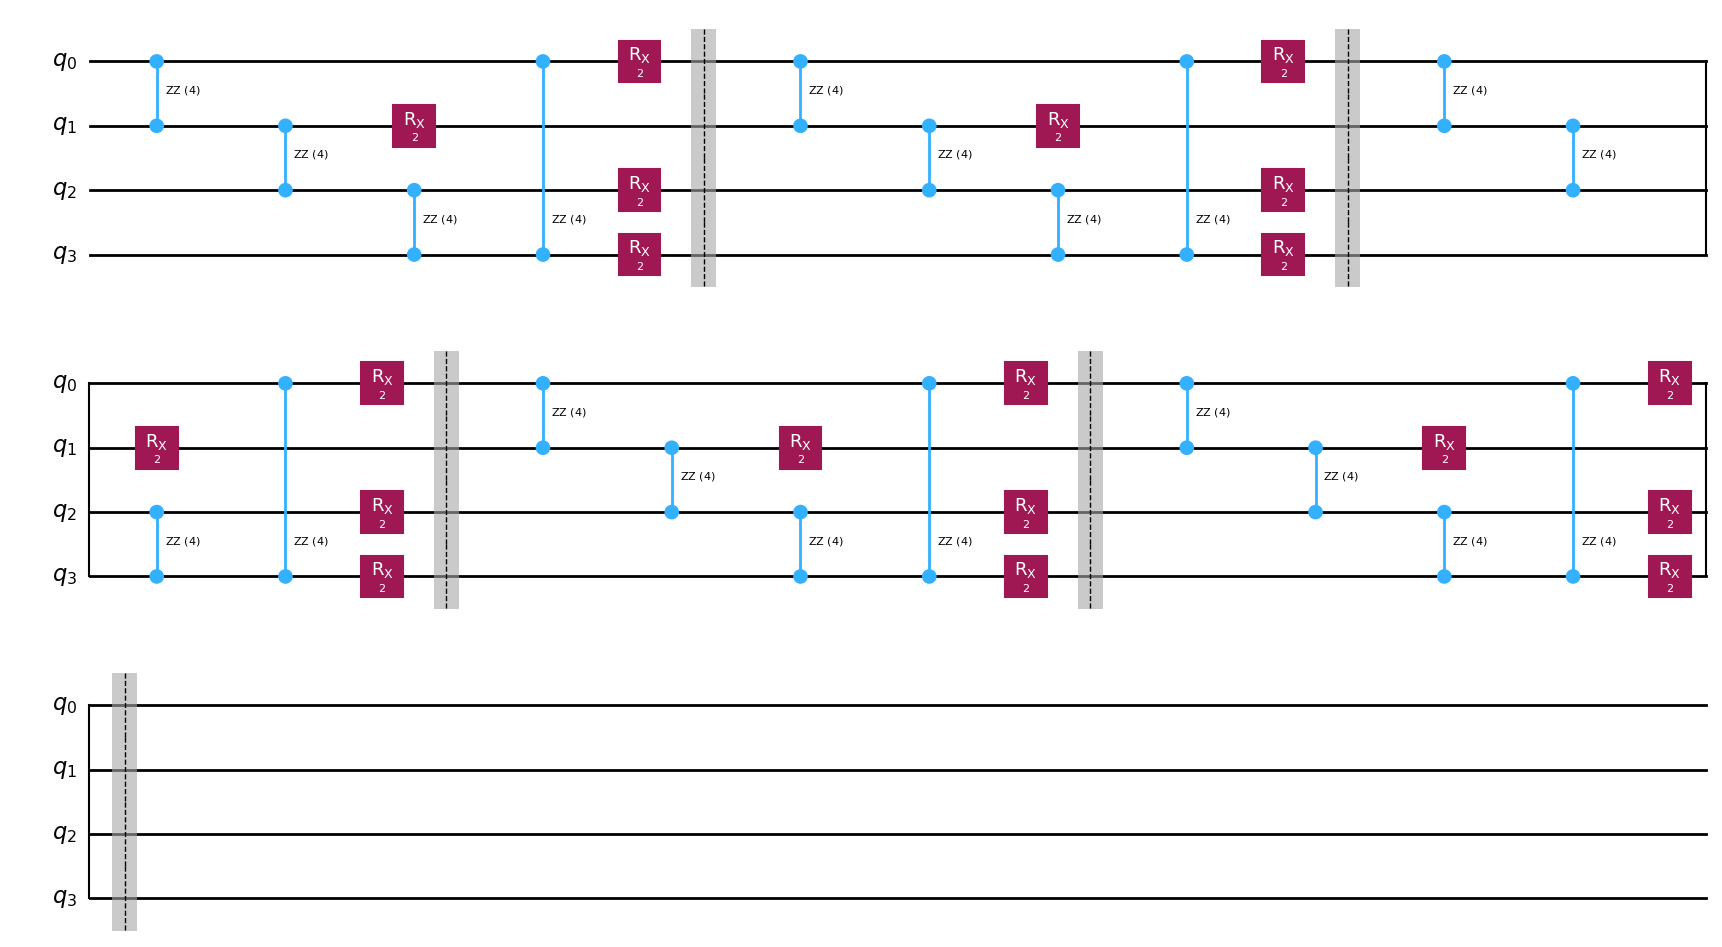

In [ ]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt

def trotter_step(qc, N, J, h, dt):
    # Apply RZZ gates for ZZ interactions with periodic boundaries
    for i in range(N):
        qc.rzz(2 * J * dt, i, (i + 1) % N)
    # Apply RX gates for X terms
    for i in range(N):
        qc.rx(2 * h * dt, i)

def build_circuit(N, J, h, total_time, trotter_steps):
    qc = QuantumCircuit(N)
    dt = total_time / trotter_steps

    # Apply r Trotter steps
    for _ in range(trotter_steps):
        trotter_step(qc, N, J, h, dt)
        qc.barrier()

    return qc

def simulate_ising(N, J, h, total_time, trotter_steps):
    # Build the circuit
    qc = build_circuit(N, J, h, total_time, trotter_steps)

    # Simulate using Statevector
    state = Statevector.from_instruction(qc)
    probabilities = np.abs(state.data) ** 2
    basis_states = [f"|{i:0{N}b}>" for i in range(2**N)]
    return qc, probabilities, basis_states


def plot_probabilities(probabilities, basis_states, N=None, J=None, h=None, total_time=None, trotter_steps=None):
    plt.figure(figsize=(14, 6))
    bars = plt.bar(basis_states, probabilities, color='skyblue')

    for bar in bars:
        height = bar.get_height()
        plt.annotate(f"{height:.3f}",
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points",
                     ha='center', va='bottom', fontsize=8)

    plt.xlabel('Computational Basis State')
    plt.ylabel('Probability')
    if None not in (N, J, h, total_time, trotter_steps):
        plt.title(f'Probabilities after Trotter Evolution (N={N}, J={J}, h={h}, time={total_time}, steps={trotter_steps})')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, min(1.2, max(probabilities)*1.2))
    plt.grid(axis='y', alpha=0.7)
    plt.tight_layout()
    plt.show()

def print_useful_info(circuit, trotter_steps):
    raw_depth = circuit.depth()
    raw_gate_count = len(circuit)
    barrier_count = circuit.count_ops().get('barrier', 0)

    adjusted_depth = raw_depth
    if barrier_count!=0:
      adjusted_depth = raw_depth - trotter_steps
    adjusted_gate_count = raw_gate_count - barrier_count

    depth_per_step = adjusted_depth / trotter_steps if trotter_steps else float('nan')
    gates_per_step = adjusted_gate_count / trotter_steps if trotter_steps else float('nan')

    ops = circuit.count_ops().copy()
    ops.pop('barrier', None)
    breakdown = ", ".join(f"{k.upper()}: {v}" for k, v in ops.items())

    print(f"""Trotterized Circuit
--------------------------------------------
Raw Depth:                        {raw_depth}
Depth (Excluding Barriers):       {adjusted_depth}  (Depth/step: {depth_per_step:.2f})
Raw Gate Count:                   {raw_gate_count}
Gate Count (Excluding Barriers):  {adjusted_gate_count}  (Gates/step: {gates_per_step:.2f})
Nonlocal Gate Count:              {circuit.num_nonlocal_gates()}
Gate Breakdown (no barriers):     {breakdown}

""")


# Example usage:
N = 4
J = 1.0
h = 0.5
total_time = 10
trotter_steps = 5

qc, probs, states = simulate_ising(N, J, h, total_time, trotter_steps)
print_useful_info(qc,trotter_steps)
header = f"Circuit for N={N} spins with {trotter_steps} Trotter steps:" if N and trotter_steps else "Circuit:"
print(f"\n{header}")
qc.draw('mpl')


Note that some of the printed metrics are misleading, since we are counting an RZZ as a single gate. In terms of actual hardware, this couldn't be farther from the truth, since one RZZ gate implies implementing 1 single-qubit rotation and 2 CNOTs which by themselves are equivalent to about 10 single-qubit native gates in terms of noise. To get actual depth we could use the decompose method before applying the depth method.

Additionally, we can reduce the depth of these types of circuits by exploiting parallel execution. The Hamiltonian's interactions can be written in a graph, where qubits are vertices and ZZ couplings are edges, as an edge-coloring problem. The chromatic index (minimum number of colors needed to color edges such that no two adjacent edges share the same color) determines the minimal circuit depth. Each color class corresponds to a parallelizable layer of non-overlapping RZZ gates, as edges of the same color have no shared vertices. For example, a 1D chain has chromatic index 2, enabling execution in two layers (even/odd edges), while a 2D square lattice requires 4 layers. This reduces depth from O(N) in sequential execution to O(1) for structured topologies, constrained only by the graph's chromatic index and hardware connectivity. For the cases of a ring we simply add one more coupling for the periodic connection at the edges.

Even though these tactics are trivially implemented, we don't do that in this notebook since it makes the circuits less clear (and having them in the "raw" form will be beneficial for comparing in a moment).

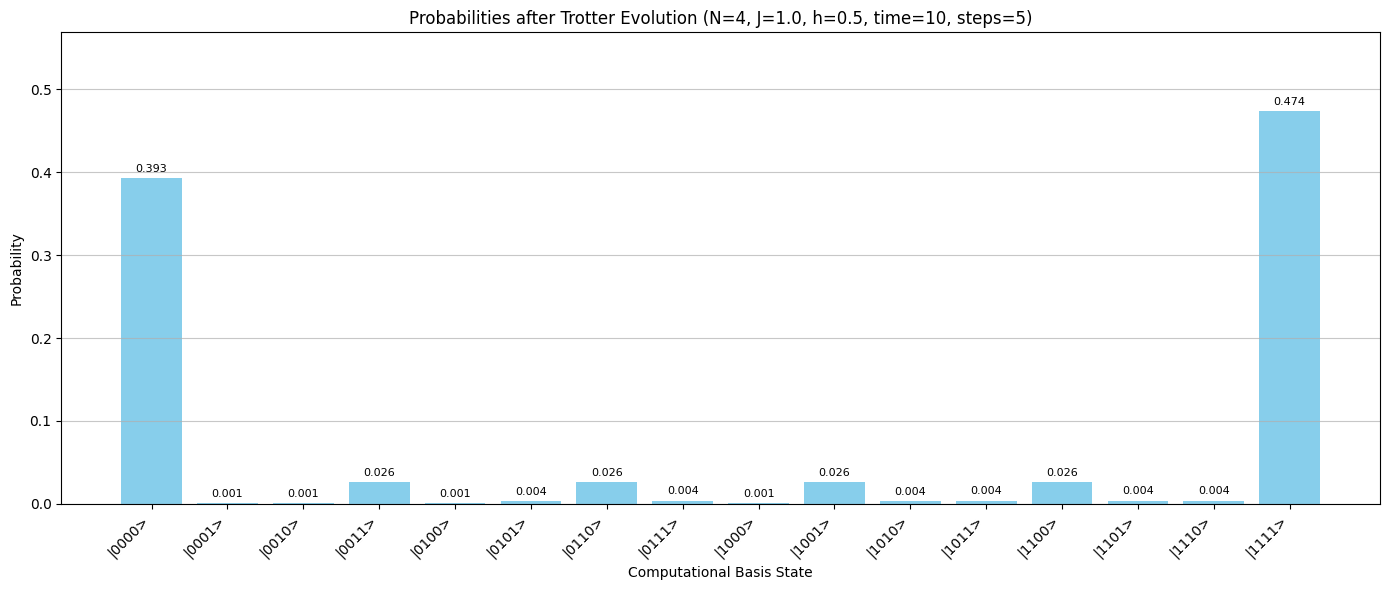

In [ ]:
plot_probabilities(probs, states, N, J, h, total_time, trotter_steps)

Here we are simulating the circuit evolution exactly through the Statevector.from_instruction() method. It's also possible to employ a shot based approach using AerSimulator which we do next:

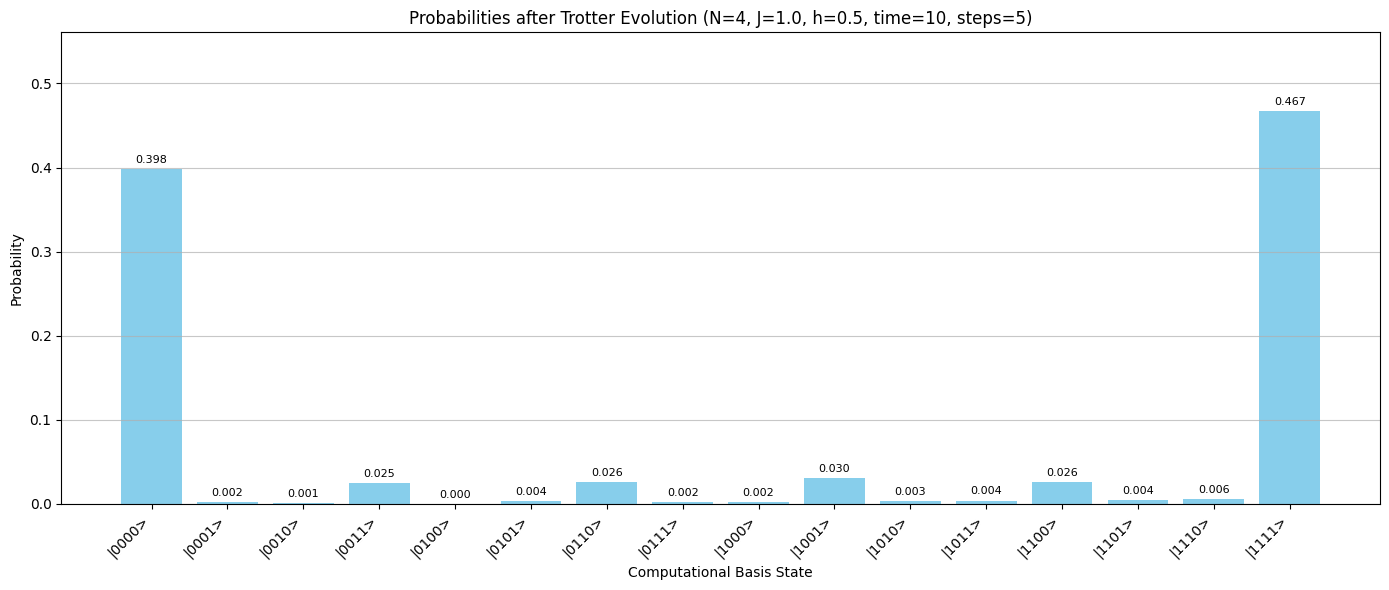

In [ ]:
from qiskit import QuantumCircuit, ClassicalRegister, transpile
from qiskit_aer import AerSimulator

def simulate_ising_shots(N, J, h, total_time, trotter_steps, shots=4096, backend=None):
    qc = build_circuit(N, J, h, total_time, trotter_steps)

    creg = ClassicalRegister(N, name='c')
    qc_shots = qc.copy()
    qc_shots.add_register(creg)
    qc_shots.measure(range(N), range(N))

    if backend is None:
        backend = AerSimulator()

    qc_transpiled = transpile(qc_shots, backend)

    job = backend.run(qc_transpiled, shots=shots)
    result = job.result()

    counts = result.get_counts(qc_transpiled)

    basis_states = [f"|{i:0{N}b}>" for i in range(2**N)]

    probabilities = [counts.get(state[1:-1], 0) / shots for state in basis_states]

    return qc_shots, probabilities, basis_states


qc_aer, probs_aer, states_aer = simulate_ising_shots(N, J, h, total_time, trotter_steps)

plot_probabilities(probs_aer, states_aer, N, J, h, total_time, trotter_steps)


Evidently the results are the same if the shot count is high enough.

These results don't tell us much since they are dependent on the total evolution time and other parameters. Still, for now one thing is for certain: the system is clearly evolving!

Before studying these results and delving into the physics of the Ising Model, let's double check our trotterization by comparing it to Qiskit's own "Trotterizers" (part of addon_utils).

Trotterized Circuit
--------------------------------------------
Raw Depth:                        25
Depth (Excluding Barriers):       25  (Depth/step: 5.00)
Raw Gate Count:                   40
Gate Count (Excluding Barriers):  40  (Gates/step: 8.00)
Nonlocal Gate Count:              20
Gate Breakdown (no barriers):     RZZ: 20, RX: 20



Circuit for N=4 spins with 5 Trotter steps:


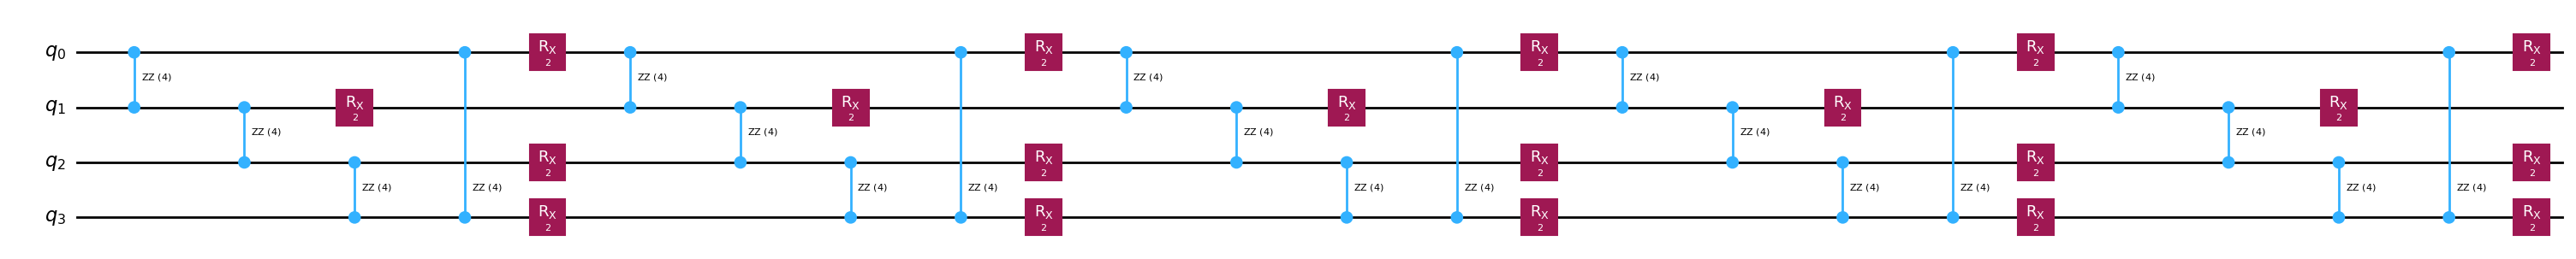

In [ ]:
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.synthesis import SuzukiTrotter
from qiskit_addon_utils.problem_generators import generate_time_evolution_circuit

def generate_trotterized_circuit(N, J, h, evolution_time, initial_state, trotter_steps, trotter_order):

    ZZ_pairs = [("ZZ", [i, (i + 1)%N], J) for i in range(0, N)]
    X_pairs = [("X", [i], h) for i in range(0, N)]

    # Alternatively we could use the generate_xyz_hamiltonian() function

    H = SparsePauliOp.from_sparse_list([*ZZ_pairs, *X_pairs], num_qubits=N).simplify()
    evo_circ = generate_time_evolution_circuit(H, synthesis=SuzukiTrotter(order=trotter_order, reps=trotter_steps), time=evolution_time)

    if initial_state is None:
      return evo_circ
    else:
      qc = QuantumCircuit(N)
      qc.initialize(initial_state, qc.qubits)

      qc.append(evo_circ.to_instruction(), qc.qubits)

      return qc

N = 4
J = 1.0
h = 0.5
total_time = 10.0
trotter_steps = 5

#initial_state = Statevector.from_label("0000")
initial_state=None
qc = generate_trotterized_circuit(N, J, h, total_time, initial_state, trotter_steps, 1)
print_useful_info(qc,trotter_steps)
header = f"Circuit for N={N} spins with {trotter_steps} Trotter steps:" if N and trotter_steps else "Circuit:"
print(f"\n{header}")
qc.draw(output="mpl", fold=-1)


This circuit is clearly the same as the one we manually constructed earlier. However this gives us easy access to higher orders of the Trotter Suzuki approximation. To see why this might matter let's take a fast detour first.

## A Quick Trip to the World of the Theory of Trotter Errors

We want to perform the time evolution of some Hamiltonian up to some error $\epsilon$:

$$
\|U-\exp(-itH)\|\leq\epsilon
$$

, where $\|\cdot\|$ denotes the spectral norm, which for some real matrix $A\in\mathbb{R}^{m\times n}$ is defined as

$$
\|A\|
\;=\;
\sup_{\mathbf{x}\neq \mathbf{0}}
\frac{\|A\mathbf{x}\|}{\|\mathbf{x}\|}
\;=\;
\max_{\|\mathbf{x}\|=1}\|A\mathbf{x}\|.
$$

That is, $\|A\|$ is the largest singular value of $A$.  If we write the singular value decomposition

$$
A = U \Sigma V^{T},
$$

with $\Sigma=\mathrm{diag}(\sigma_{1},\dots,\sigma_{\min\{m,n\}})$ and $\sigma_{1}\ge\sigma_{2}\ge\cdots\ge0$, then

$$
\|A\| = \sigma_{1}.
$$

Geometrically, the spectral norm measures the maximum stretching factor that $A$ applies to any unit-length vector in $\mathbb{R}^n$.  This is just some context useful for understanding why the spectral norm is a useful metric when trying to major (impose an upper bound) on errors caused by approximations.

As we have seen if we have an Hamiltonian of the form:

$$
H=\sum_{\gamma=1}^\Gamma H_\gamma
$$

We can employ the first-order Lie-Trotter formula to approximate

$$
\mathcal{U}_1(t)\equiv\prod_\gamma^\longleftarrow e^{-itH_\gamma}\equiv e^{-itH_\Gamma}...e^{-itH_1}\approx e^{-itH}
$$
and then divide the time $t$ into smaller times $\Delta t=t/r$ using $r$ Trotter steps.

However there are other higher-order product formulas. For example for second-order we have:

$$
\mathcal{U}_2(t)\equiv\prod_\gamma^\Gamma e^{-i\frac{t}{2}H_\gamma}\prod_\gamma^\longleftarrow e^{-i\frac{t}{2}H_\gamma}\equiv e^{-i\frac{t}{2}H_1}...e^{-itH_\Gamma}...e^{-i\frac{t}{2}H_1}\approx e^{-itH}
$$
We can take this even further by defining the ($2k$)th-order Trotter-Suzuki formula recursively:

$$
\mathcal{U}_{2k}(t)\equiv\mathcal{U}_{2k-2}(u_kt)^2\mathcal{U}_{2k-2}((1-4u_k)t)\mathcal{U}_{2k-2}(u_kt)^2,
$$

with $u_k\equiv 1/(4-4^{1/(2k-1)})$.

Generally for a product formula of order $p$, the Trotter Error scales with $\mathcal O(t^{p+1})$, however the point of using these approximations (besides their simplicity) is that since they come from truncatinng the Baker-Campbell-Hausdorff formula, their performance is dictated by how the operator summands commute. This is unique to product formulas! Additionally they preserve the locality of the system in question, which can also be exploited.

A reasonable bound for a p-th order product formula is presented in the second reference:

$$
\left\| \mathscr{S}_p(t) - e^{-itH} \right\| = \mathcal{O}\left( \widetilde{\alpha}_{\text{comm}} t^{p+1} \right),
$$

where

$$
\widetilde{\alpha}_{\text{comm}} \equiv \sum_{\gamma_1, \gamma_2, \ldots, \gamma_{p+1}} \left\| \left[ H_{\gamma_{p+1}}, \cdots \left[ H_{\gamma_2}, H_{\gamma_1} \right] \right]  \right\|.
$$

Or if we split the total evolution time into smaller trotter steps:

$$
\left\| \mathscr{S}_p(t,r) - e^{-itH} \right\|=\mathcal{O}\left( r\times\widetilde{\alpha}_{\text{comm}}\Delta t^{p+1} \right)
$$

For a first-order Trotterization this error bound is simply the first term in the Baker-Campbell-Hausdorff expansion

$$
\bigl\|e^{-i(A+B)\Delta t} - e^{-iA\Delta t}e^{-iB\Delta t}\bigr\| \le r\tfrac{\Delta t^2}{2}\,\|[A,B]\| + O(r\Delta t^3).
$$

Let's go back to our Transerse Field Ising Ring:

$$
H = H_Z + H_X,
\quad
H_Z = J \sum_{i=1}^N Z_i Z_{i+1},
\quad
H_X = h \sum_{i=1}^N X_i.
$$

We approximated the evolution $U(t)=e^{-iHt}$ using the first-order Lie-Trotter product formula with $r$ steps of size $\Delta t = t/r$:  

$$
\mathcal{U}_1(t; r) = \bigl(e^{-i H_X \Delta t} \, e^{-i H_Z \Delta t}\bigr)^r,
$$

and now demand the spectral-norm error  

$$
\|U(t) - \mathcal{U}_1(t; r)\| \le \epsilon.
$$


Taking $A=H_Z$ and $B=H_X$.  The commutator becomes,

$$
\begin{align*}
[H_Z, H_X] &= Jh\sum_{i,j=1}^N [Z_i Z_{i+1}, X_j] \\[6pt]
&= Jh\sum_{i=1}^N \Bigl([Z_i Z_{i+1}, X_i] + [Z_i Z_{i+1}, X_{i+1}]\Bigr) \\[6pt]
&= Jh\sum_{i=1}^N \Bigl(Z_{i+1}[Z_i,X_i] + Z_i[Z_{i+1},X_{i+1}]\Bigr) \\[6pt]
&= Jh\sum_{i=1}^N \Bigl(Z_{i+1}\,(2iY_i) + Z_i\,(2iY_{i+1})\Bigr) \\[6pt]
&= 2i\,Jh \sum_{i=1}^N \bigl(Z_{i+1}Y_i + Z_iY_{i+1}\bigr)\,,
\end{align*}
$$

so when taking the operator norm (and using the fact that Pauli matrices have eigenvalues $\lambda\pm1$) :

$$
\|[H_Z,H_X]\|
\;\le\; 2\,|J h|\,N\,.
$$

Thus after $r$ steps the total error obeys

$$
\|U(t) - \mathcal{U}_1(t; r)\|
\le \frac{t^2}{2r}\,\|[H_Z, H_X]\|
\le \frac{|J h| N\,t^2}{r}.
$$

If we were now to consider the second-order Trotter-Suzuki formula:

$$
\mathcal{U}_2(t; r)
= \Bigl(e^{-iH_Z\tfrac{\Delta t}{2}}\,e^{-iH_X\Delta t}\,e^{-iH_Z\tfrac{\Delta t}{2}}\Bigr)^r.
$$

Using the previous bound we get

$$
\bigl\|U(t) - \mathcal{U}_2(t; r)\bigr\|
\;\lesssim\;
\frac{t^3}{r^2}\,\bigl\|[[H_Z,H_X],H_Z] + [[H_X,H_Z],H_X]\bigr\|
= \mathcal O\bigl((|J^2h| + |J h^2|) N\,t^3 / r^2\bigr).
$$

So as long as we increase the number of Trotter Steps $r$ we can get arbitrarily close to the exact evolution and this process is faster for higher orders of the product formula. However, in reality there is a caveat: In NISQ devices, higher orders and number of Trotter Steps imply having circuits with much bigger depths. This in turn causes more noise which erases the progress of these methods. In practice it's a challenge to find the order and $r$ that yield the best performance for simulating a specific system.
### References  
- Suzuki, M. (1990). Fractal decomposition of exponential operators with applications to many-body theories and Monte Carlo simulations.
- Childs, A. M., Su, Y., et al. (2019). Theory of Trotter error.



Let's construct some higher order product formula circuits now.

Trotterized Circuit
--------------------------------------------
Raw Depth:                        27
Depth (Excluding Barriers):       24  (Depth/step: 8.00)
Raw Gate Count:                   39
Gate Count (Excluding Barriers):  36  (Gates/step: 12.00)
Nonlocal Gate Count:              24
Gate Breakdown (no barriers):     RZZ: 24, RX: 12



2nd Order Circuit for N=4 spins with 3 Trotter steps:


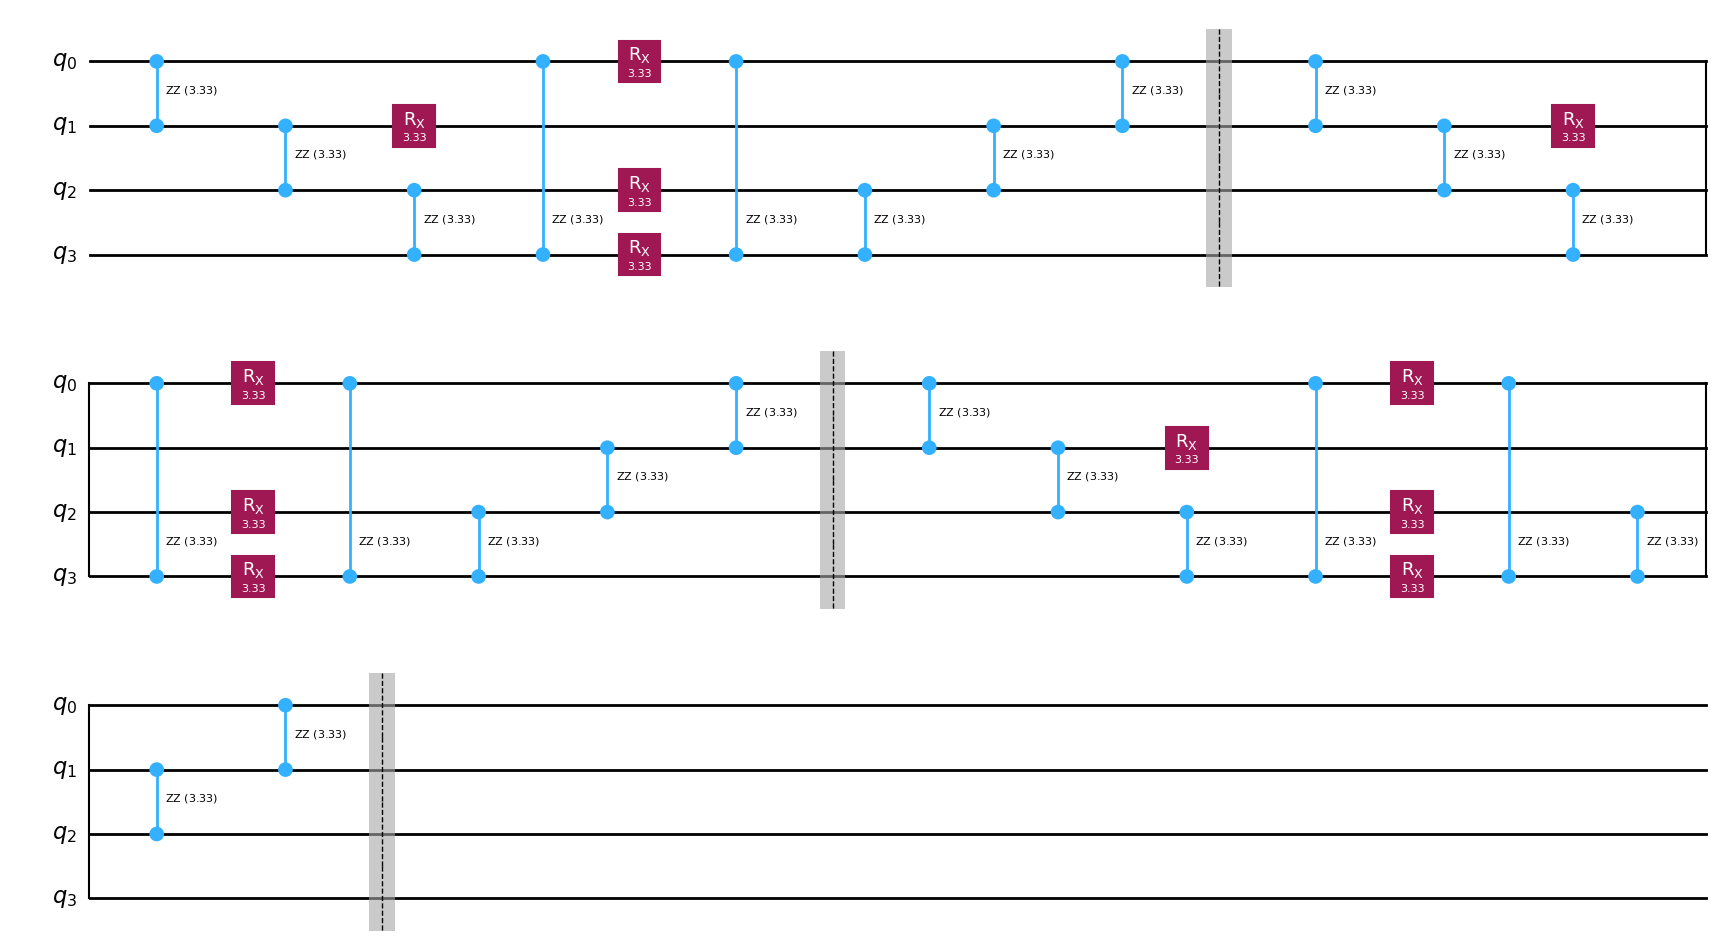

In [ ]:
def trotter_step_2nd_order(qc, N, J, h, dt):
    # Half-step RZZ for ZZ interactions (periodic boundaries)
    for i in range(N):
        qc.rzz(J * dt, i, (i + 1) % N)

    # Full-step RX for X terms
    for i in range(N):
        qc.rx(2 * h * dt, i)

    # Half-step RZZ for ZZ interactions in reverse order
    for i in reversed(range(N)):
        qc.rzz(J * dt, i, (i + 1) % N)

def build_2nd_order_circuit(N, J, h, total_time, trotter_steps):
    qc = QuantumCircuit(N)
    dt = total_time / trotter_steps

    # Apply r Trotter steps
    for _ in range(trotter_steps):
        trotter_step_2nd_order(qc, N, J, h, dt)
        qc.barrier()

    return qc

def simulate_ising_2nd_order(N, J, h, total_time, trotter_steps):
    # Build the circuit
    qc = build_2nd_order_circuit(N, J, h, total_time, trotter_steps)

    # Simulate using Statevector
    state = Statevector.from_instruction(qc)
    probabilities = np.abs(state.data) ** 2
    basis_states = [f"|{i:0{N}b}>" for i in range(2**N)]
    return qc, probabilities, basis_states


# Example usage:
N = 4
J = 1.0
h = 0.5
total_time = 10
trotter_steps = 3

qc, probs, states = simulate_ising_2nd_order(N, J, h, total_time, trotter_steps)
print_useful_info(qc,trotter_steps)
header = f"2nd Order Circuit for N={N} spins with {trotter_steps} Trotter steps:" if N and trotter_steps else "Circuit:"
print(f"\n{header}")
qc.draw('mpl')

Now comparing to Qiskit's built in functions:

Trotterized Circuit
--------------------------------------------
Raw Depth:                        30
Depth (Excluding Barriers):       30  (Depth/step: 10.00)
Raw Gate Count:                   45
Gate Count (Excluding Barriers):  45  (Gates/step: 15.00)
Nonlocal Gate Count:              24
Gate Breakdown (no barriers):     RZZ: 24, RX: 21



2nd Order Circuit for N=4 spins with 3 Trotter steps:


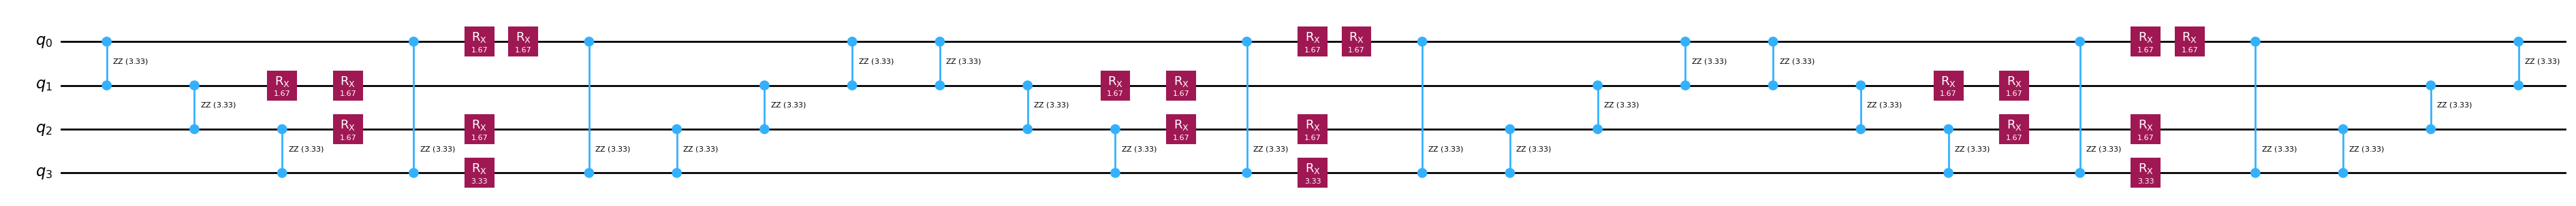

In [ ]:
N = 4
J = 1.0
h = 0.5
total_time = 10
trotter_steps = 3

#initial_state = Statevector.from_label("0000")
initial_state=None
qc = generate_trotterized_circuit(N, J, h, total_time, initial_state, trotter_steps, 2)
print_useful_info(qc,trotter_steps)
header = f"2nd Order Circuit for N={N} spins with {trotter_steps} Trotter steps:" if N and trotter_steps else "Circuit:"
print(f"\n{header}")
qc.draw(output="mpl", fold=-1)

Again we see that the circuits match exactly.

Let's draw the 4th order circuit using the generate_time_evolution_circuit function just to see what it looks like and do some comparing later:

Trotterized Circuit
--------------------------------------------
Raw Depth:                        50
Depth (Excluding Barriers):       50  (Depth/step: 50.00)
Raw Gate Count:                   75
Gate Count (Excluding Barriers):  75  (Gates/step: 75.00)
Nonlocal Gate Count:              40
Gate Breakdown (no barriers):     RZZ: 40, RX: 35



4th Order Circuit for N=4 spins with 1 Trotter steps:


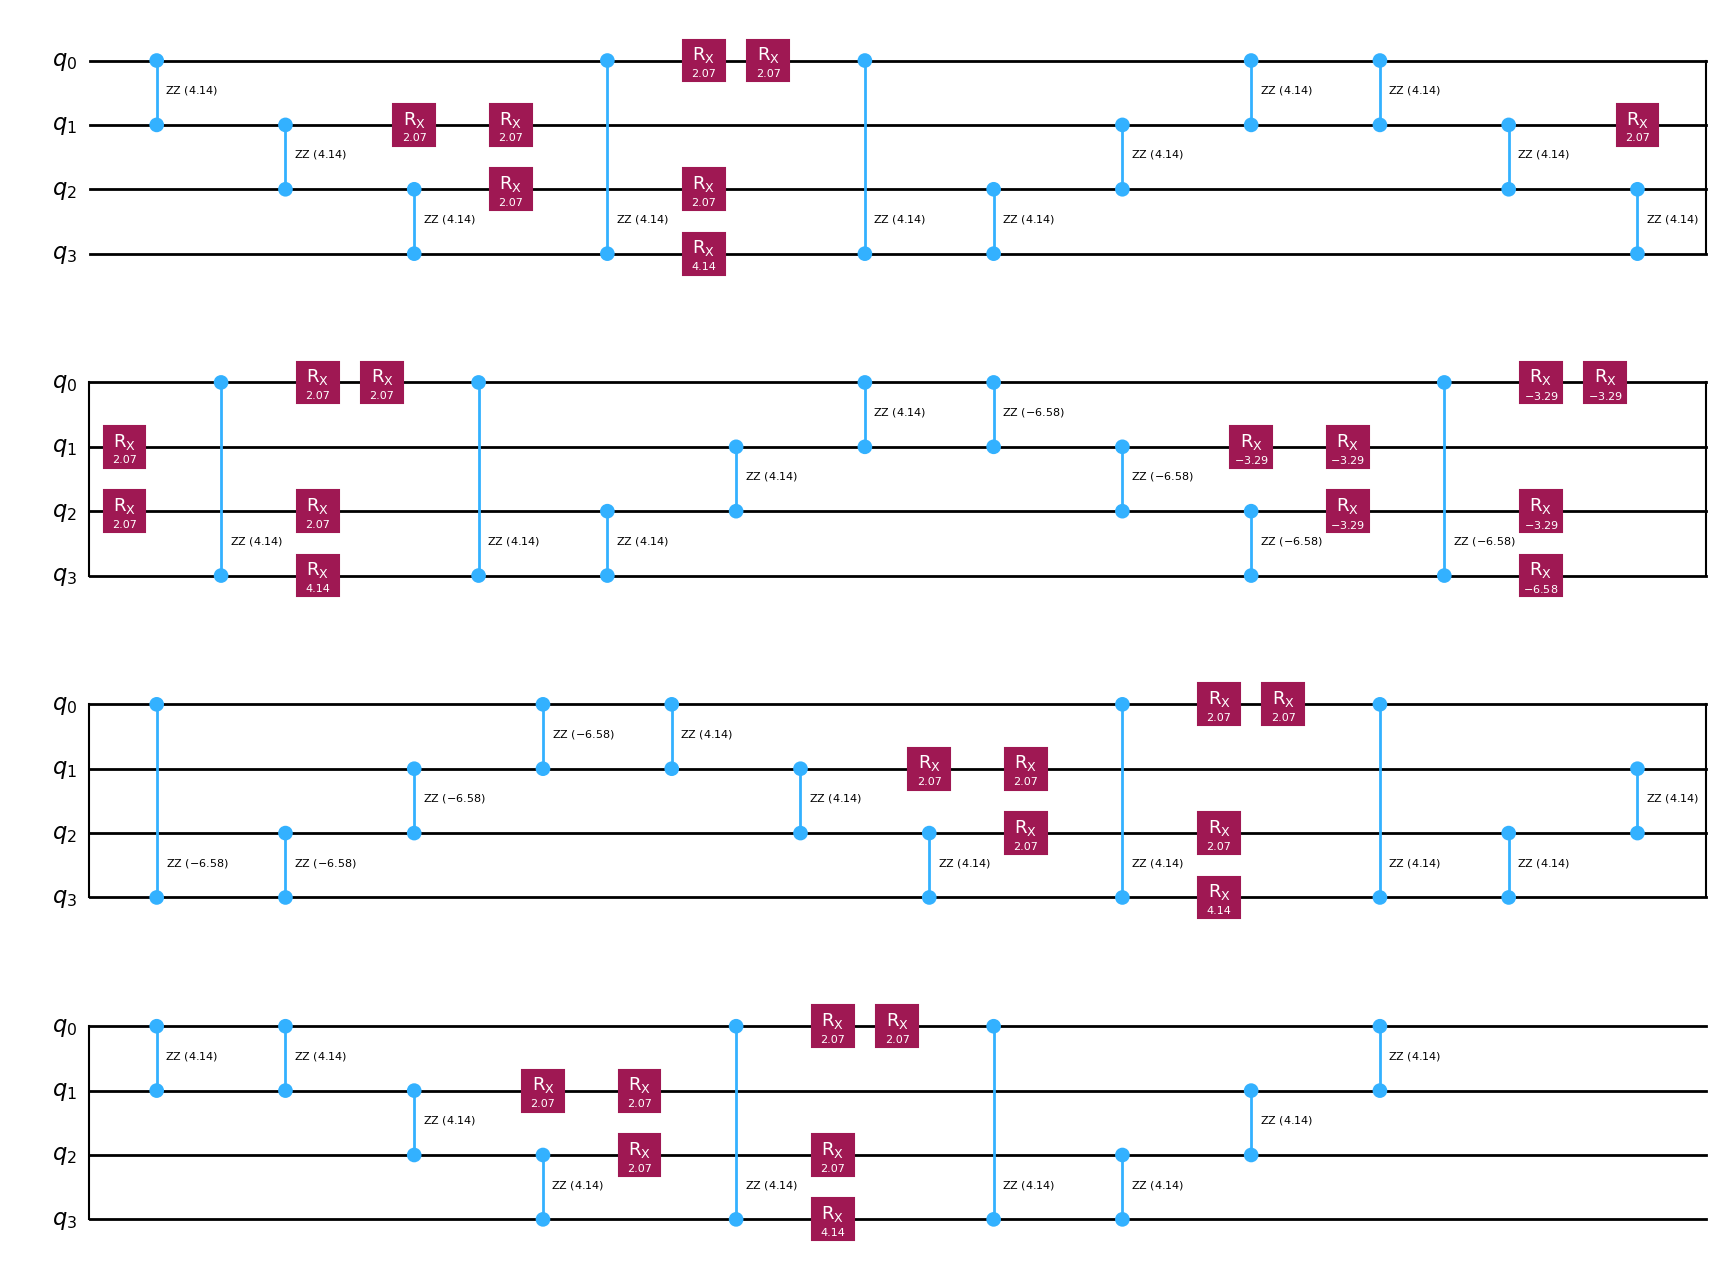

In [ ]:
N = 4
J = 1.0
h = 0.5
total_time = 10
trotter_steps = 1

#initial_state = Statevector.from_label("0000")
initial_state=None
qc = generate_trotterized_circuit(N, J, h, total_time, initial_state, trotter_steps, 4)
print_useful_info(qc,trotter_steps)
header = f"4th Order Circuit for N={N} spins with {trotter_steps} Trotter steps:" if N and trotter_steps else "Circuit:"
print(f"\n{header}")
qc.draw(output="mpl")

Note the recursive nature of the circuits and especially how long 1 single step of the 4th order circuit is! However let's not forget that in theory having circuits this big can actually lead to better error scalings:

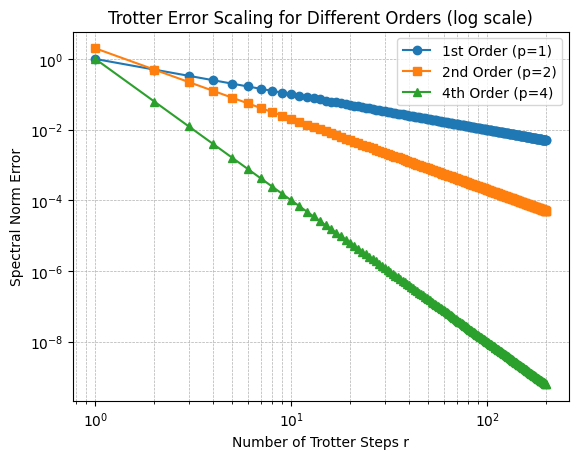

In [ ]:
J = 1.0
h = 1.0
N = 1.0
t = 1.0

r_values = np.linspace(1, 200, 200)

error_1st = (np.abs(J * h) * N * t**2) / r_values
error_2nd = ((np.abs(J**2 * h) + np.abs(J * h**2)) * N * t**3) / r_values**2
error_4th = (N * t**5) / r_values**4  # just considering assymptotic behaviour for simplicity sake

plt.figure()
plt.loglog(r_values, error_1st, label='1st Order (p=1)', marker='o')
plt.loglog(r_values, error_2nd, label='2nd Order (p=2)', marker='s')
plt.loglog(r_values, error_4th, label='4th Order (p=4)', marker='^')
plt.xlabel('Number of Trotter Steps r')
plt.ylabel('Spectral Norm Error')
plt.title('Trotter Error Scaling for Different Orders (log scale)')
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()


We've looked at theory enough now, let's go back to simulating our transverse field Ising ring. To compare between different Trotter Orders we need to also construct an exact time evolution as a baseline using good old matrix multiplication.

The following plots show the results for $J={\pm0.5,\pm1.0,\pm2.0}$ and $h={0.5,1.0,2.0}$ for orders 1 and 4 (and the exact time evolution of course). When reading the graphs don't forget that qiskit uses "Right indexing", that is, the statevector labels are interpreted from right to left.

There are plots for $|\psi_0\rangle=|000\rangle (N=3), |\psi_0\rangle =|011\rangle (N=3)$, $|\psi_0\rangle=H^{\otimes3}|000\rangle=\frac{1}{\sqrt{2^3}}\sum_{x\in\{0,1\}^3}|x\rangle$, $|\psi_0\rangle=|0000\rangle (N=4)$ and $|\psi_0\rangle=H^{\otimes4}|0000\rangle=\frac{1}{\sqrt{2^4}}\sum_{x\in\{0,1\}^4}|x\rangle$ in that same order.

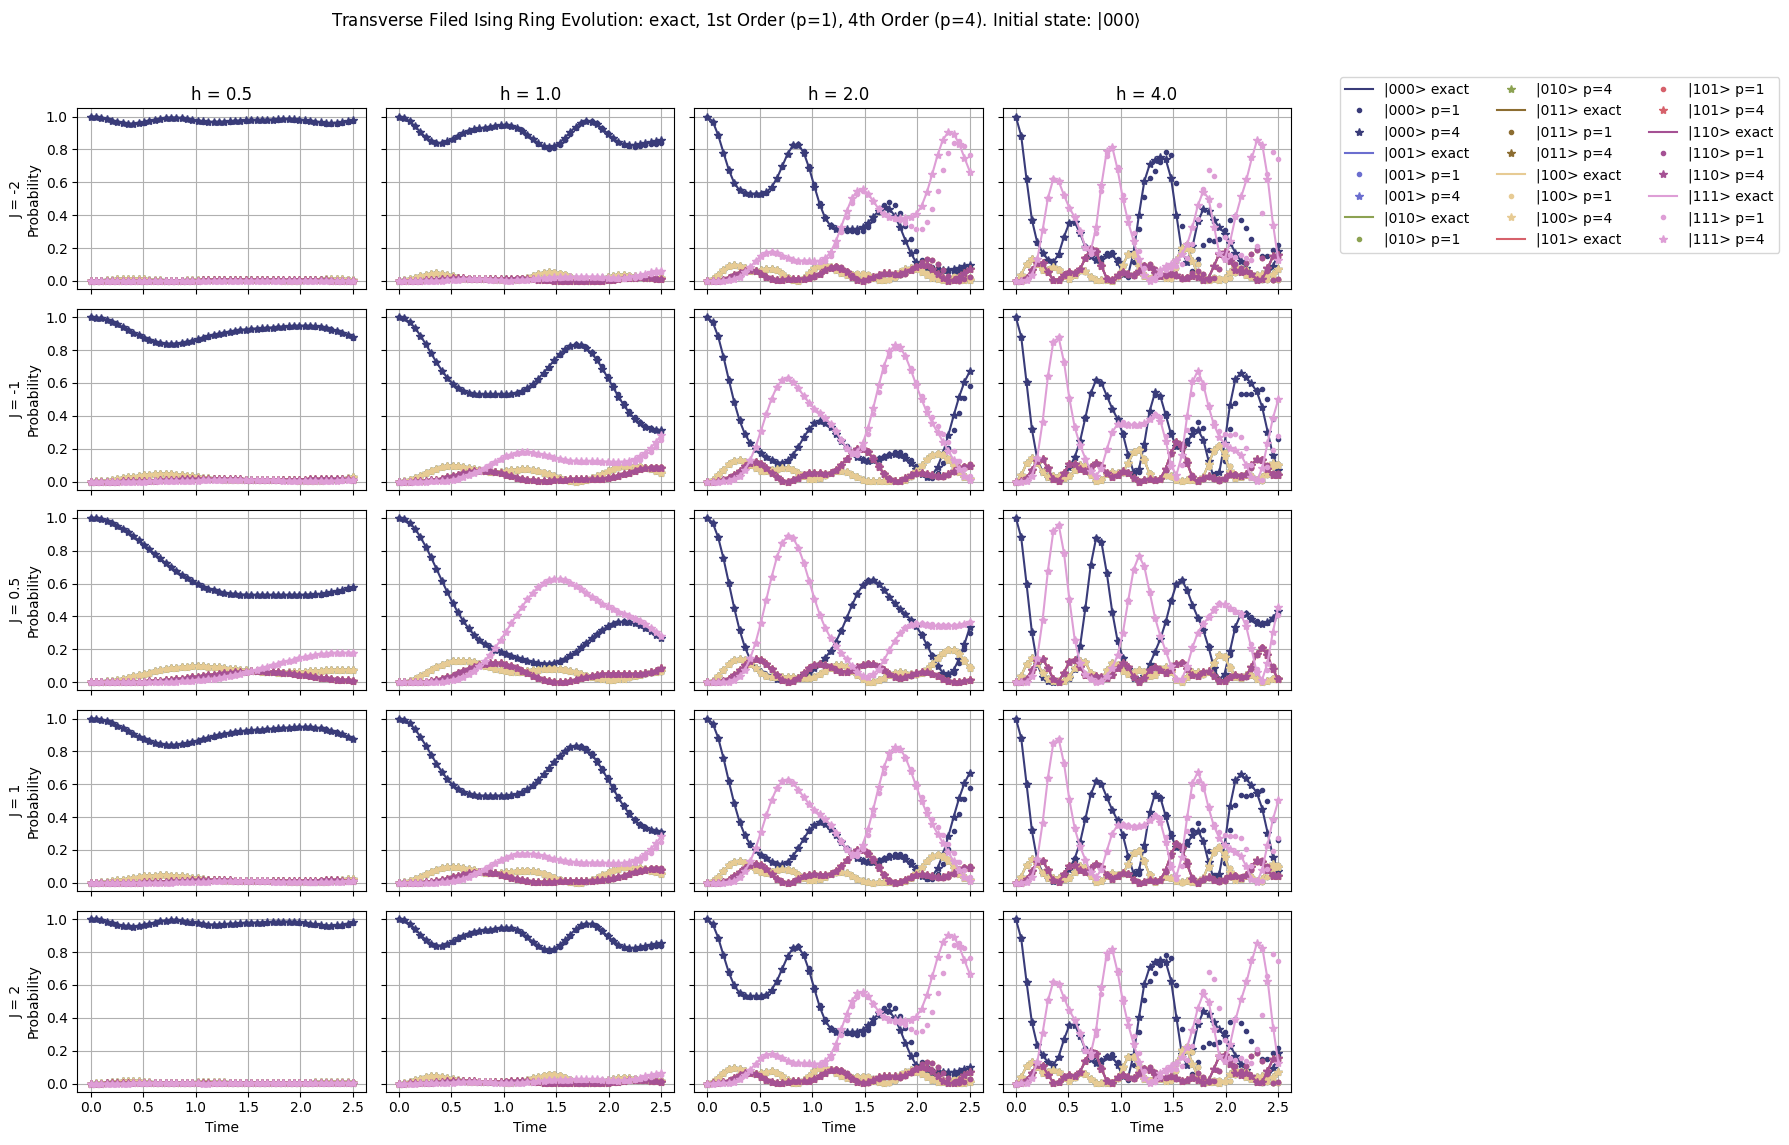

In [ ]:
from scipy.linalg import expm

def simulate_over_time(N, J, h, initial_state, trotter_steps, trotter_order, times):
    probs = np.zeros((len(times), 2**N))
    for idx, t in enumerate(times):
        qc = generate_trotterized_circuit(
            N, J, h, t, initial_state, trotter_steps, trotter_order
        )
        sv = Statevector.from_instruction(qc)
        probs[idx] = np.abs(sv.data)**2
    return probs

def simulate_exact(N, J, h, initial_state, times):
    X = np.array([[0,1],[1,0]],dtype=complex)
    Z = np.array([[1,0],[0,-1]],dtype=complex)
    I = np.eye(2,dtype=complex)
    def kron_n(mats):
        out = mats[0]
        for m in mats[1:]:
            out = np.kron(out,m)
        return out

    HZ = np.zeros((2**N,2**N),dtype=complex)
    HX = np.zeros_like(HZ)
    for i in range(N):
        ops = [I]*N
        ops[i] = Z
        ops[(i+1)%N] = Z
        HZ += J * kron_n(ops)
        ops = [I]*N
        ops[i] = X
        HX += h * kron_n(ops)
    H = HZ + HX

    psi0 = np.array(initial_state, dtype=complex)
    probs = np.zeros((len(times), 2**N))
    for idx, t in enumerate(times):
        U = expm(-1j * H * t)
        psi = U @ psi0
        probs[idx] = np.abs(psi)**2
    return probs

# Parameters
N = 3
J_values = [-2, -1, 0.5, 1, 2]
h_values = [0.5, 1.0, 2.0, 4.0]
orders   = [1, 4]
r_steps  = 15
t_final  = 2.5
times    = np.linspace(0, t_final, 50)
initial_state = Statevector.from_label("000")

num_states = 2**N
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, num_states)]

fig, axes = plt.subplots(len(J_values), len(h_values),
                         figsize=(15, 12),
                         sharex=True, sharey=True)

for i, J in enumerate(J_values):
    for j, h in enumerate(h_values):
        ax = axes[i, j]
        probs_exact = simulate_exact(N, J, h, initial_state, times)
        probs_p1    = simulate_over_time(N, J, h, initial_state, r_steps, 1, times)
        probs_p4    = simulate_over_time(N, J, h, initial_state, r_steps, 4, times)
        for s in range(num_states):
            c = colors[s]
            label = f"|{s:0{N}b}>"
            ax.plot(times, probs_exact[:,s],  '-', color=c, label=f"{label} exact")
            ax.plot(times, probs_p1[:,s],     '.', color=c, label=f"{label} p=1")
            ax.plot(times, probs_p4[:,s],    '*', color=c, label=f"{label} p=4")
        if i == 0:
            ax.set_title(f"h = {h}")
        if j == 0:
            ax.set_ylabel(f"J = {J}\nProbability")
        if i == len(J_values)-1:
            ax.set_xlabel("Time")
        ax.grid(True)

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=3, bbox_to_anchor=(1.2, 0.9))

plt.suptitle("Transverse Filed Ising Ring Evolution: exact, 1st Order (p=1), 4th Order (p=4). Initial state: $|000\\rangle$", y=0.95)
plt.tight_layout(rect=[0,0,0.88,0.93])
plt.show()


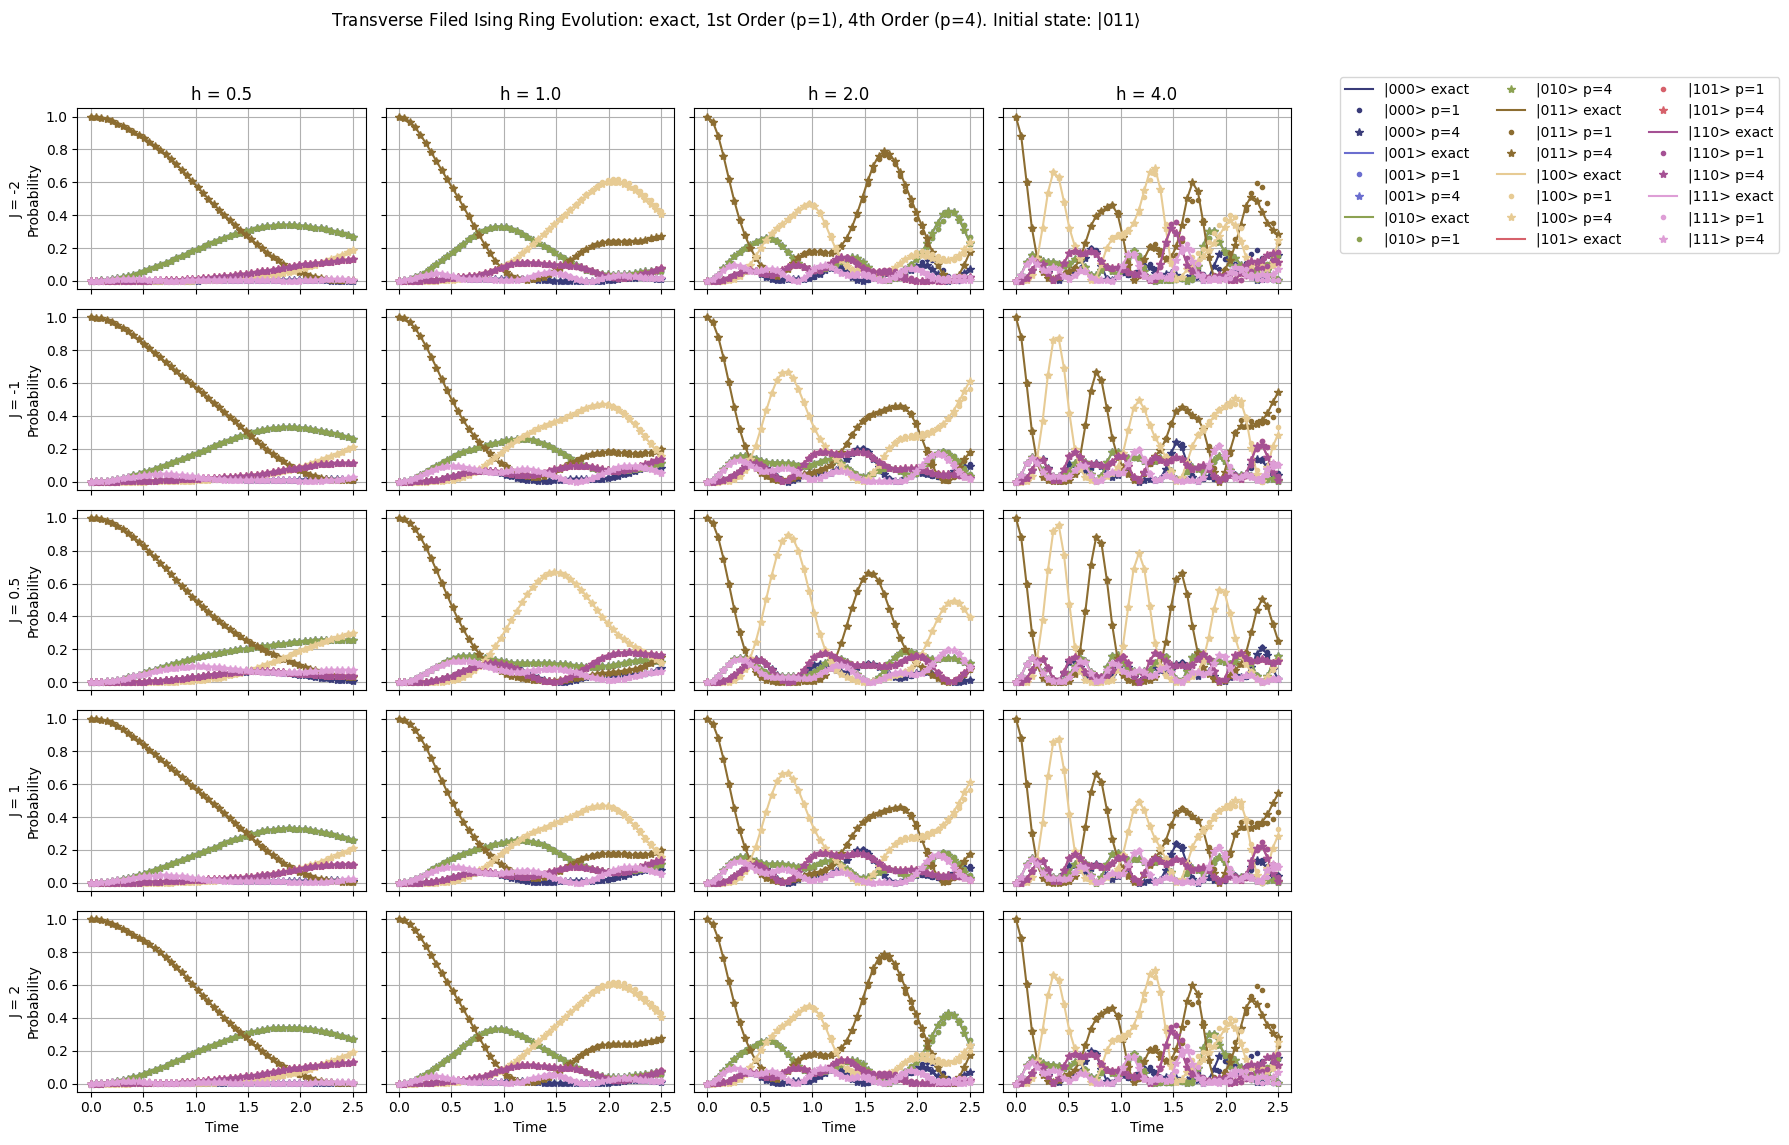

In [ ]:
# Parameters
N = 3
J_values = [-2, -1, 0.5, 1, 2]
h_values = [0.5, 1.0, 2.0, 4.0]
orders   = [1, 4]
r_steps  = 15
t_final  = 2.5
times    = np.linspace(0, t_final, 50)
initial_state = Statevector.from_label("011")

num_states = 2**N
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, num_states)]

fig, axes = plt.subplots(len(J_values), len(h_values),
                         figsize=(15, 12),
                         sharex=True, sharey=True)

for i, J in enumerate(J_values):
    for j, h in enumerate(h_values):
        ax = axes[i, j]
        probs_exact = simulate_exact(N, J, h, initial_state, times)
        probs_p1    = simulate_over_time(N, J, h, initial_state, r_steps, 1, times)
        probs_p4    = simulate_over_time(N, J, h, initial_state, r_steps, 4, times)
        for s in range(num_states):
            c = colors[s]
            label = f"|{s:0{N}b}>"
            ax.plot(times, probs_exact[:,s],  '-', color=c, label=f"{label} exact")
            ax.plot(times, probs_p1[:,s],     '.', color=c, label=f"{label} p=1")
            ax.plot(times, probs_p4[:,s],    '*', color=c, label=f"{label} p=4")
        if i == 0:
            ax.set_title(f"h = {h}")
        if j == 0:
            ax.set_ylabel(f"J = {J}\nProbability")
        if i == len(J_values)-1:
            ax.set_xlabel("Time")
        ax.grid(True)

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=3, bbox_to_anchor=(1.2, 0.9))

plt.suptitle("Transverse Filed Ising Ring Evolution: exact, 1st Order (p=1), 4th Order (p=4). Initial state: $|011\\rangle$", y=0.95)
plt.tight_layout(rect=[0,0,0.88,0.93])
plt.show()


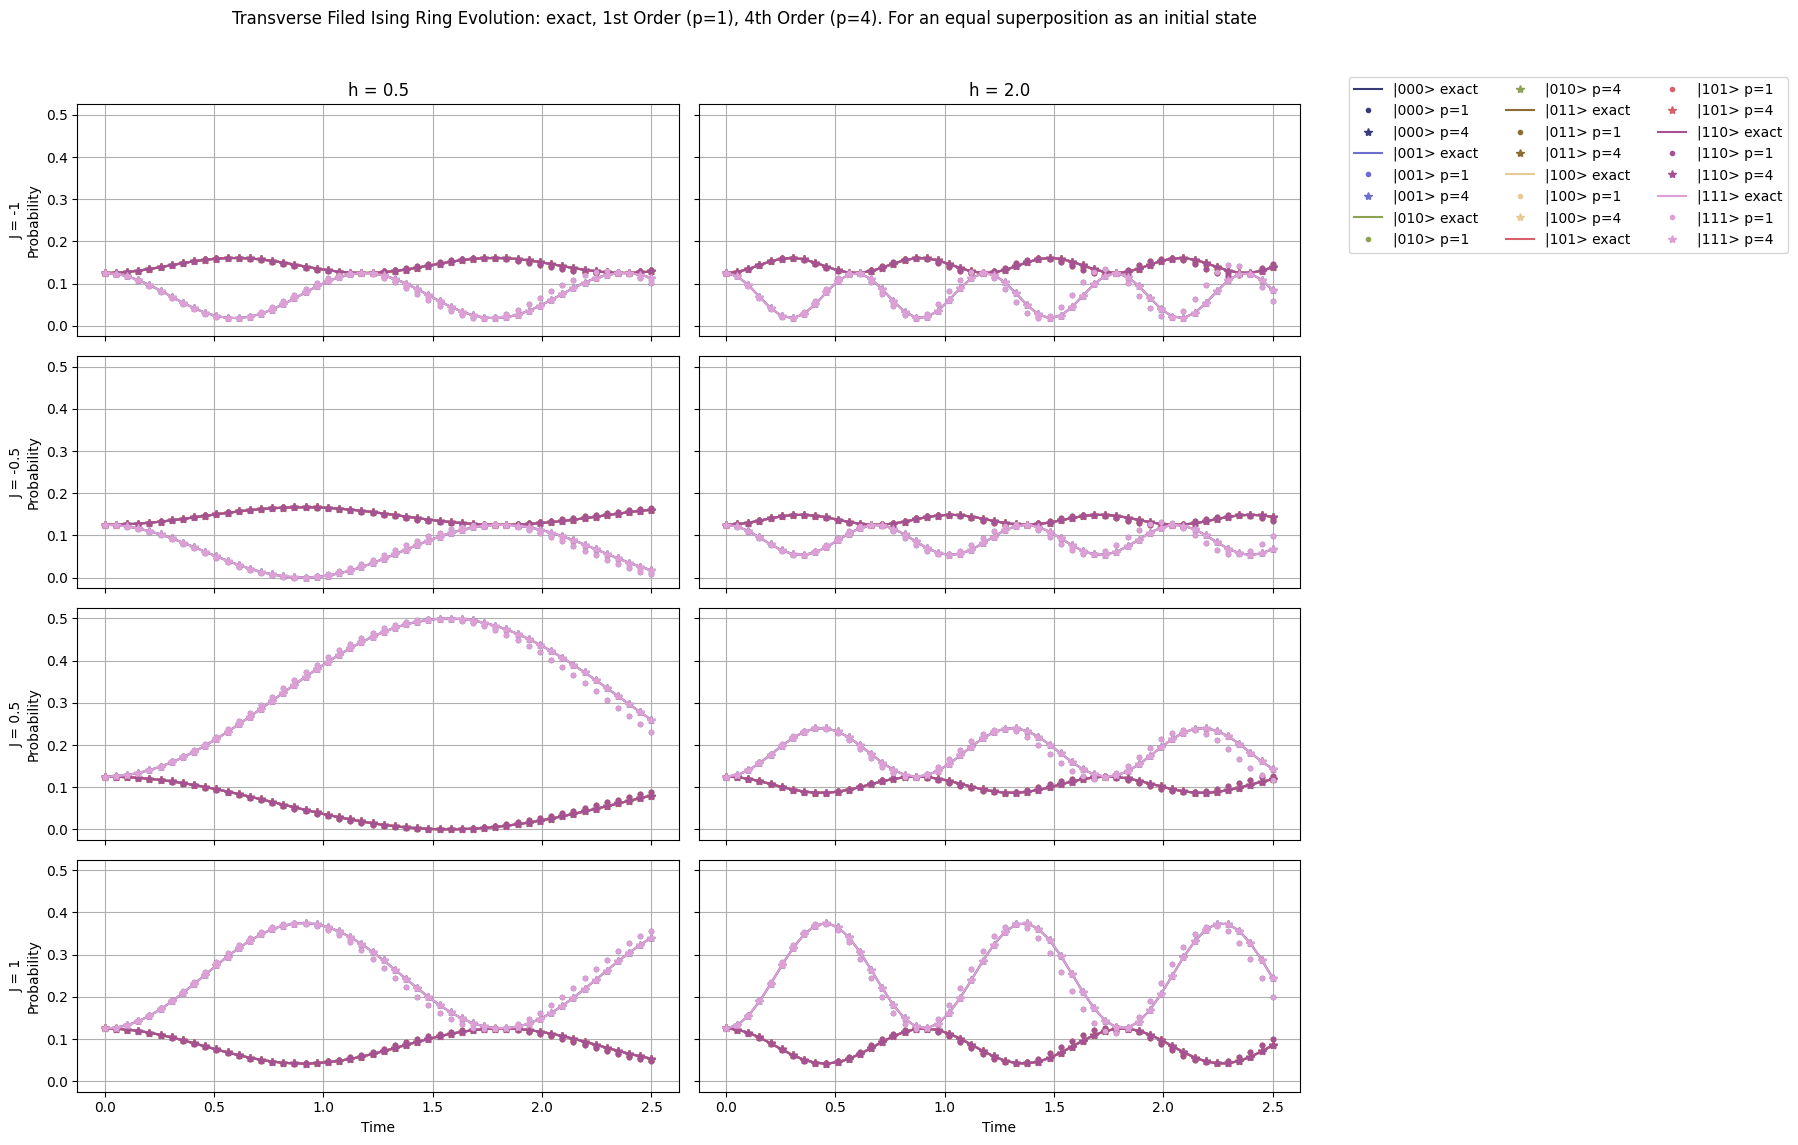

In [ ]:
# Parameters
N = 3
J_values = [-1, -0.5,0.5, 1]
h_values = [0.5, 2.0]
orders   = [1, 4]
r_steps  = 15
t_final  = 2.5
times    = np.linspace(0, t_final, 50)

# Equal superpostion
qc_h = QuantumCircuit(N)
qc_h.h(range(N))
initial_state = Statevector.from_instruction(qc_h).data
num_states = 2**N
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, num_states)]

fig, axes = plt.subplots(len(J_values), len(h_values),
                         figsize=(15, 12),
                         sharex=True, sharey=True)

for i, J in enumerate(J_values):
    for j, h in enumerate(h_values):
        ax = axes[i, j]
        probs_exact = simulate_exact(N, J, h, initial_state, times)
        probs_p1    = simulate_over_time(N, J, h, initial_state, r_steps, 1, times)
        probs_p4    = simulate_over_time(N, J, h, initial_state, r_steps, 4, times)
        for s in range(num_states):
            c = colors[s]
            label = f"|{s:0{N}b}>"
            ax.plot(times, probs_exact[:,s],  '-', color=c, label=f"{label} exact")
            ax.plot(times, probs_p1[:,s],     '.', color=c, label=f"{label} p=1")
            ax.plot(times, probs_p4[:,s],    '*', color=c, label=f"{label} p=4")
        if i == 0:
            ax.set_title(f"h = {h}")
        if j == 0:
            ax.set_ylabel(f"J = {J}\nProbability")
        if i == len(J_values)-1:
            ax.set_xlabel("Time")
        ax.grid(True)

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=3, bbox_to_anchor=(1.2, 0.9))

plt.suptitle("Transverse Filed Ising Ring Evolution: exact, 1st Order (p=1), 4th Order (p=4). For an equal superposition as an initial state", y=0.95)
plt.tight_layout(rect=[0,0,0.88,0.93])
plt.show()
#note that some states are hidden perfectly behind others

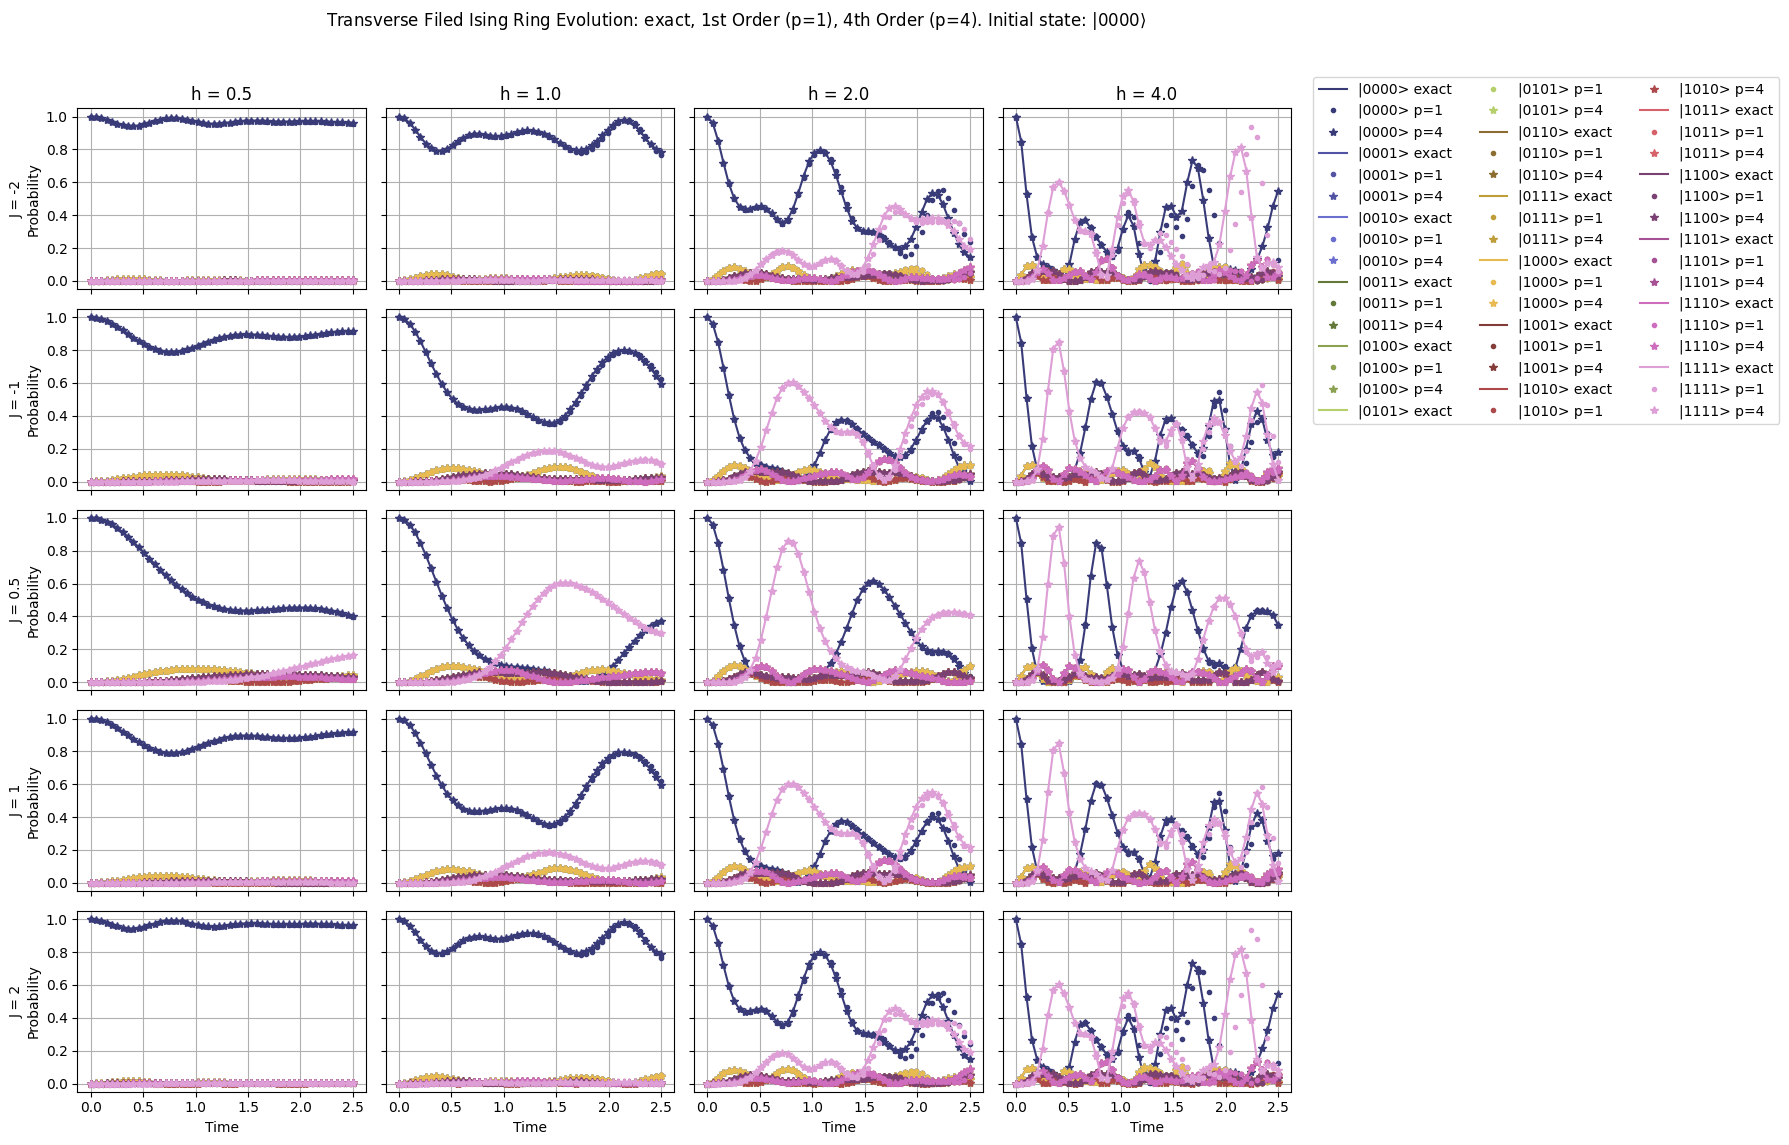

In [ ]:
# Parameters
N = 4
J_values = [-2, -1, 0.5, 1, 2]
h_values = [0.5, 1.0, 2.0,4.0]
orders   = [1, 4]
r_steps  = 15
t_final  = 2.5
times    = np.linspace(0, t_final, 50)
initial_state = Statevector.from_label("0000")

num_states = 2**N
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, num_states)]

fig, axes = plt.subplots(len(J_values), len(h_values),
                         figsize=(15, 12),
                         sharex=True, sharey=True)

for i, J in enumerate(J_values):
    for j, h in enumerate(h_values):
        ax = axes[i, j]
        probs_exact = simulate_exact(N, J, h, initial_state, times)
        probs_p1    = simulate_over_time(N, J, h, initial_state, r_steps, 1, times)
        probs_p4    = simulate_over_time(N, J, h, initial_state, r_steps, 4, times)
        for s in range(num_states):
            c = colors[s]
            label = f"|{s:0{N}b}>"
            ax.plot(times, probs_exact[:,s],  '-', color=c, label=f"{label} exact")
            ax.plot(times, probs_p1[:,s],     '.', color=c, label=f"{label} p=1")
            ax.plot(times, probs_p4[:,s],    '*', color=c, label=f"{label} p=4")
        if i == 0:
            ax.set_title(f"h = {h}")
        if j == 0:
            ax.set_ylabel(f"J = {J}\nProbability")
        if i == len(J_values)-1:
            ax.set_xlabel("Time")
        ax.grid(True)

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=3, bbox_to_anchor=(1.2, 0.9))

plt.suptitle("Transverse Filed Ising Ring Evolution: exact, 1st Order (p=1), 4th Order (p=4). Initial state: $|0000\\rangle$", y=0.95)
plt.tight_layout(rect=[0,0,0.88,0.93])
plt.show()


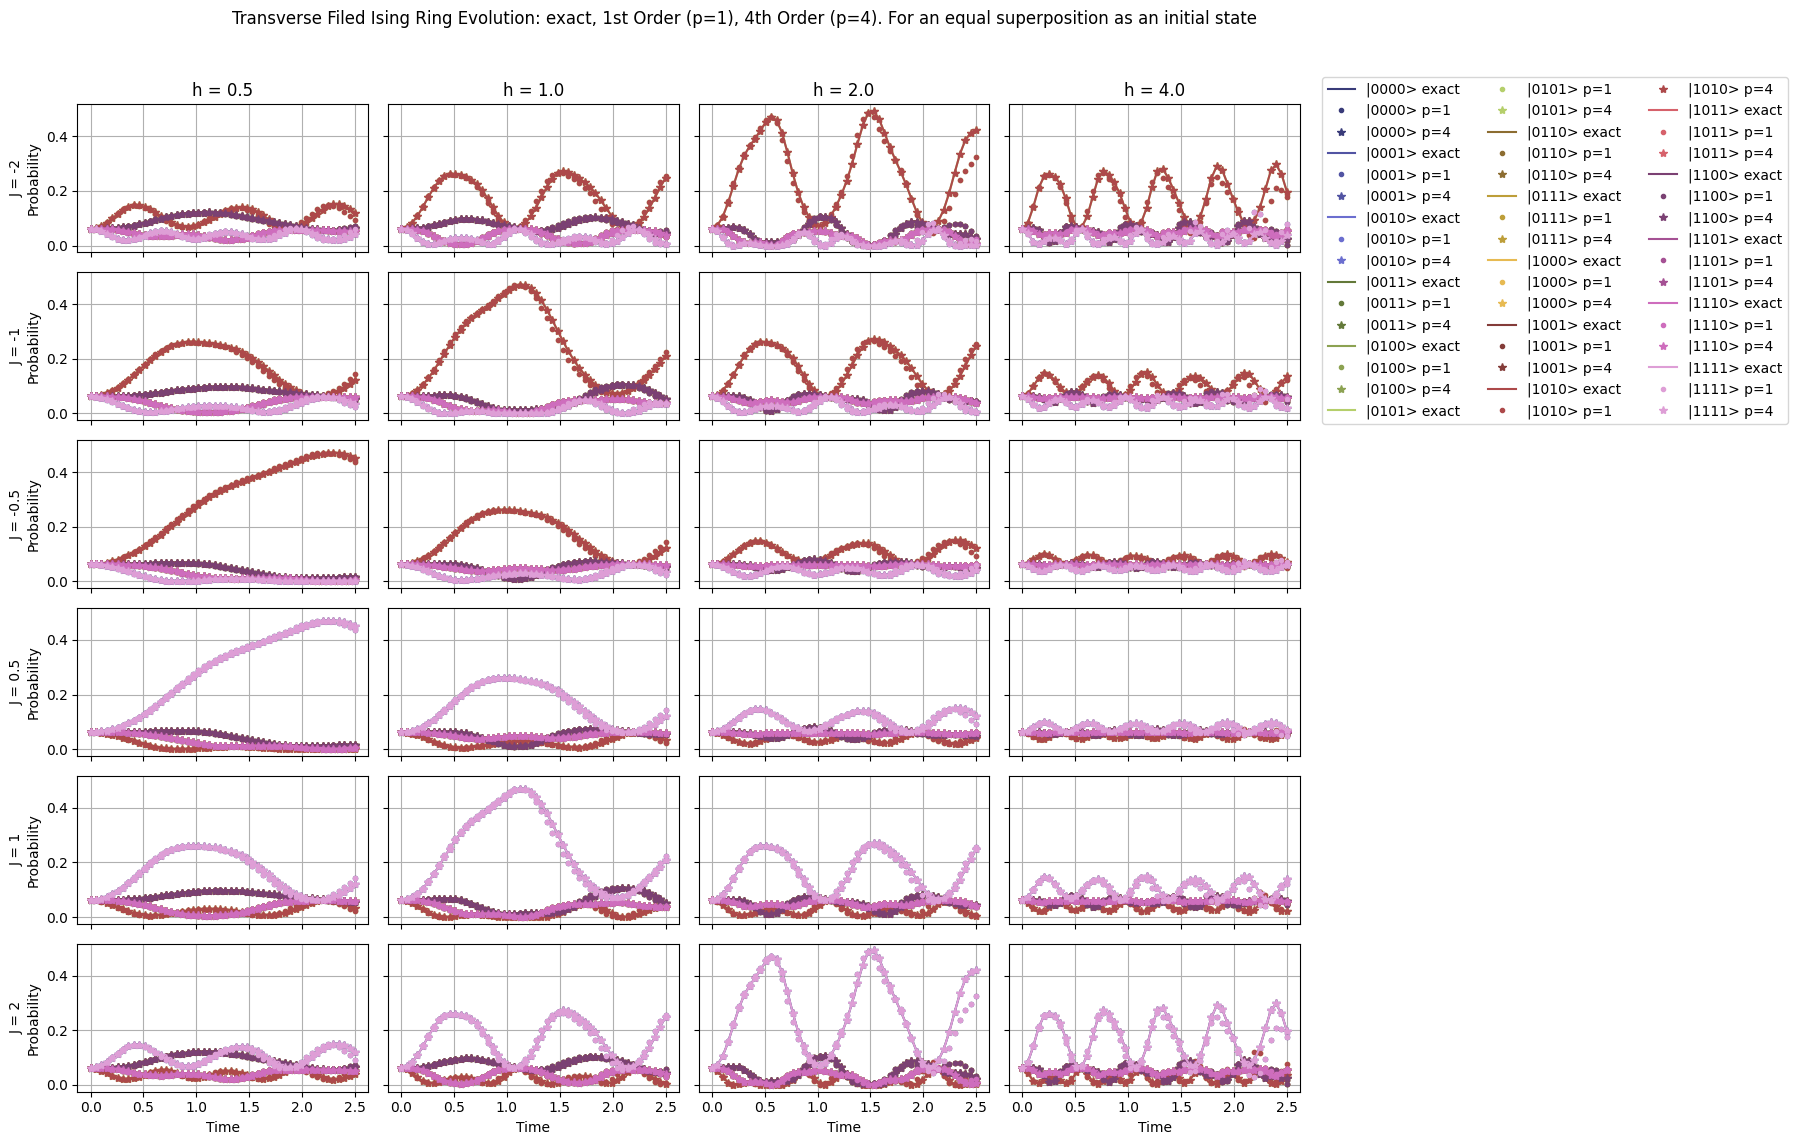

In [ ]:
N = 4
J_values = [-2, -1, -0.5,0.5, 1, 2]
h_values = [0.5, 1.0, 2.0, 4.0]
orders   = [1, 4]
r_steps  = 15
t_final  = 2.5
times    = np.linspace(0, t_final, 50)

# Equal superpostion
qc_h = QuantumCircuit(N)
qc_h.h(range(N))
initial_state = Statevector.from_instruction(qc_h).data
num_states = 2**N
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, num_states)]

fig, axes = plt.subplots(len(J_values), len(h_values),
                         figsize=(15, 12),
                         sharex=True, sharey=True)

for i, J in enumerate(J_values):
    for j, h in enumerate(h_values):
        ax = axes[i, j]
        probs_exact = simulate_exact(N, J, h, initial_state, times)
        probs_p1    = simulate_over_time(N, J, h, initial_state, r_steps, 1, times)
        probs_p4    = simulate_over_time(N, J, h, initial_state, r_steps, 4, times)
        for s in range(num_states):
            c = colors[s]
            label = f"|{s:0{N}b}>"
            ax.plot(times, probs_exact[:,s],  '-', color=c, label=f"{label} exact")
            ax.plot(times, probs_p1[:,s],     '.', color=c, label=f"{label} p=1")
            ax.plot(times, probs_p4[:,s],    '*', color=c, label=f"{label} p=4")
        if i == 0:
            ax.set_title(f"h = {h}")
        if j == 0:
            ax.set_ylabel(f"J = {J}\nProbability")
        if i == len(J_values)-1:
            ax.set_xlabel("Time")
        ax.grid(True)

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=3, bbox_to_anchor=(1.2, 0.9))

plt.suptitle("Transverse Filed Ising Ring Evolution: exact, 1st Order (p=1), 4th Order (p=4). For an equal superposition as an initial state", y=0.95)
plt.tight_layout(rect=[0,0,0.88,0.93])
plt.show()


We can learn a lot from these graphs:

 - First of all, we can clearly see that the 4th order trotterization performs much better than the first order approximation. This is to be expected since we are only simulating the circuit so there is no noise counterplay. We will explore this later.

 - Secondly, as $h$ increases we can clearly notice the effects of the transverse field take place. For large $h$ the dynamics are a lot more interesting and the state diversity is a lot more mixed.

 - Finally, some initial states cause the time evolution to be the same for $J$ and $-J$ while others generate the same curves for both but swap some qubits. Let's approach these results and try to explain them using the symmetries of the Ising model Hamiltonian.



When $N$ is even, the ring is bipartite.  If we define the following symmetry operator as
$$
U = \prod_{i\in\mathrm{odd}} e^{i\frac\pi2\sigma^x_i} = \prod_{k=1}^{N/2}(i\,\sigma^x_{2k-1}),
$$
so that $e^{i\frac\pi2\sigma^x}=i\sigma^x$ we find that
$$
U\,\sigma^z_i\,U^\dagger = \begin{cases} -\sigma^z_i,&i\text{ odd},\\ +\sigma^z_i,&i\text{ even}, \end{cases}
\quad U\,\sigma^x_i\,U^\dagger=\sigma^x_i.
$$
This means that our Hamiltonian has the property:
$$
U\,H(J,h)\,U^\dagger = H(-J,h).
$$
That is, the ferromagnetic ($J>0$) and antiferromagnetic ($J< 0$) models for even $N$ are equivalent up to some unitary transformation.  Consequently, any state evolving as $|\psi(t)\rangle=e^{-iH(J,h)t}|\psi(0)\rangle$ under $J$ corresponds to $U|\psi(t)\rangle=e^{-iH(-J,h)t}|\psi(0)\rangle$ under $-J$, so the populations in the $z$ basis are identical up to relabeling by $U$. This is what happens in the last plot, where the evolution curves are the same but the statevectors for $J$ have their "even label spins" swapped in relation to the statevectors for $-J$.

For odd $N$, the graph is not bipartite! So the operator
$$
U=\prod_{i\in\mathrm{odd}}i\,\sigma^x_i
$$
flips an odd number of $\sigma^z$ operators, leaving one bond unflipped.  Explicitly,

$$
U\,H(J,h)\,U^\dagger = H(-J,h) + 2J\,\sigma^z_N\sigma^z_1,
$$

so there isn't a global unitary map from $H(J,h)$ to $H(-J,h)$ and the models differ genuinely hence the different results for the third graph (equal superposition for $N=3$).

Nevertheless, certain basis states remain invariant (up to a phase) under the odd-sublattice rotation $U$.  If $|x\rangle$ is an eigenstate of our symmetry operator $U|x\rangle = \pm|x\rangle$, then

$$
\langle x|e^{-iH(-J,h)t}|x\rangle = \langle x|Ue^{-iH(J,h)t}U^\dagger|x\rangle = \langle x|e^{-iH(J,h)t}|x\rangle
$$

so their populations are identical for $J$ and $-J$.  Some examples include the fully polarized states $|00\dots0\rangle$ and $|11\dots1\rangle$, since each odd-site flip contributes a factor $i$, giving $U|00\dots0\rangle=i^{(N+1)/2}|00\dots0\rangle$ but leaves the computational basis label unchanged which is precisely what we see in the first graph ($|\psi_0\rangle=|000\rangle$).  More generally, any $|x\rangle$ with an even number of spins up on odd sites satisfies $U|x\rangle=+|x\rangle$, while those with an odd number satisfy $U|x\rangle=-|x\rangle$.  Thus populations for these states coincide under both couplings, which is what happens in the second graph ($|\psi_0\rangle=|011\rangle$).

In all of the graphs we can observe these situations: even $N$ rings have a full unitary mapping $J\leftrightarrow -J$.  For odd $N$, global equivalence fails, yet individual basis states invariant under the sublattice rotation still exhibit identical dynamics for $J$ and $-J$.


Now let's evaluate the error scaling of the different product formulas. There are two immediate ways we can do this:

We can compute the unitary time evolution operator exactly and compare it to the different trotterized opearators and evaluate the bound (as we have seen):

$$
\|U(t)-\mathcal U_p(t;r)\|\leq\mathcal O(t^{p+1}/r^p)
$$

Here we are considering $N$ and the other parameters ($J,h$) constant and treating these as just constant factors to the $r$ scaling which is what we are interested in here.

This apprach is not too difficult to implement since Qiskit allows us to get the unitary matrix from the circuits we construct previously directly.

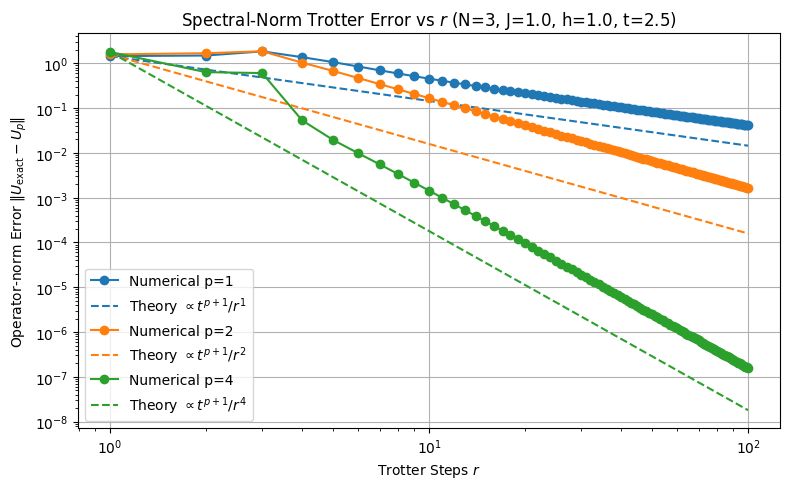

In [ ]:
from scipy.linalg import expm, norm
from qiskit.quantum_info import Operator

def exact_unitary(N, J, h, t):
    X = np.array([[0,1],[1,0]], dtype=complex)
    Z = np.array([[1,0],[0,-1]], dtype=complex)
    I = np.eye(2, dtype=complex)

    def kron_n(mats):
        out = mats[0]
        for m in mats[1:]:
            out = np.kron(out, m)
        return out

    HZ = np.zeros((2**N, 2**N), dtype=complex)
    HX = np.zeros_like(HZ)
    for i in range(N):
        ops = [I]*N
        ops[i], ops[(i+1)%N] = Z, Z
        HZ += J * kron_n(ops)
        ops = [I]*N
        ops[i] = X
        HX += h * kron_n(ops)

    H = HZ + HX
    return expm(-1j * H * t)


N       = 3
J, h    = 1.0, 1.0
orders  = [1, 2, 4]
r_vals  = np.arange(1, 101)
t_final = 2.5
initial_state = None

U_exact = exact_unitary(N, J, h, t_final)

errors = {p: [] for p in orders}
for r in r_vals:
    for p in orders:
        qc_p = generate_trotterized_circuit(
            N, J, h, t_final, initial_state, r, p
        )
        U_trot = Operator(qc_p)
        errors[p].append(norm(U_exact - U_trot, 2))

bounds = {}
for p in orders:
    B = t_final**(p+1) / (r_vals**p)
    scale = errors[p][0] / B[0]
    bounds[p] = scale * B

plt.figure(figsize=(8,5))
cmap = plt.get_cmap('tab10')
for idx, p in enumerate(orders):
    col = cmap(idx)
    plt.plot(r_vals, errors[p], 'o-', color=col, label=f"Numerical p={p}")
    plt.plot(r_vals, bounds[p], '--', color=col, label=f"Theory $\\propto t^{{p+1}}/r^{p}$")

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Trotter Steps $r$")
plt.ylabel(r"Operator‑norm Error $\|U_{\rm exact}-U_p\|$")
plt.title(f"Spectral‑Norm Trotter Error vs $r$ (N={N}, J={J}, h={h}, t={t_final})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Or alternatively we can compute the $L^2$ norm between the states for some $t$ like so:

$$
\begin{align*}
\|\psi(t)-\psi_p(t;r)\|_2=\|(U(t)-\mathcal U(t;r))\psi_0\|_2\leq\|U(t)-\mathcal U(t;r)\|\|\psi_0\|_2=\|U(t)-\mathcal{U}(t;r)\|\leq\mathcal O(t^{p+1}/r^p)
\end{align*}
$$

So the statevectors obbey a slightly less tight version of the error bound we derived earlier.

In fact the results are basically identical between these two methods:

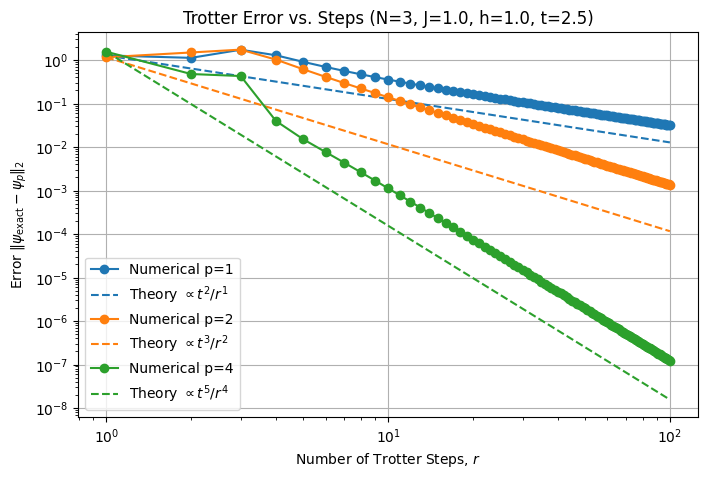

In [ ]:
def simulate_exact_state(N, J, h, psi0, t):
    X = np.array([[0,1],[1,0]],dtype=complex)
    Z = np.array([[1,0],[0,-1]],dtype=complex)
    I = np.eye(2,dtype=complex)
    def kron_n(mats):
        out = mats[0]
        for m in mats[1:]:
            out = np.kron(out,m)
        return out

    HZ = np.zeros((2**N,2**N),dtype=complex)
    HX = np.zeros_like(HZ)
    for i in range(N):
        ops = [I]*N
        ops[i], ops[(i+1)%N] = Z, Z
        HZ += J * kron_n(ops)
        ops = [I]*N
        ops[i] = X
        HX += h * kron_n(ops)
    H = HZ + HX

    U = expm(-1j * H * t)
    return U @ psi0

def simulate_trotter_state(N, J, h, psi0, r, p, t):
    qc = generate_trotterized_circuit(
        N, J, h, t, psi0, r, p
    )
    sv = Statevector.from_instruction(qc)
    return sv.data

N        = 3
J, h     = 1.0, 1.0
orders   = [1, 2, 4]
r_values = np.arange(1, 101)
t_final  = 2.5
psi0     = Statevector.from_label("0"*N).data

exact_psi = simulate_exact_state(N, J, h, psi0, t_final)

errors = {p: [] for p in orders}
for r in r_values:
    for p in orders:
        psi_p = simulate_trotter_state(N, J, h, psi0, r, p, t_final)
        err = np.linalg.norm(exact_psi - psi_p)
        errors[p].append(err)

bounds = {}
for p in orders:
    B = t_final**(p+1) / (r_values**p) #bounds up to constant factor
    scale = errors[p][0] / B[0]
    bounds[p] = scale * B

plt.figure(figsize=(8,5))
color_map = plt.get_cmap('tab10')
for idx, p in enumerate(orders):
    color = color_map(idx)
    plt.plot(
        r_values, errors[p],
        marker='o', linestyle='-',
        color=color,
        label=f"Numerical p={p}"
    )
    plt.plot(
        r_values, bounds[p],
        linestyle='--',
        color=color,
        label=f"Theory $\\propto t^{p+1}/r^{p}$"
    )

plt.yscale('log')
plt.xscale('log')
plt.xlabel("Number of Trotter Steps, $r$")
plt.ylabel(r"Error $\|\psi_{\rm exact}-\psi_p\|_2$")
plt.title(f"Trotter Error vs. Steps (N={N}, J={J}, h={h}, t={t_final})")
plt.legend()
plt.grid(True)
plt.show()


We can clearly see how impactful using higher orders can be. Additionally we confirm that our bounds work as expected and predict the scaling of the error perfectly for every order. It's important to note that it's possible to get much tighter bounds for the errors, however this would take a lot more effort to evaluate since it's still an active area of research (and much more complex that what we've treated here).

Another idea which we don't implement here, is too see how the energy changes with the number of trotter steps. In theorey the energy should remain constant, which doesn't happen in our approximation starts introducing errors. The deviation between the obtained energies and the theoretical constant value could be a way to measure the trotter error.

Now we will be studying the evolution of the transverse quantum magnetization:
$$
M_x(t) \;=\;\Bigl\langle \sum_{i=1}^N X_i \Bigr\rangle_t = \langle \psi(t) | S_x | \psi(t) \rangle,\quad S_x = \sum_i X_i,
$$
which measures how much the spins have tilted into the $x$-basis under the transverse field $h$.

We can gain extra insight by comparing its evolution to the longitudinal magnetization:
$$
M_z(t) \;=\;\Bigl\langle \sum_{i=1}^N Z_i \Bigr\rangle_t = \langle \psi(t) | S_z | \psi(t) \rangle, \quad S_z = \sum_i Z_i,
$$
which tracks the remaining alignment along the original $z$-axis favored by the Ising coupling $J$.

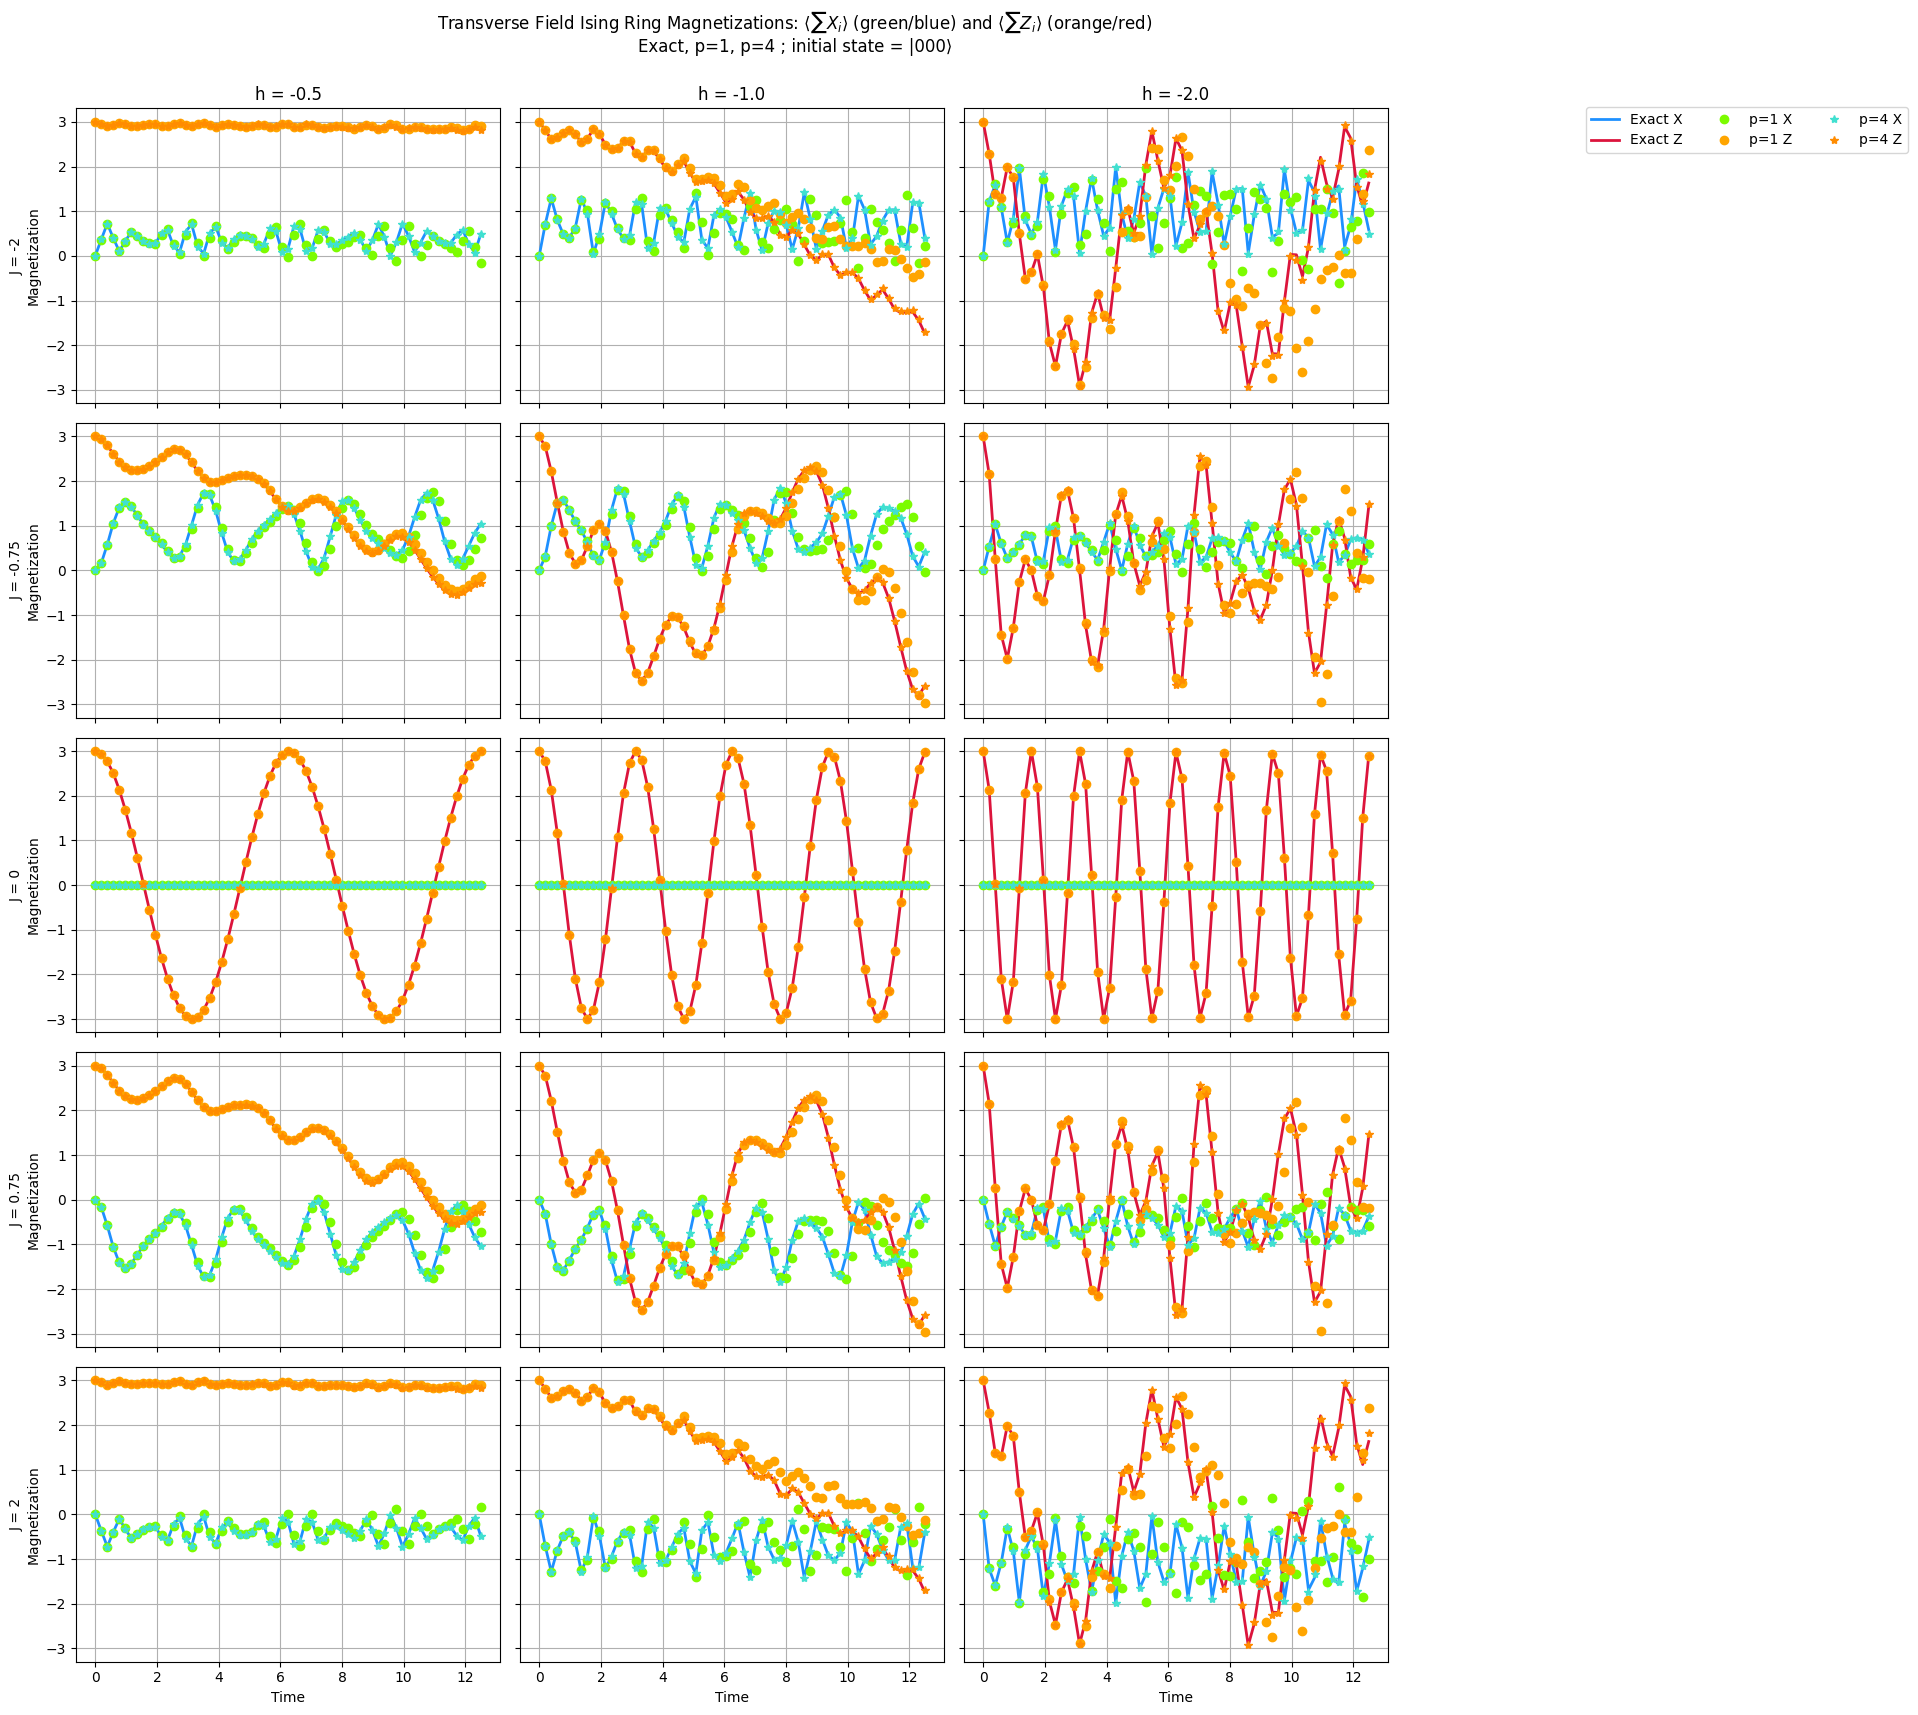

In [ ]:
from functools import reduce
from scipy.linalg import expm
from qiskit.quantum_info import Statevector, SparsePauliOp

def build_Sx_matrix(N):
    X = np.array([[0,1],[1,0]], dtype=complex)
    I = np.eye(2, dtype=complex)
    Sx = np.zeros((2**N, 2**N), dtype=complex)
    for i in range(N):
        ops = [I]*N
        ops[i] = X
        Sx += reduce(np.kron, ops)
    return Sx

def build_Sz_matrix(N):
    Z = np.array([[1,0],[0,-1]], dtype=complex)
    I = np.eye(2, dtype=complex)
    Sz = np.zeros((2**N, 2**N), dtype=complex)
    for i in range(N):
        ops = [I]*N
        ops[i] = Z
        Sz += reduce(np.kron, ops)
    return Sz

def simulate_exp_exact(N, J, h, psi0, times, S):
    X = np.array([[0,1],[1,0]], dtype=complex)
    Z = np.array([[1,0],[0,-1]], dtype=complex)
    I = np.eye(2, dtype=complex)
    H = np.zeros((2**N, 2**N), dtype=complex)
    for i in range(N):
        ops = [I]*N
        ops[i] = Z; ops[(i+1)%N] = Z
        H += J * reduce(np.kron, ops)
        ops = [I]*N; ops[i] = X
        H += h * reduce(np.kron, ops)

    ex = np.zeros(len(times))
    for idx, t in enumerate(times):
        U = expm(-1j * H * t)
        psi_t = U @ psi0
        ex[idx] = np.real(np.vdot(psi_t, S @ psi_t))
    return ex

def simulate_exp_trotter(N, J, h, psi0_label, trotter_steps, order, times, op_qiskit):
    ex = np.zeros(len(times))
    for idx, t in enumerate(times):
        qc = generate_trotterized_circuit(
            N, J, h, t, psi0_label, trotter_steps, order
        )
        sv = Statevector.from_instruction(qc)
        ex[idx] = np.real(sv.expectation_value(op_qiskit))
    return ex


N = 3
J_values = [-2, -0.75, 0, 0.75, 2]
h_values = [-0.5, -1.0, -2.0]
trotter_steps = 50
times = np.linspace(0, 12.5, 65)
initial_label = "000"
psi0 = Statevector.from_label(initial_label).data

Sx_mat = build_Sx_matrix(N)
Sz_mat = build_Sz_matrix(N)

pauli_list_x = [("X", [i], 1.0) for i in range(N)]
Sx_qiskit = SparsePauliOp.from_sparse_list(pauli_list_x, num_qubits=N)
pauli_list_z = [("Z", [i], 1.0) for i in range(N)]
Sz_qiskit = SparsePauliOp.from_sparse_list(pauli_list_z, num_qubits=N)

c_x_exact = 'dodgerblue'
c_x_p4    = 'turquoise'
c_x_p1    = 'lawngreen'
c_z_exact = 'crimson'
c_z_p4    = 'darkorange'
c_z_p1    = 'orange'

fig, axes = plt.subplots(len(J_values), len(h_values),
                         figsize=(16, 18),
                         sharex=True, sharey=True)

for i, J in enumerate(J_values):
    for j, h in enumerate(h_values):
        ax = axes[i, j]

        mx_ex = simulate_exp_exact(N, J, h, psi0, times, Sx_mat)
        mz_ex = simulate_exp_exact(N, J, h, psi0, times, Sz_mat)

        mx_p1 = simulate_exp_trotter(N, J, h, initial_label, trotter_steps, 1, times, Sx_qiskit)
        mz_p1 = simulate_exp_trotter(N, J, h, initial_label, trotter_steps, 1, times, Sz_qiskit)

        mx_p4 = simulate_exp_trotter(N, J, h, initial_label, trotter_steps, 4, times, Sx_qiskit)
        mz_p4 = simulate_exp_trotter(N, J, h, initial_label, trotter_steps, 4, times, Sz_qiskit)

        ax.plot(times, mx_ex, '-',  color=c_x_exact, label='Exact X',linewidth=2)
        ax.plot(times, mz_ex, '-', color=c_z_exact, label='Exact Z', linewidth=2)

        ax.plot(times, mx_p1, 'o',  color=c_x_p1,    label='p=1 X')
        ax.plot(times, mz_p1, 'o',  color=c_z_p1,    label='p=1 Z')

        ax.plot(times, mx_p4, '*',  color=c_x_p4,    label='p=4 X', linewidth=1.5)
        ax.plot(times, mz_p4, '*',  color=c_z_p4,    label='p=4 Z', linewidth=1.5)

        if i == 0:
            ax.set_title(f"h = {h}")
        if j == 0:
            ax.set_ylabel(f"J = {J}\nMagnetization")
        if i == len(J_values)-1:
            ax.set_xlabel("Time")
        ax.grid(True)

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels,
           loc='upper right', ncol=3, bbox_to_anchor=(1.2, 0.9))

plt.suptitle(
    "Transverse Field Ising Ring Magnetizations: $\\langle \\sum X_i\\rangle$ (green/blue) and $\\langle \\sum Z_i\\rangle$ (orange/red)\n"
    "Exact, p=1, p=4 ; initial state = |000⟩",
    y=0.95
)
plt.tight_layout(rect=[0,0,0.88,0.95])
plt.show()


For other $N$ values the results are similar.

Note that we chose the all-zero state as the initial state which means all spins start fully aligned in the $z$ basis.

When the coupling is strong ($|J|\gg h$), $M_z$ remains large (the spins keep pinned along $z$), so $M_x$ oscillations are small.  

Intermediate regimes show beating and partial revivals as the competition between $J$ and $h$ excites multiple spin-wave modes.

At strong field ($h\gg |J|$), the transverse field term dominates and $M_z$ oscilates between $-N$ and $N$, while $M_x$ oscillations stay small since rotations about the $x$-axis never produce a net $X$ component from an initial $Z$ eigenstate.

In this regime to leading order we may neglect the weak Ising coupling:
$$
H \;\approx\; h\sum_{i} X_i
\quad\Longrightarrow\quad
U(t) \;=\; e^{-iHt} \;=\;\bigl(e^{-ihtX}\bigr)^{\otimes N}.
$$

So the transverse magnetization becomes:
$$
M_x(t)
=\bigl\langle \sum_i X_i \bigr\rangle_t
=\sum_i \langle 0|\,e^{ihtX}\,X\,e^{-ihtX}\,|0\rangle
\;=\;0,
$$
which we have already explained.

The longitudinal magnetization has the assymptotic behaviour:
$$
M_z(t)
=\bigl\langle \sum_i Z_i \bigr\rangle_t
=\sum_i \langle 0|\,e^{ihtX}\,Z\,e^{-ihtX}\,|0\rangle
=\sum_i \cos(2ht)
\;=\;N\cos(2ht).
$$
Thus $M_z(t)$ undergoes full-amplitude Rabi oscillations at frequency $2h$.

If we include a small perturbation $J\neq0$ this shifts the oscillation frequencies and introduces weak beat modulations:
$$
M_z(t)\;\approx\;\sum_{i}\cos\bigl(2ht+\phi_J\bigr),
$$
where $\phi_J\sim O(J/h)$. This is the beating that we observe, although pushing this limit in simulations is not exactly easy due to the fast oscillations produced (unless we simply take $J=0$ which yields exactly what we just described).

Let's take this chance and introduce a noise model into our simulations to observe how this changes the output magnetizations. An interesting (but not optimal) way to measure the transversal magnetization, is to attach a layer of hadamards at the end of all the trotter layers. This is the same as rotating our system from the z-basis to the x-basis allowing us to use the counts in the same way we do for $M_z$.





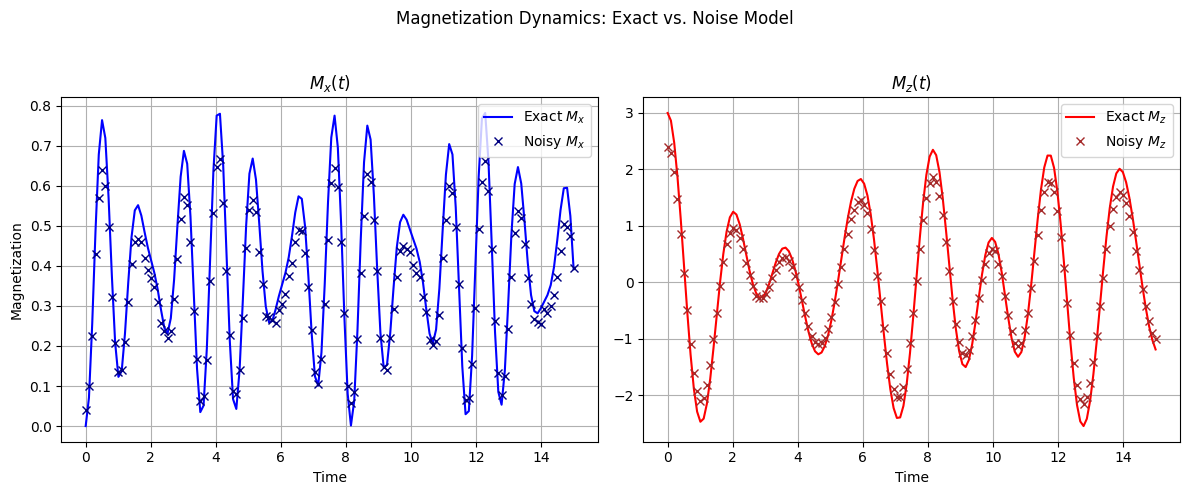

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from scipy.linalg import expm
from qiskit import transpile
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import RXGate
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, coherent_unitary_error, amplitude_damping_error, ReadoutError
from qiskit_aer.primitives import SamplerV2 as Sampler

N, J, h = 3, 0.4, 1.5
steps = 300
times = np.linspace(0, 15, 150)
shots = 8192*4

def build_S(N, pauli):
    P = {
        'X': np.array([[0,1],[1,0]], complex),
        'Z': np.array([[1,0],[0,-1]], complex)
    }[pauli]
    I = np.eye(2, dtype=complex)
    return sum(
        reduce(np.kron, [(P if k == i else I) for k in range(N)])
        for i in range(N)
    )

psi0 = Statevector.from_label("000").data

def exact_obs(S):
    X = np.array([[0,1],[1,0]], complex)
    Z = np.array([[1,0],[0,-1]], complex)
    I = np.eye(2, dtype=complex)
    H = sum(
        J * reduce(np.kron, [(Z if k in (i,(i+1)%N) else I) for k in range(N)]) +
        h * reduce(np.kron, [(X if k == i else I) for k in range(N)])
        for i in range(N)
    )
    return np.array([
        np.real(np.vdot(expm(-1j * H * t) @ psi0,
                        S @ (expm(-1j * H * t) @ psi0)))
        for t in times
    ])

mx_exact = exact_obs(build_S(N, 'X'))
mz_exact = exact_obs(build_S(N, 'Z'))

circuits_x = []
circuits_z = []
for t in times:
    qc = generate_trotterized_circuit(N, J, h, t, "000", steps, 1)
    # X-basis
    qc_x = qc.copy()
    for q in range(N):
        qc_x.h(q)
    qc_x.measure_all()
    circuits_x.append(transpile(qc_x, AerSimulator()))
    # Z-basis
    qc_z = qc.copy()
    qc_z.measure_all()
    circuits_z.append(transpile(qc_z, AerSimulator()))

coh = coherent_unitary_error(RXGate(0.08).to_matrix())
inc = amplitude_damping_error(0.04)
ro = ReadoutError([[0.90,0.10],[0.08,0.92]])
noise = NoiseModel()
for gate in ['u1','u2','u3','x','h','sx','s','sdg']:
    noise.add_all_qubit_quantum_error(inc, gate)
noise.add_readout_error(ro, (0, ))
noise.add_readout_error(ro, (1, ))
noise.add_readout_error(ro, (2, ))

sampler = Sampler(options={"backend_options": {"noise_model": noise}})

pubs_x = [(circuits_x[i], None, shots) for i in range(len(circuits_x))]
job_x = sampler.run(pubs_x).result()
counts_x = [res.data.meas.get_counts() for res in job_x]

pubs_z = [(circuits_z[i], None, shots) for i in range(len(circuits_z))]
job_z = sampler.run(pubs_z).result()
counts_z = [res.data.meas.get_counts() for res in job_z]

def mz_from_counts(counts):
    total = 0
    for bitstr, cnt in counts.items():
        vals = [1 if b=='0' else -1 for b in bitstr[::-1]]
        total += cnt * sum(vals)
    return total / shots

mx_noisy = np.array([mz_from_counts(c) for c in counts_x])
mz_noisy = np.array([mz_from_counts(c) for c in counts_z])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5), sharex=True)

ax1.plot(times, mx_exact, '-', color='blue', label='Exact $M_x$')
ax1.plot(times, mx_noisy, 'x', color='navy', label='Noisy $M_x$')
ax1.set_title(r'$M_x(t)$')
ax1.set_xlabel('Time')
ax1.set_ylabel('Magnetization')
ax1.grid(True)
ax1.legend()

ax2.plot(times, mz_exact, '-', color='red', label='Exact $M_z$')
ax2.plot(times, mz_noisy, 'x', color='brown', label='Noisy $M_z$')
ax2.set_title(r'$M_z(t)$')
ax2.set_xlabel('Time')
ax2.grid(True)
ax2.legend()

plt.suptitle('Magnetization Dynamics: Exact vs. Noise Model')
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


In this simulation we've combined three types of errors to approximate realistic device noise:

Coherent (Unitary) Error which is implemented as a small over-rotation on every $RX$-gate which introcudes a term $U_{\text{err}} = e^{-i\,\delta\,X/2}$ in every rotation.  

Incoherent (Amplitude Damping) Error which models energy relaxation $ |1\rangle \to |0\rangle $ with some defined probability.

And Readout (Measurement) Error which captures mis-assignment in the final measurements by introducing probability of measuring the opposite state.  

This gives a balanced mixture of unitary, stochastic, and measurement imperfections for our noisy SamplerV2 runs.  We can clearly notice its impacts especially at high magnetizations. Of course the more noise we add to the model the worse the results are.


We can also study how the distributions change with the size of our ring ($N$):

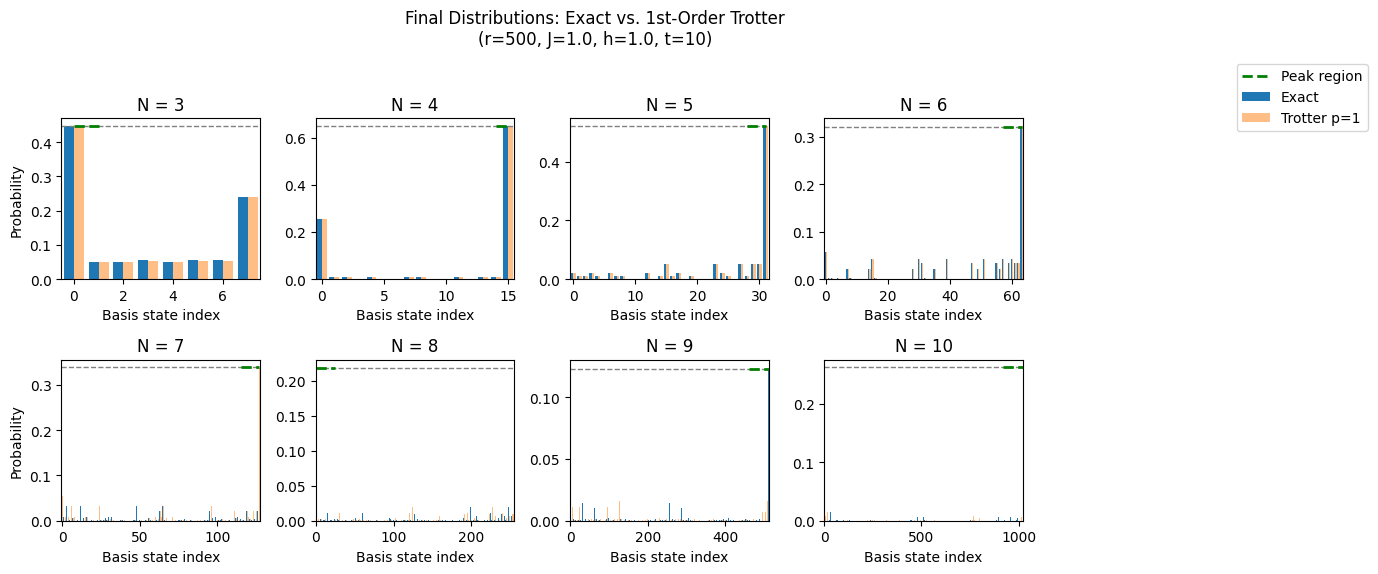

In [ ]:
from scipy.linalg import expm

def final_probs_exact(N, J, h, psi0, t_final):
    X = np.array([[0,1],[1,0]], dtype=complex)
    Z = np.array([[1,0],[0,-1]], dtype=complex)
    I = np.eye(2, dtype=complex)
    def kron_n(ops):
        out = ops[0]
        for m in ops[1:]:
            out = np.kron(out, m)
        return out

    HZ = np.zeros((2**N, 2**N), dtype=complex)
    HX = np.zeros_like(HZ)
    for i in range(N):
        ops = [I]*N
        ops[i], ops[(i+1)%N] = Z, Z
        HZ += J * kron_n(ops)
        ops = [I]*N
        ops[i] = X
        HX += h * kron_n(ops)

    U = expm(-1j*(HZ+HX)*t_final)
    psi = U @ psi0
    return np.abs(psi)**2

J       = 1.0
h       = 1.0
t_final = 10
r       = 500
N_values = list(range(3, 11))
initial_state = lambda N: np.eye(1, 2**N, dtype=complex).reshape(-1)

dist_exact   = {}
dist_trotter = {}
for N in N_values:
    psi0 = initial_state(N); psi0[0] = 1.0
    dist_exact[N]   = final_probs_exact(N, J, h, psi0, t_final)
    dist_trotter[N] = np.abs(Statevector.from_instruction(generate_trotterized_circuit(N, J, h, t_final, psi0, r, trotter_order=1)).data)**2

ncols = 4
nrows = 2
fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(12, 3*nrows),
    sharex=False,
    sharey=False
)

for idx, N in enumerate(N_values):
    row = idx // ncols
    col = idx % ncols
    ax  = axes[row, col]
    probs_ex = dist_exact[N]
    probs_tr = dist_trotter[N]
    states = np.arange(2**N)

    ax.bar(states - 0.2, probs_ex, width=0.4, label='Exact', alpha=1.0, color='C0')
    ax.bar(states + 0.2, probs_tr, width=0.4, label='Trotter p=1', alpha=0.5, color='C1')

    i_max = np.argmax(probs_ex)
    p_max = probs_ex[i_max]

    ax.axhline(p_max, color='grey', linestyle='--', linewidth=1)

    span = max(1, int(0.1 * len(states)))
    left = max(0, i_max - span)
    right = min(len(states) - 1, i_max + span)
    ax.hlines(p_max, left, right,
              colors='green', linestyles='--', linewidth=2,
              label='Peak region' if idx == 0 else None)

    ax.set_title(f"N = {N}")
    ax.set_xlim(-0.5, 2**N - 0.5)
    ax.set_xlabel("Basis state index")
    if col == 0:
        ax.set_ylabel("Probability")

for ax in axes.flat[len(N_values):]:
    ax.axis('off')

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15, 0.9))

plt.suptitle(
    f"Final Distributions: Exact vs. 1st-Order Trotter\n"
    f"(r={r}, J={J}, h={h}, t={t_final})"
)
plt.tight_layout(rect=[0, 0.03, 0.88, 0.95])
plt.show()



It's hard to tell much just from looking at the distributions especially for higher $N$ since the pool of the possible states is so vast. In general, for the $|\psi_0\rangle=|0\rangle^{\otimes N}$ initial state we observe that the max probabilities are hit for the fully polarized states. We can also see how diluted the probabilities become when there are more spins in the ring.

Let's focus on the evolution of the $|\psi\rangle=|\psi_0\rangle=|0\rangle^{\otimes N}$ state now:

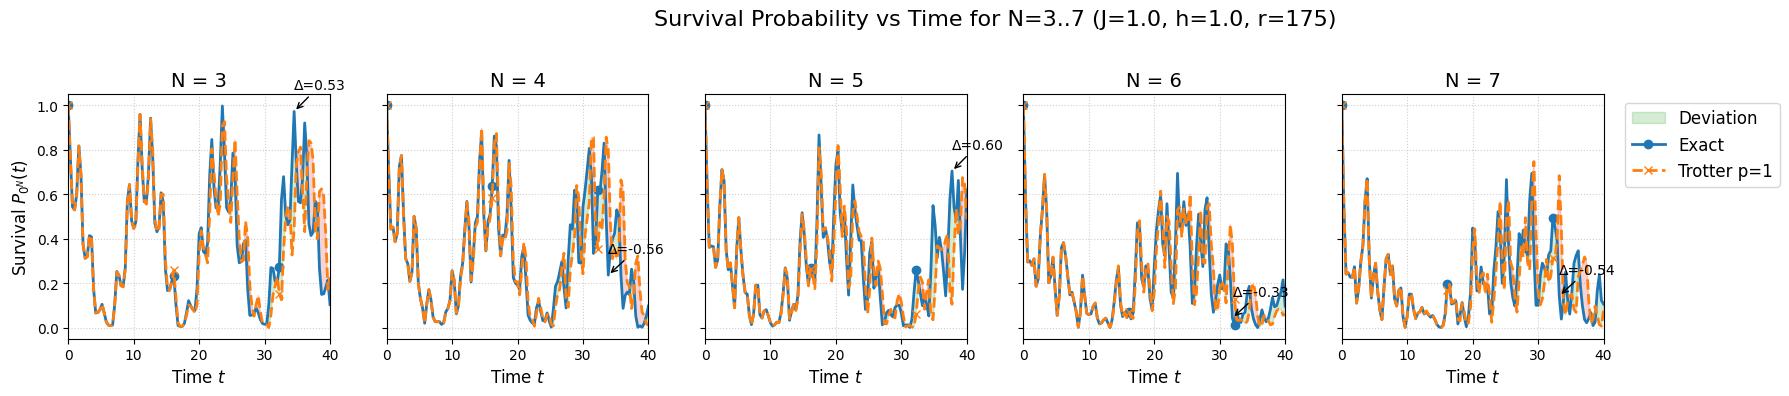

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit.quantum_info import Statevector

def simulate_exact_survival(N, J, h, psi0, times):
    X = np.array([[0,1],[1,0]], dtype=complex)
    Z = np.array([[1,0],[0,-1]], dtype=complex)
    I = np.eye(2, dtype=complex)
    def kron_n(mats):
        out = mats[0]
        for m in mats[1:]:
            out = np.kron(out, m)
        return out
    HZ = np.zeros((2**N,2**N), dtype=complex)
    HX = np.zeros_like(HZ)
    for i in range(N):
        ops = [I]*N; ops[i], ops[(i+1)%N] = Z, Z
        HZ += J * kron_n(ops)
        ops = [I]*N; ops[i] = X
        HX += h * kron_n(ops)
    H = HZ + HX

    surv = np.zeros_like(times)
    for idx, t in enumerate(times):
        U = expm(-1j * H * t)
        psi = U @ psi0
        surv[idx] = np.abs(psi[0])**2
    return surv

def simulate_trotter_survival(N, J, h, psi0, r, times,p=1):
    surv = np.zeros_like(times)
    for idx, t in enumerate(times):
        qc = generate_trotterized_circuit(N, J, h, t, psi0, r, trotter_order=p)
        sv = Statevector.from_instruction(qc)
        surv[idx] = np.abs(sv.data[0])**2
    return surv

J = 1.0
h = 1.0
r = 175
t_final = 40.0
times = np.linspace(0, t_final, 125)

N_values = list(range(3, 8))
psi0_dict = {N: Statevector.from_label("0"*N).data for N in N_values}

exact_surv = {}
trotter_surv = {}
for N in N_values:
    psi0 = psi0_dict[N]
    exact_surv[N] = simulate_exact_survival(N, J, h, psi0, times)
    trotter_surv[N] = simulate_trotter_survival(N, J, h, psi0, r, times)

ncols = len(N_values)
fig, axes = plt.subplots(1, ncols, figsize=(4*ncols, 4), sharey=True)

for ax, N in zip(axes, N_values):
    ex = exact_surv[N]
    tr = trotter_surv[N]
    diff = ex - tr

    ax.fill_between(times, ex, tr, where=ex>=tr, interpolate=True,
                    color='C2', alpha=0.2, label='Deviation')
    ax.fill_between(times, ex, tr, where=tr>ex, interpolate=True,
                    color='C3', alpha=0.2)

    ax.plot(times, ex, label='Exact', color='C0', linewidth=2, marker='o', markevery=50)
    ax.plot(times, tr, label='Trotter p=1', color='C1', linewidth=2, linestyle='--', marker='x', markevery=50)

    idx_max = np.argmax(np.abs(diff))
    t_max = times[idx_max]
    d_max = diff[idx_max]
    ax.annotate(f"Δ={d_max:.2f}", xy=(t_max, ex[idx_max]),
                xytext=(t_max, ex[idx_max]+0.1),
                arrowprops=dict(arrowstyle="->", color='black'))

    ax.set_title(f"N = {N}", fontsize=14)
    ax.set_xlim(0, t_final)
    ax.set_xlabel("Time $t$", fontsize=12)
    ax.grid(True, ls=':', alpha=0.6)

axes[0].set_ylabel("Survival $P_{0^N}(t)$", fontsize=12)
axes[-1].legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=12)

plt.suptitle(f"Survival Probability vs Time for N=3..7 (J={J}, h={h}, r={r})", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


Unfortunately we will have to drop the exact time evolution for higher $N$ since exponentiating a matrix that scales exponentially ($\mathcal O(2^N)$) with the size of the system is not really feasible. Still, we can observe that as long as we increase the number of trotter steps, our product formula approximation can hold up accurately enough for larger times.

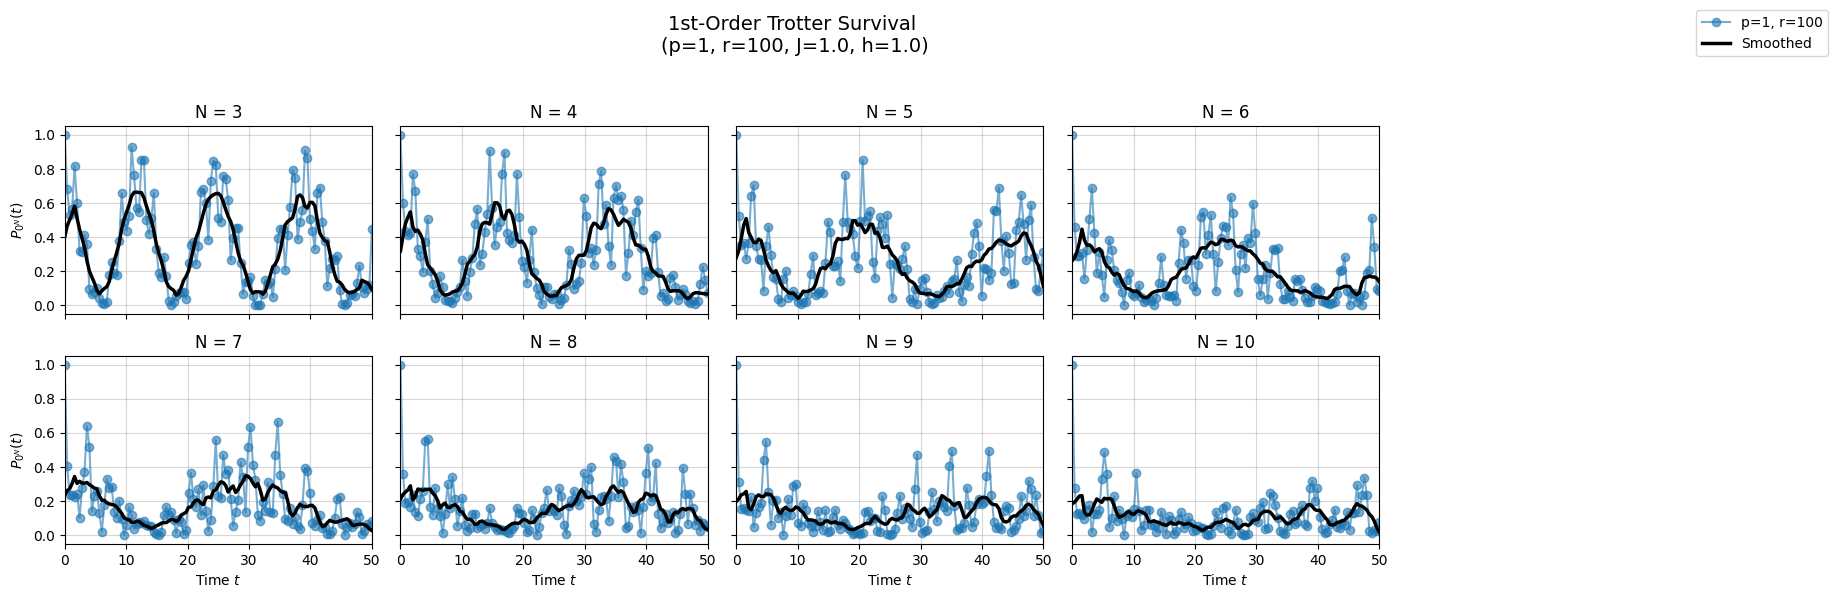

In [ ]:
J       = 1.0
h       = 1.0
r1      = 100
t_final = 50.0
times   = np.linspace(0, t_final, 125)
N_values = list(range(3, 11))

psi0_dict = {N: Statevector.from_label("0"*N).data for N in N_values}

surv_p1 = {N: simulate_trotter_survival(N, J, h, psi0_dict[N], r1, times)
           for N in N_values}

window = 9
kernel = np.ones(window) / window

ncols = 4
nrows = int(np.ceil(len(N_values)/ncols))
fig, axes = plt.subplots(nrows, ncols,
                         figsize=(4*ncols, 3*nrows),
                         sharex=True, sharey=True)

for idx, N in enumerate(N_values):
    row, col = divmod(idx, ncols)
    ax = axes[row, col]
    raw = surv_p1[N]
    smooth = np.convolve(raw, kernel, mode='same')

    ax.plot(times, raw,
            marker='o', linestyle='-', alpha=0.6,
            label=f'p=1, r={r1}')
    ax.plot(times, smooth,
            linestyle='-', linewidth=2.5, color='black',
            label='Smoothed')

    ax.set_title(f"N = {N}", fontsize=12)
    ax.set_xlim(0, t_final)
    if row == nrows-1:
        ax.set_xlabel("Time $t$")
    if col == 0:
        ax.set_ylabel(r"$P_{0^N}(t)$")
    ax.grid(alpha=0.5)

for ax in axes.flat[len(N_values):]:
    ax.axis('off')

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15, 1))

plt.suptitle(
    f"1st‑Order Trotter Survival \n(p=1, r={r1}, J={J}, h={h})",
    fontsize=14
)
plt.tight_layout(rect=[0,0,0.88,0.95])
plt.show()


Decreasing $h$:

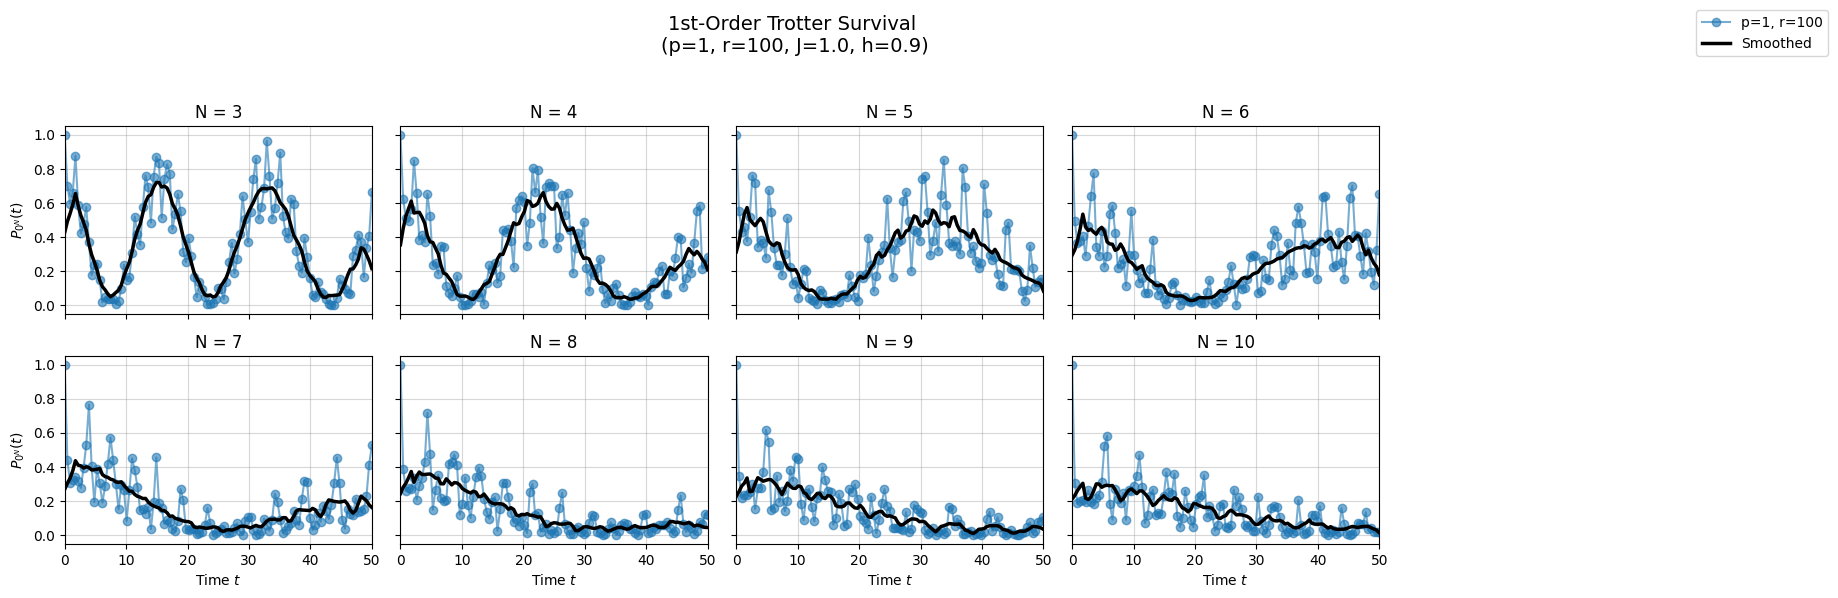

In [ ]:
J       = 1.0
h       = 0.90
r1      = 100
t_final = 50.0
times   = np.linspace(0, t_final, 115)
N_values = list(range(3, 11))

psi0_dict = {N: Statevector.from_label("0"*N).data for N in N_values}

surv_p1 = {N: simulate_trotter_survival(N, J, h, psi0_dict[N], r1, times)
           for N in N_values}

window = 9
kernel = np.ones(window) / window

ncols = 4
nrows = int(np.ceil(len(N_values)/ncols))
fig, axes = plt.subplots(nrows, ncols,
                         figsize=(4*ncols, 3*nrows),
                         sharex=True, sharey=True)

for idx, N in enumerate(N_values):
    row, col = divmod(idx, ncols)
    ax = axes[row, col]
    raw = surv_p1[N]
    smooth = np.convolve(raw, kernel, mode='same')

    ax.plot(times, raw,
            marker='o', linestyle='-', alpha=0.6,
            label=f'p=1, r={r1}')
    ax.plot(times, smooth,
            linestyle='-', linewidth=2.5, color='black',
            label='Smoothed')

    ax.set_title(f"N = {N}", fontsize=12)
    ax.set_xlim(0, t_final)
    if row == nrows-1:
        ax.set_xlabel("Time $t$")
    if col == 0:
        ax.set_ylabel(r"$P_{0^N}(t)$")
    ax.grid(alpha=0.5)

for ax in axes.flat[len(N_values):]:
    ax.axis('off')

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15, 1))

plt.suptitle(
    f"1st‑Order Trotter Survival \n(p=1, r={r1}, J={J}, h={h})",
    fontsize=14
)
plt.tight_layout(rect=[0,0,0.88,0.95])
plt.show()


We can notice immediately that the probability of the zero-state decreases immediately due to the mixing/transverse term and then oscillates indefinitely. As we can see from the $2$ plots the period of these oscillations is bigger for smaller $h$ (keeping $J$ constant), which is to be expected since there is less "mixing" for fainter fields. However they also change with the size of the system.

Let's apply our knowledge of many-body systems and quantum matter to find out how the period of the oscillations depend on $N$. We can tackle the transverse field Ising Hamiltonian in many different ways, like using a Holstein-Primakoff trasnformation like in ferromagnetic magnons, but for this case specifically ($S=1/2$ and $1D$ system) Jordan-Wigner transformations are the most powerful "technology" available.

Let's start from the transverse field Ising Hamiltonian on a ring of $N$ spins with periodic boundary conditions:
$$
H \;=\; -J\sum_{j=1}^{N}Z_j Z_{j+1}\;-\;h\sum_{j=1}^{N}X_j,
\qquad Z_{N+1}\equiv Z_1.
$$
Introducing spin-$\tfrac12$ raising/lowering operators $S_j^\pm = \tfrac12(X_j\pm iY_j)$, we can perform the Jordan Wigner transform to fermions $c_j$:
$$
c_j = \exp\Bigl(i\pi\sum_{\ell=1}^{j-1}S^+_\ell S^-_\ell\Bigr)\,S_j^-,
\quad
S_j^- = \exp\Bigl(i\pi\sum_{\ell<j}c^\dagger_\ell c_\ell\Bigr)\,c_j.
$$
Obtaining
$$
Z_j = 1 - 2\,c_j^\dagger c_j,\quad
X_j = \bigl(c_j + c_j^\dagger\bigr)\,
\exp\Bigl(i\pi\!\sum_{\ell<j}c_\ell^\dagger c_\ell\Bigr).
$$
This way the nearest neighbor term becomes

$$
Z_jZ_{j+1} \;=\; (1-2n_j)(1-2n_{j+1})
= 1 - 2(n_j + n_{j+1}) + 4n_jn_{j+1}.
$$

Dropping the constant and quartic term as is usual in Bogoliubov mean field methods (in fact in the free fermion mapping only quadratic terms survive), we obtain

$$
H = -J\sum_j\bigl(c_j^\dagger - c_j\bigr)\bigl(c_{j+1}^\dagger + c_{j+1}\bigr)
\;-\;2h\sum_j\Bigl(c_j^\dagger c_j -\tfrac12\Bigr).
$$

We can impose the periodic boundary conditions on the ring via $c_{N+1}=(-1)^{\hat F}c_1$, where $\hat F=\sum_j c_j^\dagger c_j$ is fermion parity.  This means that the spectrum holds for both even and odd $N$, but we must choose anti-periodic or periodic boundary conditions accordingly.

Next performing the Fourier transform and going to k-space (exploiting the periodicity of the ring),
$$
c_j = \frac{1}{\sqrt{N}}\sum_k e^{ikj}\,c_k,
\qquad
k \in \begin{cases}
\displaystyle \frac{2\pi}{N}\Bigl(m+\tfrac12\Bigr), & \text{even parity (anti‑periodic)},\\[6pt]
\displaystyle \frac{2\pi m}{N}, & \text{odd parity (periodic)},
\end{cases}
\quad m=0,1,\dots,N-1.
$$
In momentum space the Hamiltonian decouples into
$$
H = \sum_k\Bigl[A_k\,\bigl(c_k^\dagger c_k - c_{-k}c_{-k}^\dagger\bigr)
\;+\;B_k\,\bigl(c_k^\dagger c_{-k}^\dagger + c_{-k}c_k\bigr)\Bigr],
$$
with
$$
A_k = -2h + 2J\cos k,
\qquad
B_k = 2J\sin k.
$$
This is instantly recognizable as easily diagonalizeable with Bogoliubov-Valatin transformations:
$$
\gamma_k = u_k\,c_k + v_k\,c_{-k}^\dagger,
\quad
\gamma_{-k} = u_k\,c_{-k} - v_k\,c_k^\dagger,
$$
with coefficients
$$
u_k = \cos\tfrac{\theta_k}{2},\quad v_k = \sin\tfrac{\theta_k}{2},\quad
\tan\theta_k = \frac{B_k}{A_k}.
$$
This way the diagonal form fo the Hamiltonian is
$$
H = \sum_k \epsilon_k\Bigl(\gamma_k^\dagger\gamma_k - \tfrac12\Bigr),
\qquad
\epsilon_k = 2\sqrt{(J\cos k - h)^2 + (J\sin k)^2}
= 2\sqrt{\,J^2 + h^2 - 2Jh\cos k\,}.
$$

Now we can evaluate why the probabilities oscillate. Firstly let's remember that the all-zeros state $\lvert0^N\rangle$ is the vaccum of the $c_j$ modes but not for the diagonal operators $\gamma_k$. For each $(k,-k)$ block the vaccums are related by:

$$
\lvert0^N\rangle=\cos(\theta_k/2)|0_\gamma\rangle+\sin(\theta_k/2)|1_\gamma,1_{-\gamma}\rangle ,
$$

with $\tan\theta_k = \tfrac{A_k}{B_k}=\tfrac{2J\sin k}{2J\cos k - 2h}$.

So the survival amplitude factorizes as a product of independent two-level (Rabi) oscillations,

$$
A(t) \;=\; \langle 0^N|e^{-iHt}|0^N\rangle
\;=\;\prod_k\langle 0^N|e^{-iH_kt}|0^N\rangle_k
\;=\;\prod_k\Bigl[\cos\!\bigl(\tfrac{\epsilon_k t}{2}\bigr)\;-\;i\cos\theta_k\,\sin\!\bigl(\tfrac{\epsilon_k t}{2}\bigr)\Bigr],
$$

Hence the survival probability

$$
P(t) \;=\; |A(t)|^2
$$

contains oscillatory terms at all frequencies $\epsilon_k$.

In fact, $A(t)$ can be written as the product of sums of exponentials $e^{\pm i\epsilon_kt/2}$ so there will be terms like $e^{ -i(\epsilon_k\pm\epsilon_{k'})t/2}$ which is precisely the behaviour of "beat frequencies" we are accustomed to. If we define $\delta\epsilon\equiv|\epsilon_k-\epsilon_{k'}|\ll1$ then the respective exponential term completes an oscillation when $\delta\epsilon=2\pi$. That is, when:
$$
t=\frac{2\pi}{\delta\epsilon}
$$
The product $A(t)$ will only return back to its starting value when every oscillating factor has simultaneously completed an integer number of cycles. The slowest factor to do so is the one with the smallest frequency difference:
$$
\Delta\epsilon \;=\;\min_{k\neq k'}\bigl|\epsilon_k-\epsilon_{k'}\bigr|.
$$
Hence the first approximate “revival” of the entire many-body amplitude occurs at
$$
T_{\rm revive}
\;=\;\frac{2\pi}{\Delta\epsilon}.
$$
To estimate $\Delta\epsilon$, we just have to expand the dispersion around $k=0$.  For $J\neq h$ we finds
$$
\epsilon_k
= 2\sqrt{(J-h)^2 + J h\,k^2 + \mathcal O(k^4)}
= \epsilon_0 + \frac{Jh}{\epsilon_0}\,k^2 + \mathcal O(k^4),
\qquad
\epsilon_0 = 2|J-h|.
$$
Since the smallest nonzero momentum on the ring is $k_{\mathrm{min}} = \tfrac{2\pi}{N}$, the smallest spacing is
$$
\Delta\epsilon
\approx \epsilon_{k_{\mathrm{min}}}-\epsilon_0
\approx \frac{Jh}{2|J-h|}\,\Bigl(\tfrac{2\pi}{N}\Bigr)^2,
$$
and hence
$$
T_{\rm revive}
\;\approx\;
\frac{2\pi}{\Delta\epsilon}
\;\propto\;
\frac{N^2}{\,(Jh/\lvert J-h\rvert)\,}
\;\sim\;N^2.
$$

In the critical case $J=h$, the dispersion becomes linear near $k=0$,
$$
\epsilon_k \approx 2J|k|,\quad
\Delta\epsilon \approx 2J\,\frac{2\pi}{N},
$$
so that
$$
T_{\rm revive}
\;\approx\;
\frac{2\pi}{\Delta\epsilon}
\;\propto\;
\frac{N}{J}
\;\sim\;N.
$$
We can then conclude that whether gapped or critical, the revival period of the survival probability grows with system size: quadratically in the off-critical regime and linearly at criticality explaining the observed slowing of oscillations as $N$ increases. This is due to a phenomenon akin to frequency beatings which we can observe on the plots.

From these results we can easily predict how changing the initial state affects the system and how to track the evolution of any state.

Let's look at some other different initial state: the Néel state $|\text{Neel}\rangle=|101010...\rangle$, which is of special relevance to our system. First we evaluate the probabilities of the all-zero state and then of measuring the exact Néel state that we initialized.


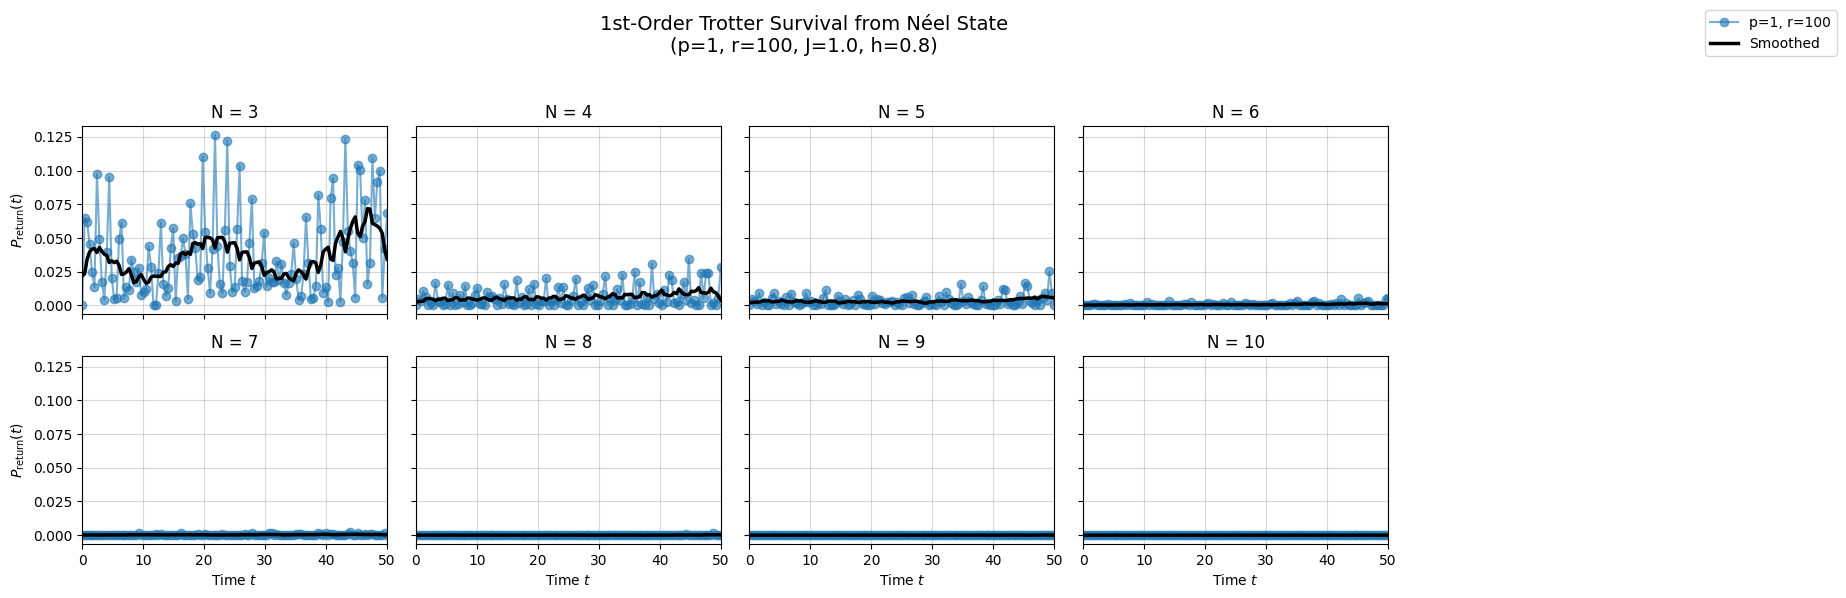

In [ ]:
J       = 1.0
h       = 0.8
r1      = 100
t_final = 50.0
times   = np.linspace(0, t_final, 125)
N_values = list(range(3, 11))

def neel_state(N):
    label = "".join(str(i%2) for i in range(N))
    return Statevector.from_label(label).data

psi0_dict = {N: neel_state(N) for N in N_values}


surv_p1 = {N: simulate_trotter_survival(N, J, h, psi0_dict[N], r1, times)
           for N in N_values}
window = 9
kernel = np.ones(window) / window

ncols = 4
nrows = int(np.ceil(len(N_values)/ncols))
fig, axes = plt.subplots(nrows, ncols,
                         figsize=(4*ncols, 3*nrows),
                         sharex=True, sharey=True)

for idx, N in enumerate(N_values):
    row, col = divmod(idx, ncols)
    ax = axes[row, col]
    raw = surv_p1[N]
    smooth = np.convolve(raw, kernel, mode='same')

    ax.plot(times, raw,
            marker='o', linestyle='-', alpha=0.6,
            label=f'p=1, r={r1}')
    ax.plot(times, smooth,
            linestyle='-', linewidth=2.5, color='black',
            label='Smoothed')

    ax.set_title(f"N = {N}", fontsize=12)
    ax.set_xlim(0, t_final)
    if row == nrows-1:
        ax.set_xlabel("Time $t$")
    if col == 0:
        ax.set_ylabel(r"$P_{\mathrm{return}}(t)$")
    ax.grid(alpha=0.5)

for ax in axes.flat[len(N_values):]:
    ax.axis('off')

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15, 1))

plt.suptitle(
    f"1st‑Order Trotter Survival from Néel State\n(p=1, r={r1}, J={J}, h={h})",
    fontsize=14
)
plt.tight_layout(rect=[0,0,0.88,0.95])
plt.show()


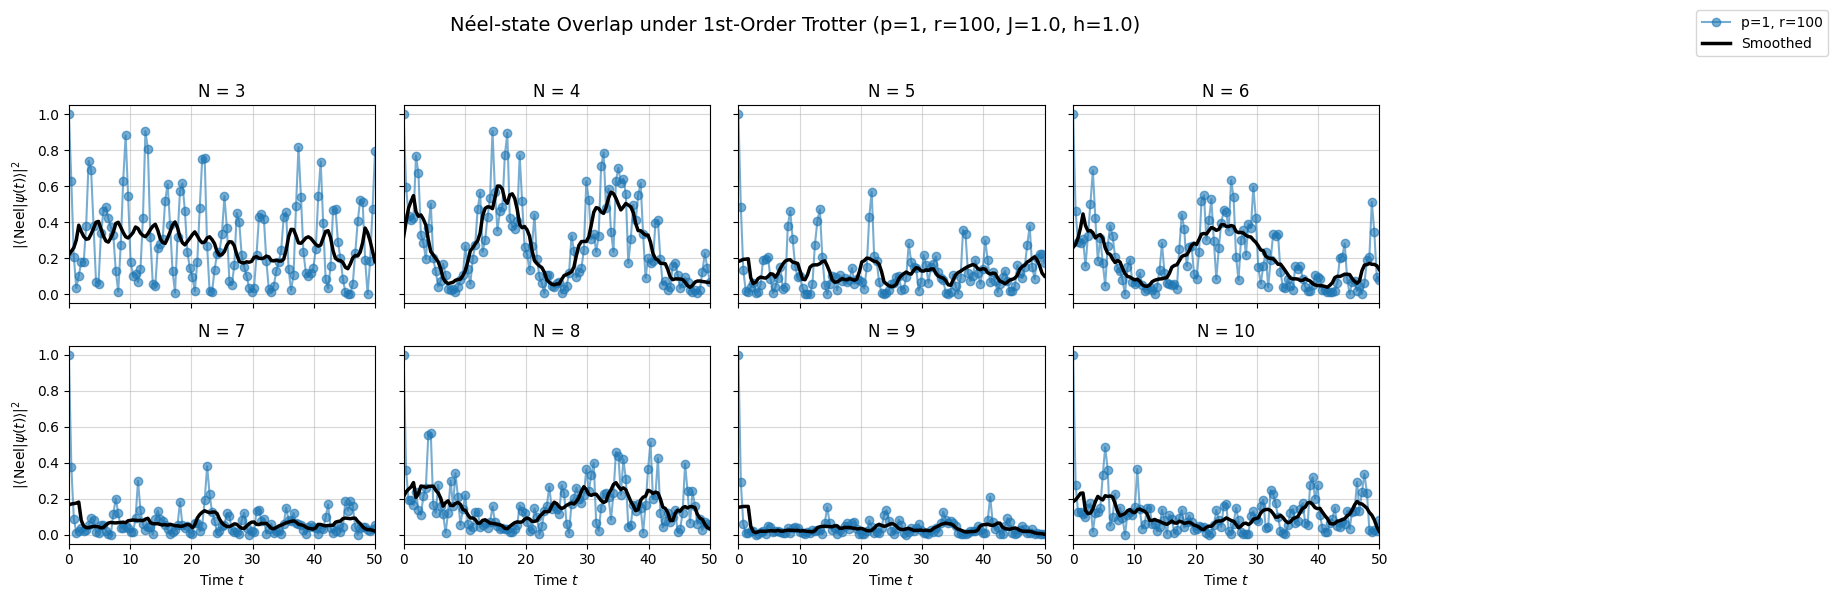

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector

def simulate_trotter_overlap(N, J, h, psi0, reps, times):
    overlap = np.zeros_like(times)
    target_index = 0
    neel_label = "".join(str(i % 2) for i in range(N))
    target_index = int(neel_label, 2)

    for idx, t in enumerate(times):
        qc = generate_trotterized_circuit(N, J, h, t, psi0, reps, trotter_order=1)
        sv = Statevector.from_instruction(qc)
        # probability to be in the Néel state
        overlap[idx] = np.abs(sv.data[target_index])**2
    return overlap

J       = 1.0
h       = 1.0
r1      = 100
t_final = 50.0
times   = np.linspace(0, t_final, 125)
N_values = list(range(3, 11))

def neel_state(N):
    label = "".join(str(i % 2) for i in range(N))
    return Statevector.from_label(label).data

psi0_dict = {N: neel_state(N) for N in N_values}

overlap_p1 = {
    N: simulate_trotter_overlap(N, J, h, psi0_dict[N], r1, times)
    for N in N_values
}

window = 9
kernel = np.ones(window) / window

ncols = 4
nrows = int(np.ceil(len(N_values)/ncols))
fig, axes = plt.subplots(nrows, ncols,
                         figsize=(4*ncols, 3*nrows),
                         sharex=True, sharey=True)

for idx, N in enumerate(N_values):
    row, col = divmod(idx, ncols)
    ax = axes[row, col]

    raw = overlap_p1[N]
    smooth = np.convolve(raw, kernel, mode='same')

    ax.plot(times, raw,
            marker='o', linestyle='-', alpha=0.6,
            label=f'p=1, r={r1}')
    ax.plot(times, smooth,
            linestyle='-', linewidth=2.5, color='black',
            label='Smoothed')

    ax.set_title(f"N = {N}", fontsize=12)
    ax.set_xlim(0, t_final)
    if row == nrows-1:
        ax.set_xlabel("Time $t$")
    if col == 0:
        ax.set_ylabel(r"$|\langle\text{Neel}|\psi(t)\rangle|^2$")
    ax.grid(alpha=0.5)

for ax in axes.flat[len(N_values):]:
    ax.axis('off')

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15, 1))

plt.suptitle(
    f"Néel‐state Overlap under 1st‑Order Trotter (p=1, r={r1}, J={J}, h={h})",
    fontsize=14
)
plt.tight_layout(rect=[0,0,0.88,0.95])
plt.show()


It looks like we picked the right state to analyze. Now the probability of measuring the all-zero state becomes very low, especially for higher $N$.
The Néel state has a very different decomposition into Bogoliubov modes compared to $|0^N\rangle$. In particular it excites a broad range of momenta $k$, including modes near the Brillouin-zone boundary. Because the Néel state overlaps strongly with high-$k$ modes (where the dispersion is steeper), we see a faster initial decay and more complex beating patterns, but the revival time will possess the same $N$-dependence we derived earlier.

However, something even more interesting happens. The probabilties of measuring the same Néel state that we used to initialize the system oscillate only for even $N$ and exhibit chaotic behaviour of odd $N$!

This is clear evidence of the frustration of the lattice! (since we are in the antiferromagnetic case  $J>0$)

For even $N$, the Jordan-Wigner mapping can be done in a single parity sector, and the Néel configuration sits in one of those sectors without frustration.  The time evolution then remains block-diagonal in a small set of $(k,-k)$ Bogoliubov modes. The period of the oscillations scales exactly as we derived.

For odd $N$, however, the antiferromagnetic pattern necessarily induces a misalignment at the boundary and one domain wall must wrap around the ring. This forces mixing between parity sectors and couples all of the momentum blocks together, destroying the periodic revivals. The periodic boundary conditions make any attempt to alternate $1$ and $0$ around the loop run into an unavoidable clash at the last bond!

For example, with $h=0$ and for $N=3$ (triangular arrangement) there are $2^3=8$ available states, $6$ of which are the ground state of the system (all but the fully polarized states). The lattice is then extremely frustrated and can't decide between any of these states, one of which is the state we used to initialize the system, so we observe a very chaotic and complex behaviour.

To study this phenomenon further it would be useful to simulate the system at its ground-level and find if there is a single state that minimizes the energy of the system or multiple degenerate cases. The latter being when we encounter geometric frustration.

## Ground State behaviour

**Quantum annealing** (QA) and adiabatic quantum computing (AQC) are paradigms in which a quantum system is evolved slowly enough to remain in its instantaneous ground state, so as to solve optimization problems (like finding the ground state of our Transvese field Ising ring).  The basic setup is as follows.

Let $H_P$ be the problem Hamiltonian whose ground state encodes the solution of an optimization problem, and $H_D$ a simple driver Hamiltonian which is easily initializeable
$$
H_D = -\sum_{i=1}^n \sigma_i^x.
$$
We then define the interpolating Hamiltonian
$$
H(s) \;=\;(1 - s)\,H_D \;+\; s\,H_P,
\qquad s = \frac{t}{T}, \quad t\in[0,T].
$$

The adiabatic theorem guarantees that if the Hamiltonian varies sufficiently slowly, a system prepared in the ground state $|E_0(0)\rangle$ of $H(0)=H_D$ will, with high probability, end up in the ground state $|E_0(1)\rangle$ of $H(1)=H_P$.  

The condition for the evolution to be considered adiabatic is:
\begin{equation*}
\max_{s\in[0,1]}\frac{\big|\langle E_1(s)|\frac{dH}{ds}|E_0(s)\rangle\big|}{\big[\Delta_{\min}\big]^2}\;\ll\;T,
\end{equation*}
where
$$
\Delta_{\min} \;=\; \min_{s\in [0,1]}\big[E_1(s)-E_0(s)\big]
$$
is the minimum spectral gap between the ground state and first excited state.

Typically we have
$$
T \;=\; \mathcal{O}\!\Biggl(\frac{\max_s\|\tfrac{dH}{ds}\|}{\Delta_{\min}^2}\Biggr)
\;\approx\; \mathcal{O}\!\bigl(\Delta_{\min}^{-2}\bigr),
$$
since $\|dH/ds\|$ is often bounded by a polynomial in the problem size $n$.  So as long as our Hamiltonian remais gapped throughout the entire homotopy and the evolution is slow enough, we can find the solution of any problem that can be encoded into our problem Hamiltonian $H_p$ (which can be mapped onto classical optimization problems of the QUBO (Quadratic Unconstrained Binary Optomization) type).

This is usually done through an Ising Hamiltonian of the form:

\begin{equation*}  
H_p = \sum_{i} h_i \sigma_i^z + \sum_{i<j} J_{ij} \sigma_i^z \sigma_j^z
\end{equation*}  

One alternative to solving these NP-complete problems classically is to use meta-heuristics like **Simulated Annealing** (SA).

In pseudocode and using the Metropolis acceptance criterion, the algorithm is as follows:

1. **Initialization**  
   - Choose an initial state $x_0$.  
   - Set initial temperature $T_0 > 0$.  
   - Define a cooling schedule $\{T_k\}_{k=0}^K$ ( like $T_k = T_0 \, \alpha^k$ with $0<\alpha< 1$).

2. **Iteration**  
   For $k = 0,1,2,\dots,K-1$:  
   1. **Generate candidate**  
      - Propose a new state $x'$ from a neighborhood of the current state $x_k$.  
   2. **Compute energy change**  
      $$
      \Delta E = E(x') - E(x_k),
      $$
      where $E(\cdot)$ is the objective (energy) function to minimize.  
   3. **Define an Acceptance Probability**  
      \begin{align*}
      P_{\text{accept}} =\begin{cases}
        1, & \Delta E \le 0,\\[6pt]
        \exp\bigl(-\tfrac{\Delta E}{T_k}\bigr), & \Delta E > 0.
      \end{cases}
      \end{align*}
   4. **Accept or reject the new state $x'$**  
      - Draw $u \sim \mathcal{U}(0,1)$.  
      - If $u < P_{\text{accept}}$, set $x_{k+1} = x'$;  
        otherwise, set $x_{k+1} = x_k$.  
   5. **Update temperature**  
      $$
      T_{k+1} = \text{cooling\_schedule}(T_k).
      $$

- After $K$ iterations, return the best state found (the minimum energy $x$ observed).

The initial state $x_0$ is simply a random configuration of spins in the Ising ring and $x'$ is obtained by randomly flipping one of the sites of the previous iteration.

As the name suggests, this method is often used as a benchmark for quantum alternatives to finding ground states in optimization problems. There is one big problem, the transverse field term of our Hamiltonian cannot be written in the $Z$ basis so we can't fully recover the physics of our frustrated lattice with jsut simulated annealing, it fails to capture quantum effects such as tunneling and superposition too.

To address this limitation for systems with transverse fields, we turn to the **path-integral quantum Monte Carlo** (PIMC) method.

Consider the quantum partition function at inverse temperature $\beta$:

$$\mathcal{Z}=\operatorname{Tr}\big(e^{-\beta H}\big).$$

By splitting imaginary time into $M$ slices of width $\Delta\tau=\beta/M$ and we can (once again) use a Suzuki-Trotter decomposition. Two common choices are the first-order decomposition $e^{-\Delta\tau H}\approx e^{-\Delta\tau H_0}e^{-\Delta\tau H_1}$ and the (2nd order) symmetric Strang splitting $e^{-\Delta\tau H}\approx e^{-\Delta\tau H_1/2}e^{-\Delta\tau H_0}e^{-\Delta\tau H_1/2}$. The latter reduces Trotter error to $O(\Delta\tau^2)$ while the former has $O(\Delta\tau)$ error.

We can then insert complete sets of $\sigma^z$ eigenstates $\{|\mathbf{s}^{(k)}\rangle\}$ between factors. With periodic boundary conditions in imaginary time ($\mathbf{s}^{(M+1)}=\mathbf{s}^{(1)}$), one obtains:

$$\mathcal{Z}
\;=\;
\lim_{M\to\infty}\sum_{\{\mathbf{s}^{(1)},\dots,\mathbf{s}^{(M)}\}}
\prod_{k=1}^M
\Big\langle \mathbf{s}^{(k)} \Big| e^{-\Delta\tau H_0} e^{-\Delta\tau H_1^{(\text{slice})}} \Big| \mathbf{s}^{(k+1)} \Big\rangle,$$

where $H_1^{(\text{slice})}$ denotes either $H_1$ or $H_1/2$ depending on the chosen splitting. Since $e^{-\Delta\tau H_0}$ is diagonal in the $\sigma^z$ basis:

$$\big\langle \mathbf{s}^{(k)} \big| e^{-\Delta\tau H_0} \big| \mathbf{s}^{(k+1)}\big\rangle
= \exp\!\Big( \Delta\tau \sum_{\langle i,j\rangle} J_{ij}\, s_{i,k} s_{j,k}\Big)\; \delta_{\mathbf{s}^{(k)},\mathbf{s}^{(k+1)}},$$

with $s_{i,k}\in\{\pm1\}$ representing the eigenvalue of $\sigma_i^z$ on slice $k$. For each single-site transverse-field factor we use the exact formula $e^{a\sigma^x} = \cosh(a)\,\mathbb{I} + \sinh(a)\,\sigma^x$. In the $\sigma^z$ basis, this becomes:

$$\langle s | e^{a\sigma^x} | s'\rangle
= \cosh(a)\,\delta_{s,s'} + \sinh(a)\,(1-\delta_{s,s'}),
\qquad s,s'=\pm1.$$

Equivalently, these $2\times2$ matrix elements can be written in an "Ising-link" form:

$$\langle s | e^{a\sigma^x} | s'\rangle
\;=\; A(a)\,\exp\big[K(a)\, s s'\big],$$
with the exact relations:

$$
\begin{aligned}
K(a) &= \tfrac{1}{2}\ln\!\big(\coth a\big),\\
A(a) &= \sqrt{\cosh a \,\sinh a}.
\end{aligned}$$

One checks that $A e^{K}=\cosh a$ and $A e^{-K}=\sinh a$. The multiplicative factor $A(a)$ contributes a constant factor ($A(a)^{\,nM}$) to $\mathcal{Z}$ and cancels in expectation values of operators (though it must be kept if absolute free energies are required). The argument $a$ equals the coefficient appearing in the single-slice factor of the chosen Trotter decomposition. For example, in First-order splitting $a=\Gamma\Delta\tau$ (from $e^{-\Delta\tau H_1}$) and Symmetric (Strang) splitting $a=\tfrac{1}{2}\Gamma\Delta\tau$ (from $e^{-\frac{\Delta\tau}{2} H_1}$). Hence, the imaginary-time coupling $K(a)$ depends explicitly on that choice.

Collecting spatial and imaginary-time factors, the partition function can be written (up to the overall multiplicative factor $A(a)^{nM}$) as a classical sum over Ising spins $s_{i,k}\in\{\pm1\}$:

$$\mathcal{Z}
\;=\; \big[A(a)\big]^{\,nM}\sum_{\{s_{i,k}\}}
\exp\Bigg(
\sum_{k=1}^M\Big[ \Delta\tau \sum_{\langle i,j\rangle} J_{ij}\, s_{i,k} s_{j,k}
\;+\; K(a)\sum_{i=1}^n s_{i,k} s_{i,k+1}\Big]\Bigg),$$

with periodic boundary conditions $s_{i,M+1}=s_{i,1}$. It is convenient to define an effective classical Hamiltonian $H_{\mathrm{eff}}$ by $\mathcal{Z} \;=\; \big[A(a)\big]^{\,nM}\sum_{\{s_{i,k}\}} e^{-H_{\mathrm{eff}}[\{s\}]}$, with:

$$H_{\mathrm{eff}}[\{s\}] \;=\; -\sum_{k=1}^M\Big[ \Delta\tau \sum_{\langle i,j\rangle} J_{ij}\, s_{i,k} s_{j,k}
+ K(a)\sum_{i=1}^n s_{i,k} s_{i,k+1}\Big].$$

Thus the quantum $d$-dimensional TFIM is mapped to a classical Ising model on a $(d+1)$-dimensional lattice with anisotropic couplings (spatial coupling $\Delta\tau J_{ij}$ and imaginary-time coupling $K(a)$). For small $a$ one frequently uses the leading asymptotic $K(a)\;=\;\tfrac12\ln\coth a \;\approx\; -\tfrac12\ln a \;+\; O(1)$. In particular, for the symmetric splitting ($a=\Gamma\Delta\tau/2$) one obtains the common approximation:

$$K\!\big(\tfrac{\Gamma\Delta\tau}{2}\big)\approx \tfrac12\ln\!\big(\tfrac{2}{\Gamma\Delta\tau}\big)
\qquad(\Gamma\Delta\tau\ll1),$$
but one should keep the exact form $K(a)=\tfrac12\ln\coth a$ whenever possible.

A straightforward PIMC implementation treats the classical system $H_{\text{eff}}$ with Monte Carlo:

1. **Initialization**   Choose $M$ and $\beta$ (hence $\Delta\tau=\beta/M$) and initialize $\{s_{i,k}\}$ randomly.

2. **Sweeps**   Perform sweeps of Monte Carlo updates (e.g., local single-spin Metropolis updates, flipping $s_{i,k}$ with acceptance probability $\min[1,\exp(-\Delta H_{\mathrm{eff}})]$).

3. **Measurement** After thermalization, measure observables and average over configurations and imaginary-time slices as appropriate.

Importantly, the standard TFIM with a transverse field $-\Gamma\sum_i\sigma_i^x$ is stoquastic in the $\sigma^z$ basis (off-diagonal matrix elements of $e^{-\Delta\tau H_1}$ are nonnegative in the decomposition above), so ordinary PIMC does not suffer from a sign problem. A sign problem arises if the off-diagonal matrix elements in the chosen computational basis acquire nontrivial phases (e.g. sign-changing or complex).

To approach the ground state one should take large $\beta$ and, if performing quantum annealing classically, reduce $\Gamma$ according to a chosen schedule while ensuring sufficient equilibration at each step.

A naive local-update sweep scales as $\mathcal{O}(nM)$ operations, but actual wall-clock cost depends strongly on the update method, required equilibration, and autocorrelation times.

We will be implementing this algorithm as a means of comparing our quantum circuit based approach that is introduced next.

## The Quantum Approximate Optimization Algorithm (QAOA)

The **Quantum Approximate Optimization Algorithm** (QAOA) is a variational hybrid-quantum/classical scheme designed to approximate ground states of combinatorial or spin models like the transverse field Ising ring.  It combines elements of both trotterization and annealing in a fixed depth circuit:

Firstly we define a “cost” Hamiltonian $H_C$ that encodes the solution of our problem. For the transverse-field Ising ring this will be,
   $$
     H_C \;=\; J \sum_{j=1}^{N} Z_j Z_{j+1}
     \quad(\text{with }j+N\equiv j).
   $$

Then we pick a simple, non-commuting Hamiltonian $H_M$ which is analogous to the Driver Hamiltonian in the Quantum Annealing protocol. We will set it as the transverse field term:
   $$
     H_M \;=\; h\sum_{j=1}^N X_j.
   $$

The ground state of this Hamiltonian is the $\bigl|+\bigr\rangle^{\otimes N}$ state which we can and will initialize by applying Hadamard gates to all qubits.

Subsequently we alternate between evolving under $H_C$ and $H_M$ for tunable times (which become parameters/angles) $\boldsymbol\gamma=(\gamma_1,\dots,\gamma_p)$ and $\boldsymbol\beta=(\beta_1,\dots,\beta_p)$ in the following way:
   $$
     \bigl|\psi(\boldsymbol\gamma,\boldsymbol\beta)\bigr\rangle
     = \prod_{k=1}^{p}
       \Bigl( e^{-i\beta_k H_M}\,e^{-i\gamma_k H_C}\Bigr)\;
       \bigl|+\bigr\rangle^{\otimes N}.
   $$

We repeat each layer of $H_C$ and $H_M$ much like we did when we implemented the time evolution using Trotterization before.

Finally we run the classical optimization loop:
   - Prepare $\lvert\psi(\boldsymbol\gamma,\boldsymbol\beta)\rangle$ on the quantum processor.  
   - Measure the expectation value
     $$
       C(\boldsymbol\gamma,\boldsymbol\beta)
       = \bigl\langle \psi(\boldsymbol\gamma,\boldsymbol\beta)\bigr| H \bigl|\psi(\boldsymbol\gamma,\boldsymbol\beta)\bigr\rangle.
     $$
   - Use a classical optimizer to adjust $\boldsymbol\gamma,\boldsymbol\beta$ so as to minimize $C$.

At the optimal $(\boldsymbol\gamma^*,\boldsymbol\beta^*)$, the final state $\lvert\psi^*\rangle$ approximates the true ground state of $H_C$.  

Increasing the circuit depth $p$ generally improves the approximation, converging to quantum annealing in the $p\to\infty$ limit (with a suitable parameter schedule).

We can choose the cost Hamiltonian with only the $H_{ZZ}$ term since when we take the expectation value of the circuit we get:
$$
\langle H\rangle =\langle H_C\rangle+\langle H_M\rangle,
$$
so we feed that full expectation back into your classical optimizer. Consequently the transverse field term $H_X$ still influences the choice of $\{\gamma_k,\beta_k\}$.

For our classical optimization routine we will use COBYLA (Constrained Optimization by Linear Approximation) which is a derivative-free optimization algorithm often used in the classical optimization loop of QAOA. It iteratively builds linear approximations of the cost function within a trust region and handles inequality constraints directly, making it a reliable choice for optimizing QAOA parameters in small to medium scale quantum optimization problems.

## Why QAOA?

- Unlike full adiabatic evolution, QAOA uses a finite number of alternating evolutions, making it friendly to NISQ term devices.
- The angles $\{\gamma_k,\beta_k\}$ adapt to hardware noise and limited coherence (a perk of variational algorithms).
- Each layer is akin to one trotter step of a discretized annealing schedule, but the parameters are learned rather than predetermined.
- In the worst case scenario, the time to solution can scale as $\mathcal{O}(\exp(p))$ due to barren plateaus or non-convex landscapes. However, for structured problems (like our transverse field Ising ring) it only takes $\mathcal{O}(\text{poly}(p))$.

This was a long detour, though a necessary one to fully understand why we can apply these approaches, especially since they are all closely related (we witnessed the marriaged between many ideas from Trotterization and Quantum Annealing).

In the following code cells, we will implement the QAOA ansatz for the $N$-spin transverse-field Ising ring, evaluate the cost function via expectation values, and employ a classical optimizer to find $\{\gamma_k,\beta_k\}$.  


**References**

All of the following references were used for studying these approaches, they go more in depth than I ever could here:

- Suzuki, M. (1976). Relationship between d-Dimensional Quantal Spin Systems and (d+1)-Dimensional Ising Systems.  

- Kadowaki, T., & Nishimori, H. (1998). Quantum Annealing in the Transverse Ising Model.  

- Santoro, G. E., & Tosatti, E. (2006). Optimization using quantum mechanics: quantum annealing through adiabatic evolution.  

- Sandvik, A. W. (2010). Computational Studies of Quantum Spin Systems.  

- Troyer, M., & Wiese, U.-J. (2005). Computational Complexity and Fundamental Limitations to Fermionic Quantum Monte Carlo Simulations.  

- Binder, K., & Heermann, D. W. (2019). Monte Carlo Simulation in Statistical Physics (5th ed.).

- Andrew D. King , et al. (2021). Scaling advantage over path-integral Monte Carlo in quantum simulation of geometrically frustrated magnets.

- P. Díez-Valle, F. J. Gómez-Ruiz, D. Porras & J. J. García-Ripoll. Universal Resources for QAOA and Quantum Annealing.

- Farhi, Goldstone, Gutmann (2014). A Quantum Approximate Optimization Algorithm.

- Zhou et al. (2020). Quantum Approximate Optimization Algorithm: Performance, Mechanism, and Implementation on Near‑Term Devices.

- The Qiskit and D-Wave documentations.

Total depth: 27
Depth per layer: 13.0

QAOA circuit for N=4 spins with 2 layers:


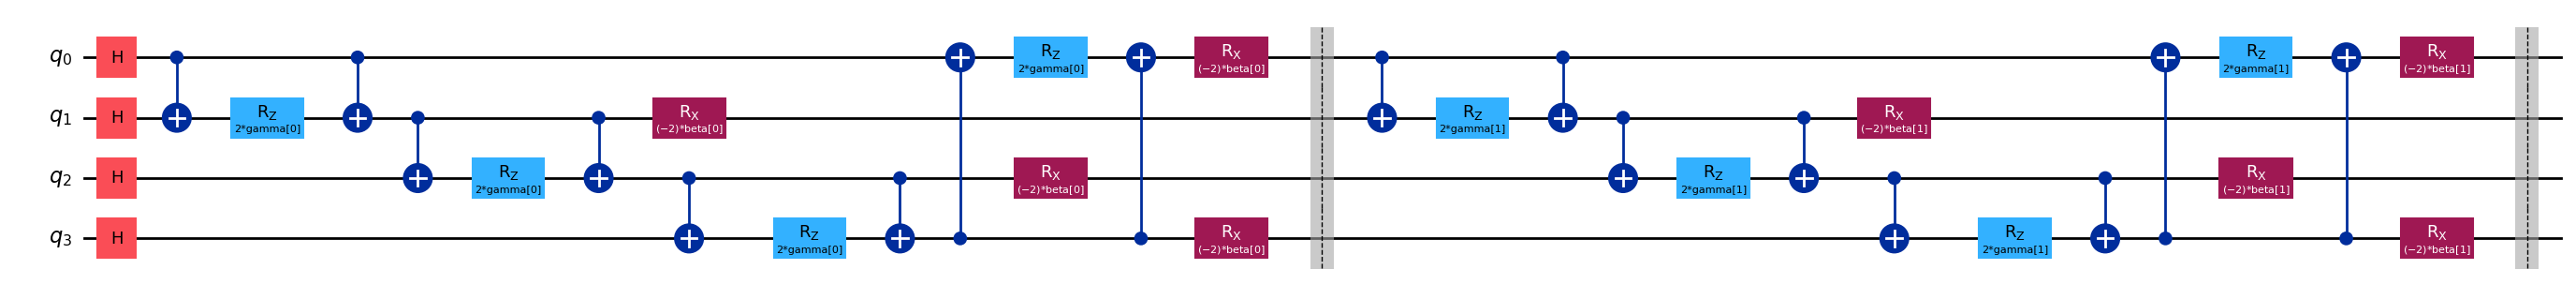

In [ ]:
from qiskit import ClassicalRegister, QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.primitives import StatevectorSampler, StatevectorEstimator
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit.quantum_info import SparsePauliOp, Statevector
import numpy as np
from scipy.optimize import minimize

def create_qaoa_ising_ring(n_qubits, J, h, p):
    gamma = ParameterVector('gamma', p)
    beta = ParameterVector('beta', p)
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))  # initial |+> state

    for layer in range(p):
        for i in range(n_qubits):
            j = (i + 1) % n_qubits
            qc.cx(i, j)
            qc.rz(2 * J * gamma[layer], j)
            qc.cx(i, j)
        qc.rx(2 * h * beta[layer], range(n_qubits))
        qc.barrier()
    return qc, gamma, beta

def build_hamiltonian(n_qubits, J, h):
    paulis = []
    coeffs = []

    for i in range(n_qubits):
        j = (i + 1) % n_qubits
        zz = ['I']*n_qubits
        zz[i], zz[j] = 'Z', 'Z'
        paulis.append(''.join(zz))
        coeffs.append(J)

    for i in range(n_qubits):
        x = ['I']*n_qubits
        x[i] = 'X'
        paulis.append(''.join(x))
        coeffs.append(h)

    return SparsePauliOp(paulis, coeffs=coeffs)

def qaoa_expectation(params, qc, gamma, beta, pauli_op, estimator):
    bind_map = {**{gamma[i]: params[i] for i in range(len(gamma))},
                **{beta[i]:  params[len(gamma)+i] for i in range(len(beta))}}

    pub = (qc, pauli_op, bind_map)

    job = estimator.run([pub])
    result = job.result()[0].data.evs

    return result

def optimize_qaoa(n_qubits, J, h, p, initial=None):
    qc, gamma, beta = create_qaoa_ising_ring(n_qubits, J, h, p)
    pauli_op = build_hamiltonian(n_qubits, J, h)
    estimator = StatevectorEstimator()

    num_params = 2*p
    init = initial if initial is not None else np.random.uniform(0, np.pi, size=num_params)

    res = minimize(lambda x: qaoa_expectation(x, qc, gamma, beta, pauli_op, estimator),
                   init, method='COBYLA')
    return res.x, res.fun

def get_ground_state_distribution(params, qc, gamma, beta):
    bind_map = {
        **{gamma[i]: params[i] for i in range(len(gamma))},
        **{beta[i]:  params[len(gamma) + i] for i in range(len(beta))}
    }

    bound_qc = qc.assign_parameters(bind_map).copy()

    sv = Statevector.from_instruction(bound_qc)

    probs = sv.probabilities_dict()

    states = sorted(probs.keys())
    values = [probs[state] for state in states]

    fig, ax = plt.subplots()
    ax.bar(states, values)
    ax.set_xlabel('Basis State')
    ax.set_ylabel('Probability')
    ax.set_title('Ground State Distribution')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    return fig

def get_ground_state_probs(params, qc, gamma, beta, return_probs=False):
    bind_map = {
        **{gamma[i]: params[i] for i in range(len(gamma))},
        **{beta[i]:  params[len(gamma)+i] for i in range(len(beta))}
    }
    bound_qc = qc.assign_parameters(bind_map).copy()
    sv = Statevector.from_instruction(bound_qc)
    probs = sv.probabilities_dict()
    return probs

n_qubits, J, h, p = 4, 1.0, -1.0, 2

qaoa, gamma, beta = create_qaoa_ising_ring(n_qubits, J, h, p)

print(f"Total depth: {qaoa.depth()}")
print(f"Depth per layer: {(qaoa.depth()-1)/p}")
header = f"QAOA circuit for N={n_qubits} spins with {p} layers:"
print(f"\n{header}")

qaoa.draw('mpl', fold=-1)

If we remember the decomposition of the $R_{ZZ}$ gate, then we can immediately tell that the QAOA circuit we created is exactly like the 1st order Trotter circuit we drew at the beggining! However, there are two key differences: The initial layers of $H^{\otimes N}$ and the fact that the rotations are now parameterized instead of depending on some evolution time.

Qiskit can also produce QAOA circuits automaticly from the mixer and cost Hamiltonians, let's compare it to our homemade version:

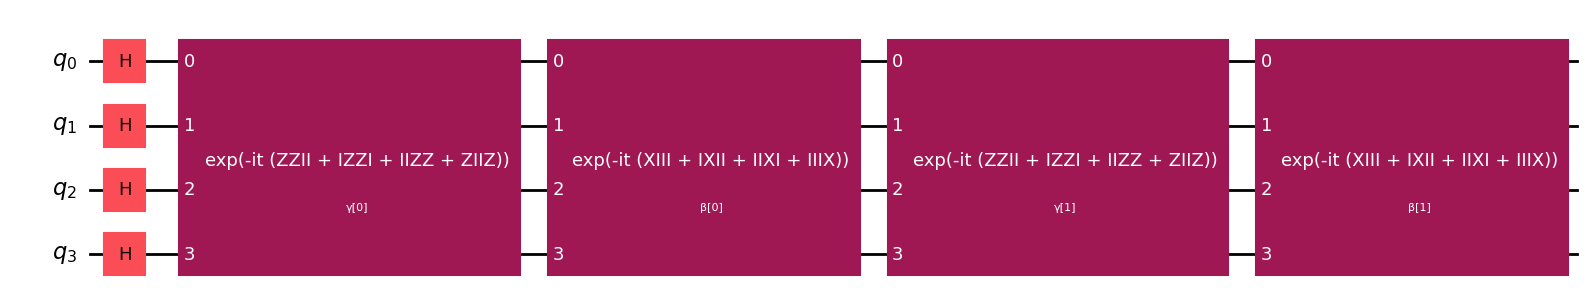

In [ ]:
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector

def make_qaoa_ising_ring_ansatz(n_qubits, J, h, p):
    cost_paulis = []
    cost_coeffs = []
    for i in range(n_qubits):
        j = (i + 1) % n_qubits
        pauli_label = ['I'] * n_qubits
        pauli_label[i] = 'Z'
        pauli_label[j] = 'Z'
        cost_paulis.append(''.join(pauli_label))
        cost_coeffs.append(J)
    cost_op = SparsePauliOp(cost_paulis, coeffs=cost_coeffs)

    mixer_paulis = []
    mixer_coeffs = []
    for i in range(n_qubits):
        pauli_label = ['I'] * n_qubits
        pauli_label[i] = 'X'
        mixer_paulis.append(''.join(pauli_label))
        mixer_coeffs.append(h)
    mixer_op = SparsePauliOp(mixer_paulis, coeffs=mixer_coeffs)

    ansatz = QAOAAnsatz(
        cost_operator=cost_op,
        reps=p,
        mixer_operator=mixer_op,
        name='QAOA_Ising_Ring'
    )
    return ansatz

n_qubits = 4
J = 1.0
h = -1.0
p = 2

qaoa_qiskit = make_qaoa_ising_ring_ansatz(n_qubits, J, h, p)

qaoa_qiskit.decompose().draw(output='mpl')

Decomposing yet again:

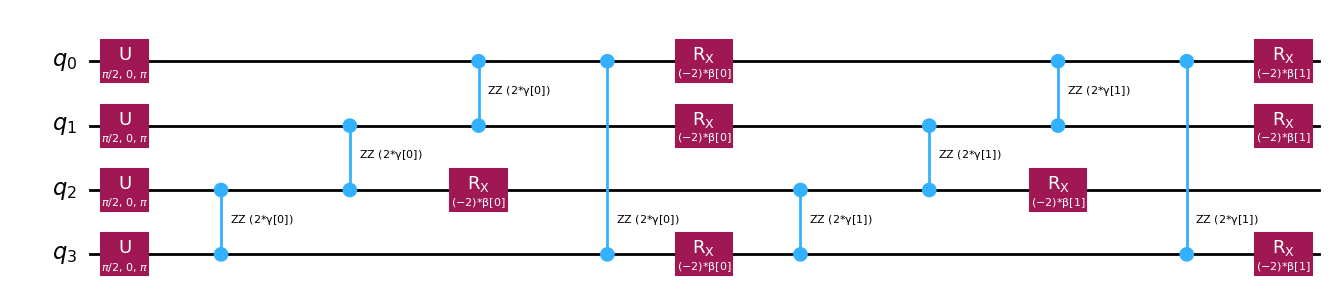

In [ ]:
qaoa_qiskit.decompose().decompose().draw(output='mpl')

The circuits are completely equivalent as we expected. Let's now study the convergence of our implementation:

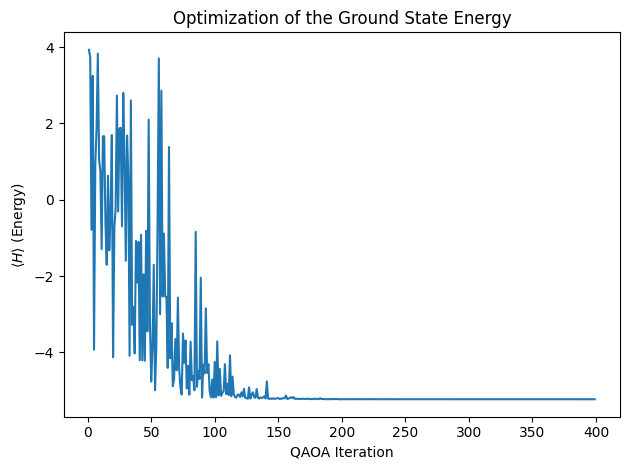

In [ ]:
def optimize_qaoa_with_history(n_qubits, J, h, p, initial=None):
    qc, gamma, beta = create_qaoa_ising_ring(n_qubits, J, h, p)
    pauli_op       = build_hamiltonian(n_qubits, J, h)
    estimator      = StatevectorEstimator()

    num_params = 2 * p
    init = initial if initial is not None else np.random.uniform(0, np.pi, size=num_params)

    energy_history = []
    params_history = []

    def record(xk):
        E = qaoa_expectation(xk, qc, gamma, beta, pauli_op, estimator)
        energy_history.append(E)
        params_history.append(np.copy(xk))

    res = minimize(
        lambda x: qaoa_expectation(x, qc, gamma, beta, pauli_op, estimator),
        init,
        method='COBYLA',
        callback=record
    )

    return res.x, res.fun, energy_history, params_history


n_qubits, J, h, p = 4, 1.0, -1.0, 15

opt_params, final_E, hist_E, hist_params = optimize_qaoa_with_history(n_qubits, J, h, p)

plt.figure()
plt.plot(range(1, len(hist_E)+1), hist_E)
plt.xlabel('QAOA Iteration')
plt.ylabel('$\\langle H\\rangle$ (Energy)')
plt.title('Optimization of the Ground State Energy')
plt.tight_layout()
plt.show()


We can clearly see that the algorithm converges to some value and how the system loses energy. To see if this is truly the global minimum configuration (and not just some local one) we may plot the "entire" (at least one period) energy landscape in function of the parameters $E(\gamma_k,\beta_k)$. Since this is a highly dimension space ($d=2p+1$), let's just plot the 2D and 3D slices for the parameters of the first layer $E(\gamma_0,\beta_0)$

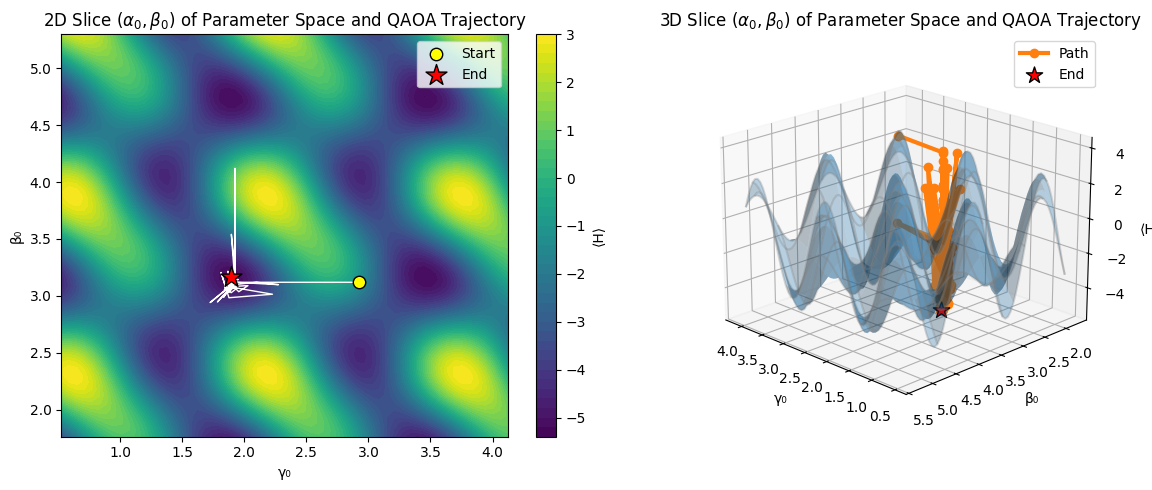

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

hist_params = np.array(hist_params)
γ_vals = hist_params[:, 0]
β_vals = hist_params[:, p]
other_fixed = opt_params.copy()

buff = 1.0
g_min, g_max = γ_vals.min(), γ_vals.max()
b_min, b_max = β_vals.min(), β_vals.max()

gammas = np.linspace(g_min - buff*(g_max-g_min),
                     g_max + buff*(g_max-g_min), 60)
betas  = np.linspace(b_min - buff*(b_max-b_min),
                     b_max + buff*(b_max-b_min), 60)

qc1, γ1, β1 = create_qaoa_ising_ring(n_qubits, J, h, p)
H_op = build_hamiltonian(n_qubits, J, h)
est  = StatevectorEstimator()

Z = np.zeros((len(betas), len(gammas)))
for i, g in enumerate(gammas):
    for j, b in enumerate(betas):
        params = other_fixed.copy()
        params[0]   = g              # gamma_0
        params[p]   = b              # beta_0
        Z[j, i] = qaoa_expectation(params, qc1, γ1, β1, H_op, est)


fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1, 2, 1)
G, B = np.meshgrid(gammas, betas)
cs = ax1.contourf(G, B, Z, levels=40)
fig.colorbar(cs, ax=ax1, label='⟨H⟩')
ax1.plot(γ_vals, β_vals, color='white', lw=1, zorder=1)
ax1.scatter(γ_vals[0], β_vals[0],
            marker='o', s=80, c='yellow', edgecolors='k', label='Start', zorder=3)
ax1.scatter(γ_vals[-1], β_vals[-1],
            marker='*', s=250, c='red', edgecolors='k', label='End', zorder=4)
ax1.set_xlabel('γ₀'); ax1.set_ylabel('β₀')
ax1.set_title('2D Slice ($\\alpha_0,\\beta_0$) of Parameter Space and QAOA Trajectory')
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(G, B, Z, rstride=4, cstride=4, alpha=0.3)
ax2.plot_wireframe(G, B, Z, rstride=8, cstride=8, color='gray', alpha=0.3)
ax2.plot(γ_vals, β_vals, hist_E,
         marker='o', markersize=6, linewidth=3, label='Path', zorder=2)
ax2.scatter(γ_vals[-1], β_vals[-1], hist_E[-1],
            marker='*', s=150, c='red', edgecolors='k', label='End', zorder=3)
ax2.set_xlabel('γ₀'); ax2.set_ylabel('β₀'); ax2.set_zlabel('⟨H⟩')
ax2.set_title('3D Slice ($\\alpha_0,\\beta_0$) of Parameter Space and QAOA Trajectory')
ax2.view_init(elev=20, azim=135)

ax2.legend()
plt.tight_layout()
plt.show()


The final state is visibly the lowest possible energy in this case. This visualization is only possible for small lattice sizes obviously, so in reality we have no guarentee that our model converges to the right minimum. The energy landscape can have flat areas that make it hard for the optimizer to find the right direction to follow. This problem of variational quantum circuits (and quantum machine learning) is known as Barren Plateaus and poses a great challenge to these methods. While it is still an open problem there are many ways of increasing our chances of escaping local minima, one example is to simply consider multiple QAOA runs starting from different initial parameters and then embrace the run that achieves the lowest energy out of all of the tries.

We can interpret the role the parameterized rotations in multiple ways.

In a way, by fine-tuning the parameters $\{\gamma_k,\beta_k\}$ we are just finding the time (throughout an evolution/path that, hopefully, passes through all key areas of the solution space) at which the lattice achieves its lowest energy.

A somewhat far-fetched interpretation is that when we update the parameters in the optimization loop, we are doing something very similar to coupling our system to the outside world which takes away some energy at each iteration. It is also possible to make the system lose energy by actually linking it to another system with well defined minima, although that would require extra ancilla qubits which this method avoids.

We are now ready to study the ground state behaviour of our system, focusing on the antiferromagnetic case:

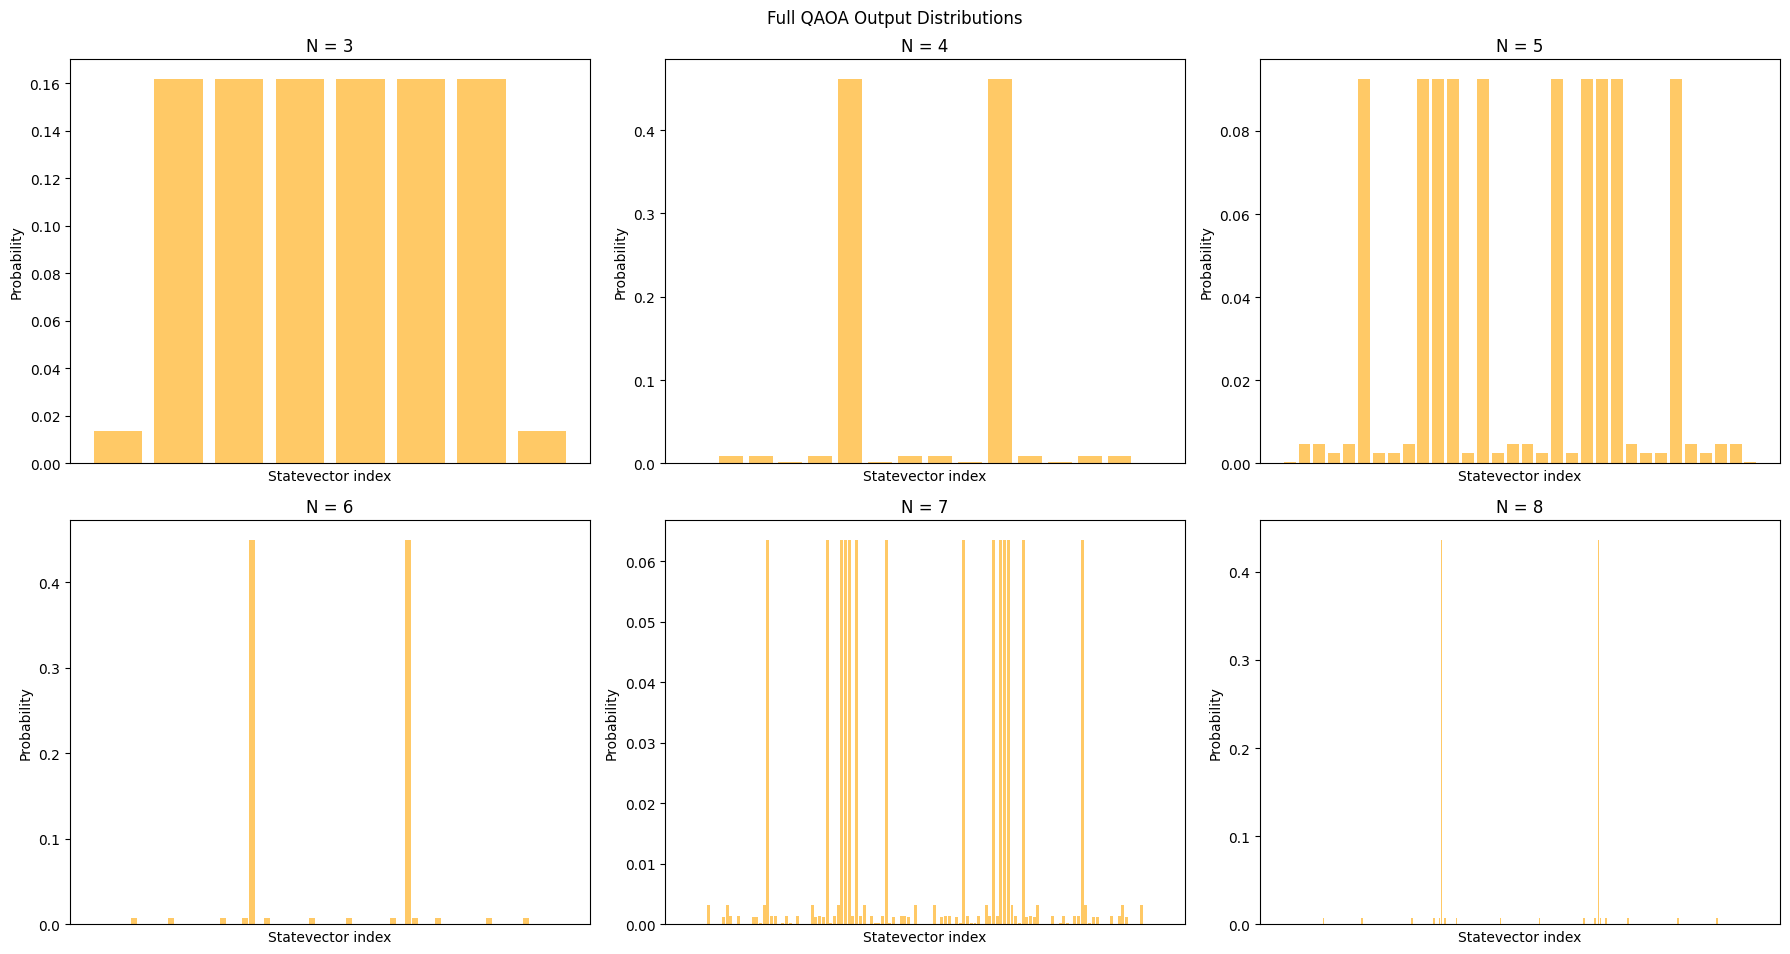

In [ ]:
N_range = range(3, 9)

n_qubits, J, h, p = 4, 1.0, -0.5, 15

all_probs = {}
gs_probs = {}
for N in N_range:
    qc, gamma, beta = create_qaoa_ising_ring(N, J, h, p)
    best_params, _ = optimize_qaoa(N, J, h, p)
    probs = get_ground_state_probs(best_params, qc, gamma, beta)
    all_probs[N] = probs

    sorted_states = sorted(probs.items(), key=lambda x: x[1], reverse=True)
    num_gs = 2 if N % 2 == 0 else 2 * N
    gs_probs[N] = dict(sorted_states[:num_gs])

fig1, axes1 = plt.subplots(2, 3, figsize=(18, 10))
for ax, N in zip(axes1.flatten(), N_range):
    probs = all_probs[N]
    indices = list(range(len(probs)))
    values = [probs[f"{i:0{N}b}"] for i in indices]
    ax.bar(indices, values, color='orange', alpha=0.6)
    ax.set_title(f"N = {N}")
    ax.set_xticks([])
    ax.set_xlabel("Statevector index")
    ax.set_ylabel("Probability")
fig1.suptitle("Full QAOA Output Distributions")
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()


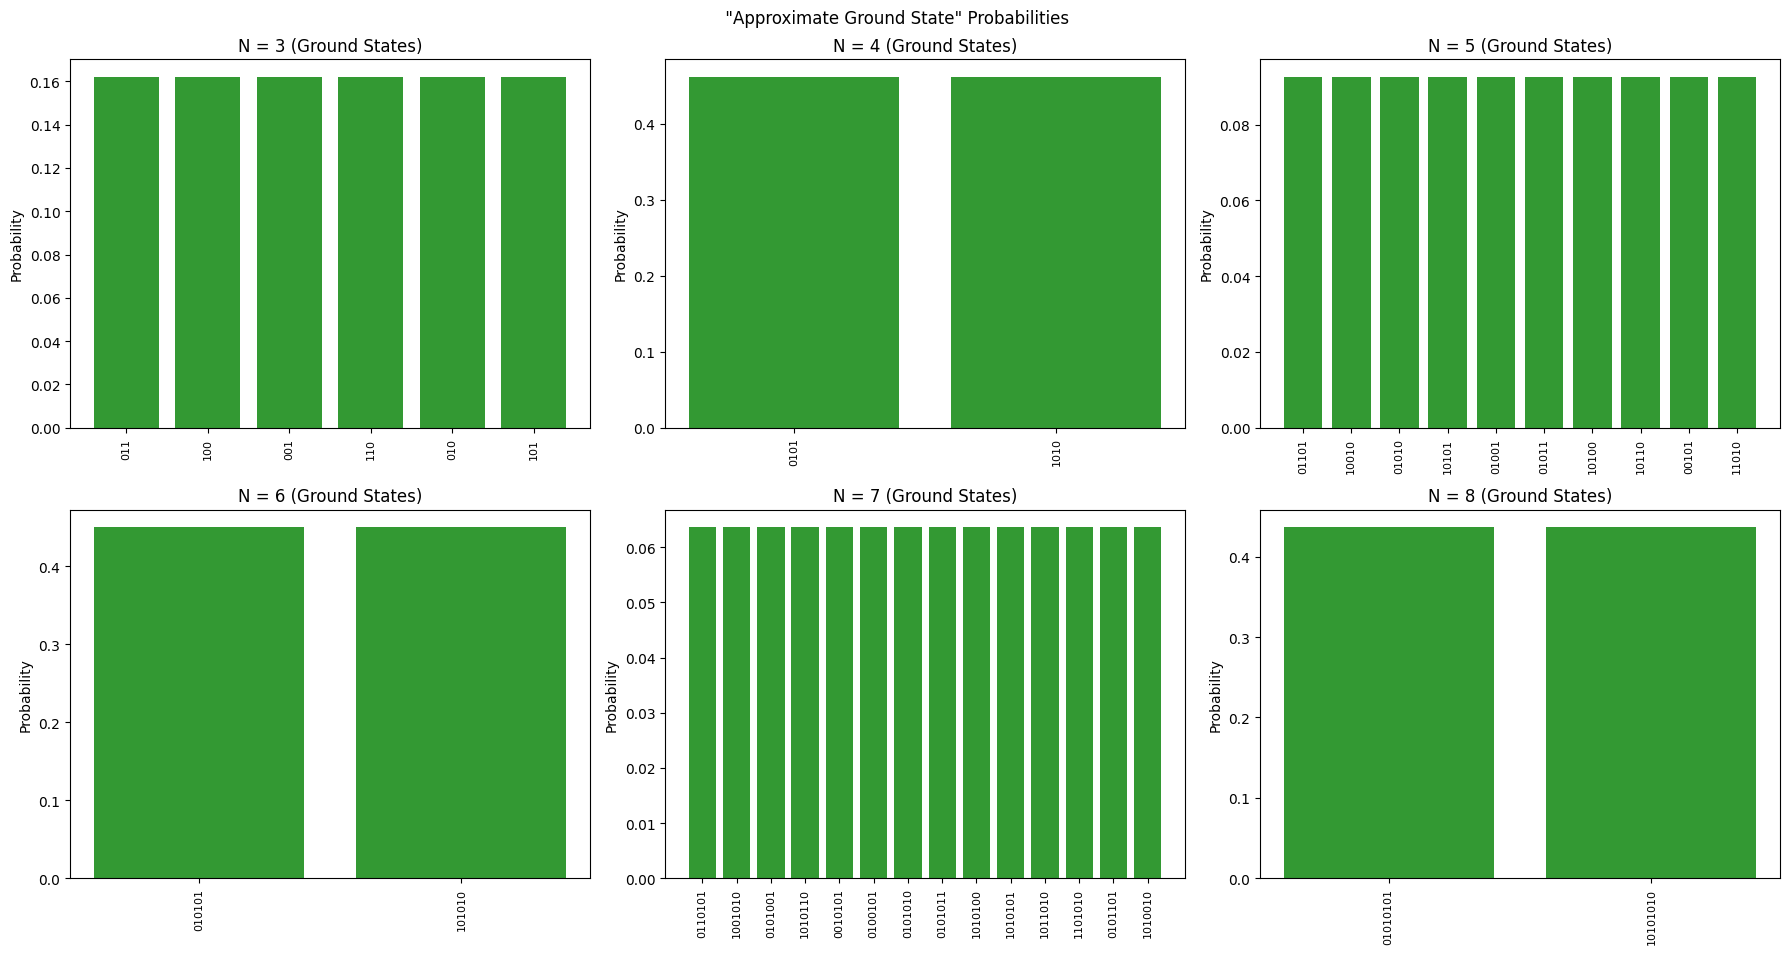

In [ ]:
fig2, axes2 = plt.subplots(2, 3, figsize=(18, 10))
for ax, N in zip(axes2.flatten(), N_range):
    subset = gs_probs[N]
    labels = list(subset.keys())
    vals   = list(subset.values())
    ax.bar(range(len(labels)), vals, color='green', alpha=0.8)
    ax.set_title(f"N = {N} (Ground States)")
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=90, fontsize=8)
    ax.set_ylabel("Probability")

fig2.suptitle(' "Approximate Ground State" Probabilities')
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

We can immediately tell the ground states from the final distributions of our QAOA implementation.

For even $N$, the final state is a clear superposition of the two classical Néel States (which are topologically equivalent)!

For odd $N$, the final state is a superposition of many more states, since as we mentioned, the lattice is heavily frustrated! Particularly for $N=3$, we recover our $6$-fold degeneracy, which when analysing the plots for higher $N$ turns out to be a $2N$-fold degeneracy.

However, we have yet to confirm if these are the correct output states. Let's employ the Path Integral Quantum Monte Carlo we described earlier to confirm our results. Since this is beyond the scope of what we truly want to analyse in this notebook, instead of implementing it from scratch we instead use D-Waves already optimized PIMC sampler: [D-wave Documentation](https://docs.dwavequantum.com/en/latest/ocean/api_ref_samplers/index.html#simulated-quantum-annealing).

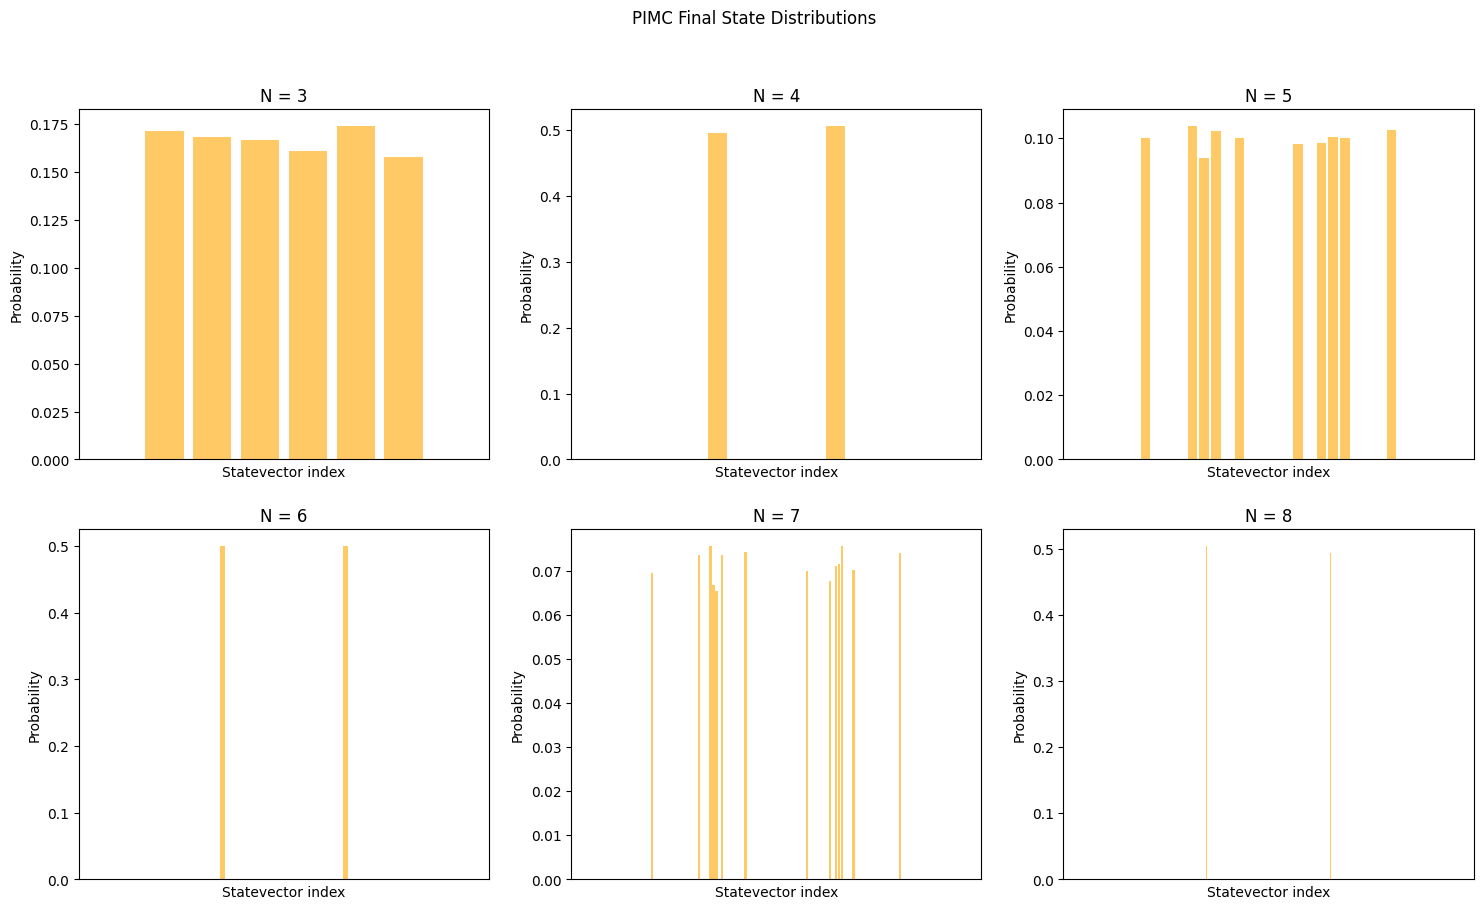

In [ ]:
from dwave.samplers import PathIntegralAnnealingSampler

J = 1.0
h = -0.5
N_range = range(3,11)
num_reads = 10000
trotter_slices = 25    # number of imaginary-time slices
beta_range = [0.1, 5.0]

sqs = PathIntegralAnnealingSampler()

all_dists = {}
top_dists = {}

for N in N_range:
    h_ising = {i: 0.0 for i in range(N)}
    J_ising = {(i, (i+1)%N): J for i in range(N)}

    sampleset = sqs.sample_ising(
        h_ising,
        J_ising,
        beta_range=beta_range,
        num_reads=num_reads
    )

    raw = sampleset.record.sample

    bitstrs = [
        ''.join('1' if spin>0 else '0' for spin in row)
        for row in raw
    ]
    unique, counts = np.unique(bitstrs, return_counts=True)
    probs = dict(zip(unique, counts / counts.sum()))
    all_dists[N] = probs

    k = 2 if N % 2 == 0 else 2 * N
    sorted_items = sorted(probs.items(), key=lambda x: x[1], reverse=True)
    top_dists[N] = dict(sorted_items[:k])

fig1, axes1 = plt.subplots(2, 3, figsize=(18, 10))
fig1.suptitle("PIMC Final State Distributions")
for ax, N in zip(axes1.flatten(), N_range):
    dist = all_dists[N]
    M = 2**N
    indices = np.arange(M)
    vals = [dist.get(f"{i:0{N}b}", 0) for i in indices]

    ax.bar(indices, vals, color='orange', alpha=0.6)
    ax.set_title(f"N = {N}")
    ax.set_xlabel("Statevector index")
    ax.set_ylabel("Probability")
    ax.set_xticks([])

<Figure size 640x480 with 0 Axes>

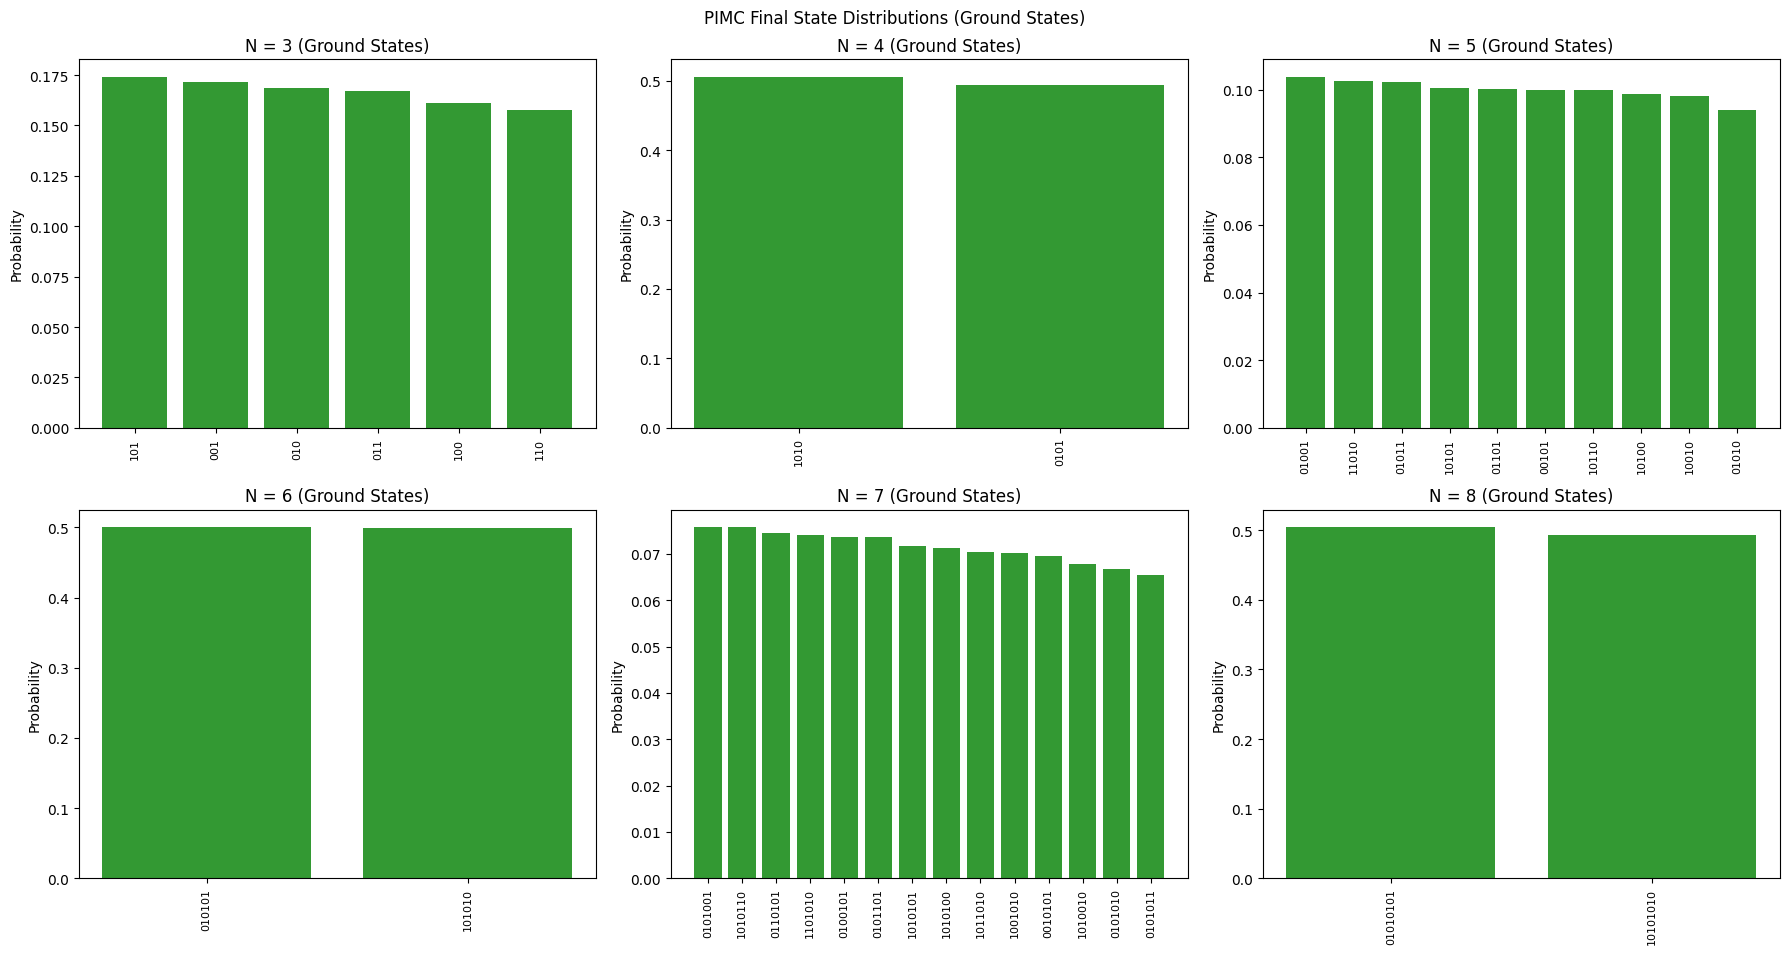

In [ ]:
fig1.suptitle("PIMC Final State Distributions")
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

fig2, axes2 = plt.subplots(2, 3, figsize=(18, 10))
for ax, N in zip(axes2.flatten(), N_range):
    td = top_dists[N]
    labels = list(td.keys())
    vals   = list(td.values())

    ax.bar(range(len(labels)), vals, color='green', alpha=0.8)
    ax.set_title(f"N = {N} (Ground States)")
    ax.set_ylabel("Probability")
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=90, fontsize=8)

fig2.suptitle("PIMC Final State Distributions (Ground States)")
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()


We obtain the exact same results!

To measure and quantify the frustration we note that a bond $(i,i+1)$ is frustrated if the spins align $(\text{sgn}(\sigma_i\sigma_{i+1})=+1$) despite the antiferromagnetic coupling.  We define the average frustration fraction as
$$
F(N)
\;=\;
\frac{1}{N}
\sum_{s\in\{0,1\}^N}
\bigl|\{\;i:\;\text{sgn}(\sigma_i\sigma_{i+1}=+1)\}\bigr|
\;\Pr[s]\,,
$$
where $\Pr[s_1s_2\cdots s_N]$ is the probabily of that statevector obtained by the QAOA.
Equivalently, $F(N)$ is the expected number of “broken” bonds divided by $N$ which is similar to evaluating the correlation function $\langle \sigma_i^z\sigma_{i+1}^z\rangle$.

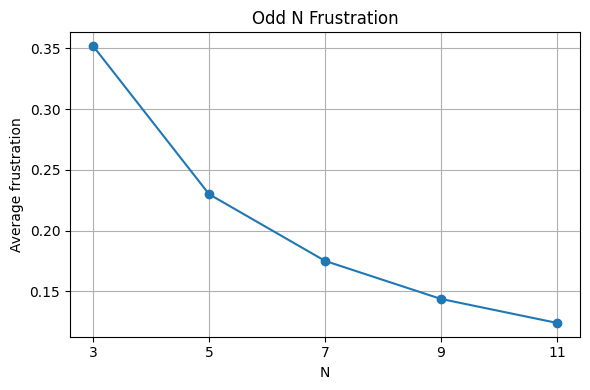

In [ ]:
N_range = range(3,9)

def compute_frustration(probs, N):
    total = 0.0
    for bitstr, p in probs.items():
        spins = np.array([1 if b=='0' else -1 for b in bitstr])
        frust = sum(1 for i in range(N) if spins[i]*spins[(i+1)%N] == 1)
        total += frust * p
    return total / N

odd_old = [3, 5, 7]

odd_new = [9, 11]

for N in odd_new:
    qc, gamma, beta = create_qaoa_ising_ring(N, J, h, p)
    best_params, _ = optimize_qaoa(N, J, h, p)
    all_probs[N] = get_ground_state_probs(best_params, qc, gamma, beta)

odd_combined = odd_old + odd_new
frust_values = []
for N in odd_combined:
    F = compute_frustration(all_probs[N], N)
    frust_values.append(F)

plt.figure(figsize=(6,4))
plt.plot(odd_combined, frust_values, marker='o')
plt.xlabel("N")
plt.ylabel("Average frustration")
plt.title(f"Odd N Frustration")
plt.xticks(odd_combined)
plt.grid(True)
plt.tight_layout()
plt.show()


Since the central region of the ring effectively behaves like an infinite chain and has low bond errors, only the small region where the periodic wrap-around occurs contributes most of the frustration.  

As $N$ grows, that wrap-around region becomes a vanishing fraction of the system, hence the observed exponential suppression. So the triangular lattice (N=3 ring) is the most frustrated our system can get.

So at fixed $p$, QAOA is increasingly effective at suppressing antiferromagnetic bond errors in larger odd-sized rings.

Let's see if we can get the correct results for the ferromagnetic case aswell:

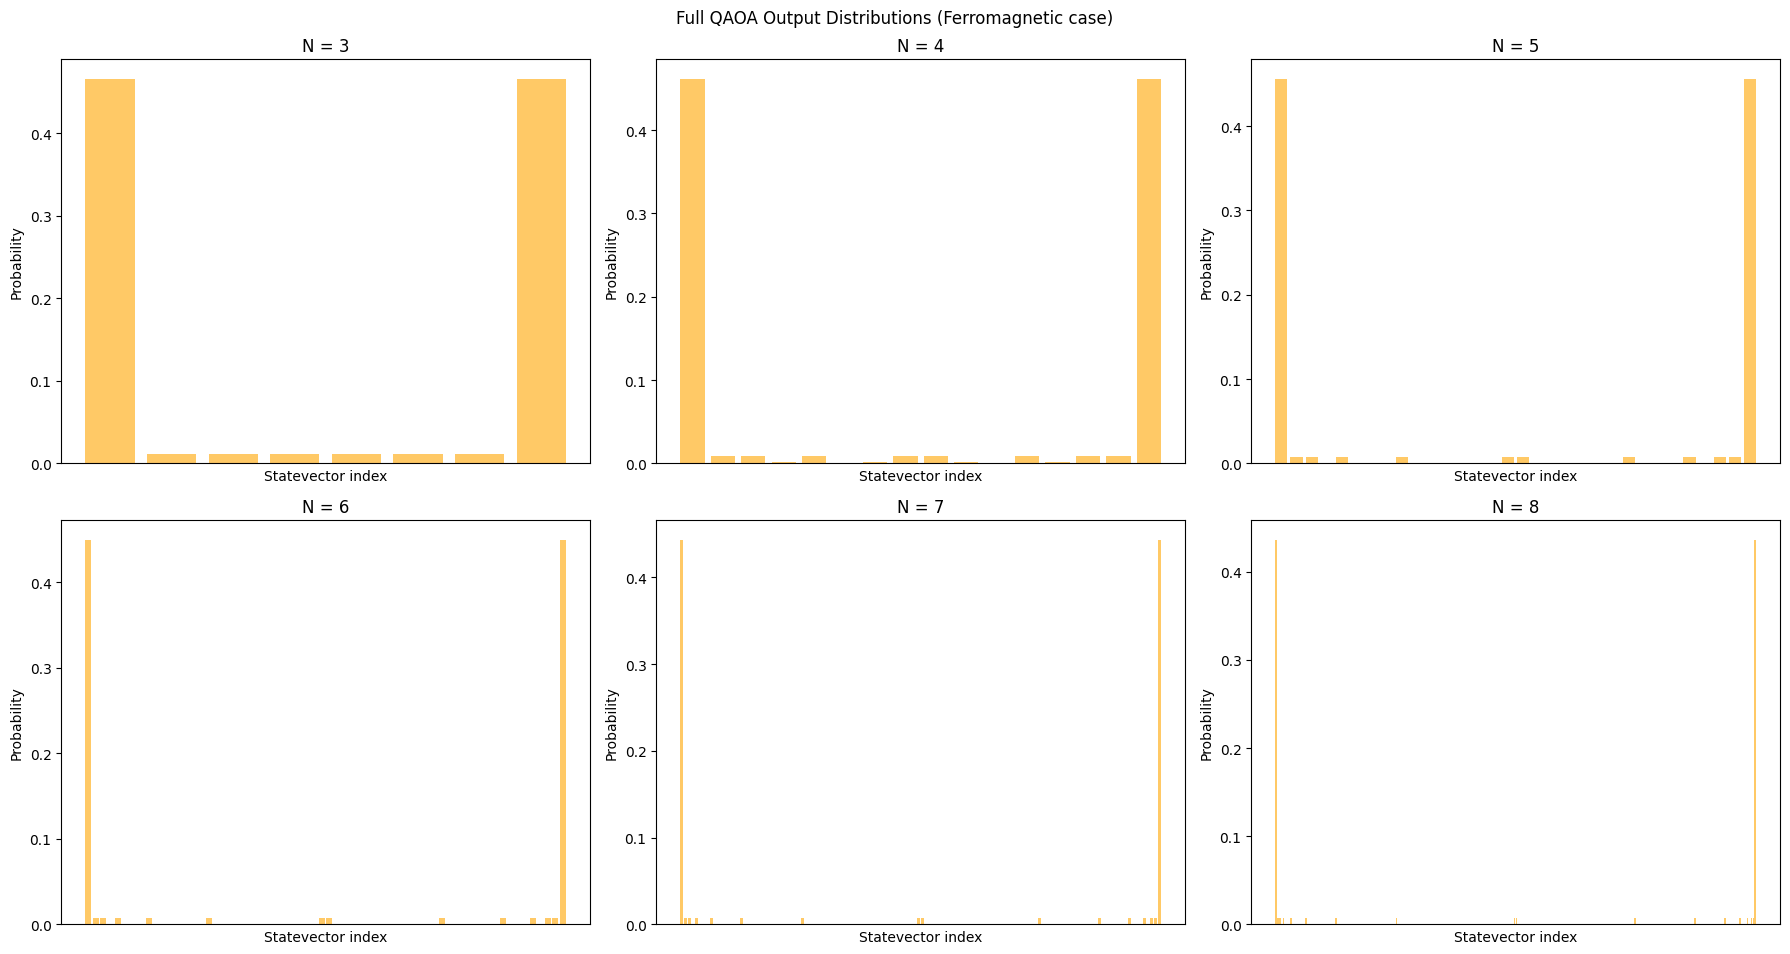

In [ ]:
N_range = range(3, 9)

n_qubits, J, h, p = 4, -1.0, -0.5, 15

all_probs = {}
gs_probs = {}
for N in N_range:
    qc, gamma, beta = create_qaoa_ising_ring(N, J, h, p)
    best_params, _ = optimize_qaoa(N, J, h, p)
    probs = get_ground_state_probs(best_params, qc, gamma, beta)
    all_probs[N] = probs

    sorted_states = sorted(probs.items(), key=lambda x: x[1], reverse=True)
    num_gs = 2 if N % 2 == 0 else 2 * N
    gs_probs[N] = dict(sorted_states[:num_gs])

fig1, axes1 = plt.subplots(2, 3, figsize=(18, 10))
for ax, N in zip(axes1.flatten(), N_range):
    probs = all_probs[N]
    indices = list(range(len(probs)))
    values = [probs[f"{i:0{N}b}"] for i in indices]
    ax.bar(indices, values, color='orange', alpha=0.6)
    ax.set_title(f"N = {N}")
    ax.set_xticks([])
    ax.set_xlabel("Statevector index")
    ax.set_ylabel("Probability")
fig1.suptitle("Full QAOA Output Distributions (Ferromagnetic case)")
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

We obtain a superposition of the fully polarized states. There is no need to check further since we know that fully aligned spins are the preferred configurations of ferromagnets.

It's an interesting exercise to try running our QAOA implementation on actual hardware. Let's implement the noise model we used earlier first:

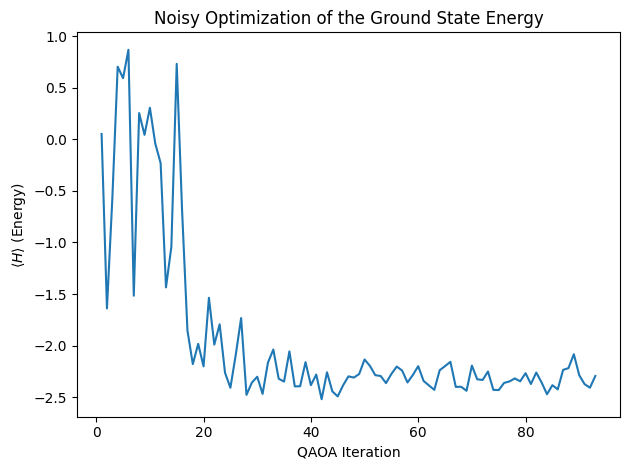

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import ParameterVector
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, coherent_unitary_error, amplitude_damping_error, ReadoutError
from qiskit_aer.primitives import SamplerV2 as Sampler
from scipy.optimize import minimize
from qiskit.circuit.library import RXGate

def create_qaoa_ising_ring(n, J, h, p):
    γ = ParameterVector('γ', p)
    β = ParameterVector('β', p)
    qc = QuantumCircuit(n)
    qc.h(range(n))
    for layer in range(p):
        for i in range(n):
            j = (i+1) % n
            qc.cx(i, j)
            qc.rz(2 * J * γ[layer], j)
            qc.cx(i, j)
        qc.rx(2 * h * β[layer], range(n))
        qc.barrier()
    return qc, γ, β

def build_noise_model(n_qubits):
    coh = coherent_unitary_error(RXGate(0.08).to_matrix())
    inc = amplitude_damping_error(0.04)
    ro  = ReadoutError([[0.90, 0.10], [0.08, 0.92]])
    noise = NoiseModel()
    for g in ['u1', 'u2', 'u3', 'x', 'h', 'sx', 's', 'sdg']:
        noise.add_all_qubit_quantum_error(inc, g)
    for q in range(n_qubits):
        noise.add_readout_error(ro, (q,))
    return noise

def h_energy_from_counts(counts, n, J, h, basis):
    total = 0
    shots = sum(counts.values())
    for bitstr, c in counts.items():
        bits = np.array([1 if b == '0' else -1 for b in bitstr[::-1]])
        if basis == 'Z':
            zz = np.sum(bits * np.roll(bits, -1))
            total += c * (J * zz)
        else:
            total += c * (h * np.sum(bits))
    return total / shots

def qaoa_expectation_noisy(params, qc, γ, β, n, J, h, sampler, shots):
    bind = {γ[i]: params[i] for i in range(len(γ))}
    bind.update({β[i]: params[len(γ) + i] for i in range(len(β))})
    bound = qc.assign_parameters(bind)

    qc_z = bound.copy()
    qc_z.measure_all()

    backend   = AerSimulator()
    qc_t      = transpile(qc_z, backend)
    noise     = build_noise_model(n)
    sampler   = Sampler(options={"backend_options": {"noise_model": noise}})
    result    = sampler.run([(qc_t, None, shots)]).result()
    counts_z    = result[0].data.meas.get_counts()

    energy_zz = 0.0
    energy_x = 0.0
    total_shots = sum(counts_z.values())

    for bitstr, count in counts_z.items():
        spins = [1 if bit == '0' else -1 for bit in bitstr[::-1]]

        for i in range(n):
            j = (i + 1) % n
            energy_zz += J * spins[i] * spins[j] * count

        for i in range(n):
            energy_x += h * (1 if spins[i] == 1 else -1) * count / n

    energy_zz /= total_shots
    energy_x /= total_shots

    return energy_zz + energy_x

def optimize_qaoa_with_noise(n, J, h, p, shots=500):
    qc, γ, β = create_qaoa_ising_ring(n, J, h, p)
    noise = build_noise_model(n)
    sampler = Sampler(options={"backend_options": {"noise_model": noise}})
    init = np.random.uniform(0, np.pi, size=2*p)

    res = minimize(lambda x: qaoa_expectation_noisy(
                       x, qc, γ, β, n, J, h, sampler, shots),
                   init, method='COBYLA')
    return res.x, res.fun

def optimize_qaoa_with_history_noisy(n, J, h, p, shots=2048, initial=None):
    qc, γ, β = create_qaoa_ising_ring(n, J, h, p)
    noise = build_noise_model(n)
    sampler = Sampler(options={"backend_options": {"noise_model": noise}})
    num_params = 2 * p
    init = initial if initial is not None else np.random.uniform(0, np.pi, size=num_params)

    energy_history = []

    def callback(xk):
        E = qaoa_expectation_noisy(xk, qc, γ, β, n, J, h, sampler, shots)
        energy_history.append(E)

    res = minimize(
        lambda x: qaoa_expectation_noisy(x, qc, γ, β, n, J, h, sampler, shots),
        init,
        method='COBYLA',
        callback=callback
    )
    return res, energy_history

n_qubits, J, h, p = 4, 1.0, -0.5, 5
result, hist_E = optimize_qaoa_with_history_noisy(n_qubits, J, h, p, shots=400)

plt.figure()
plt.plot(range(1, len(hist_E) + 1), hist_E)
plt.xlabel('QAOA Iteration')
plt.ylabel(r'$\langle H \rangle$ (Energy)')
plt.title('Noisy Optimization of the Ground State Energy')
plt.tight_layout()
plt.show()


The model has a lot more difficulties converging to the minimum value. It instead, oscillates between many of the near-minimum states. This is no problem, since even if the probabilities are not perfect, all we need is for the ground states to be the most probable states.

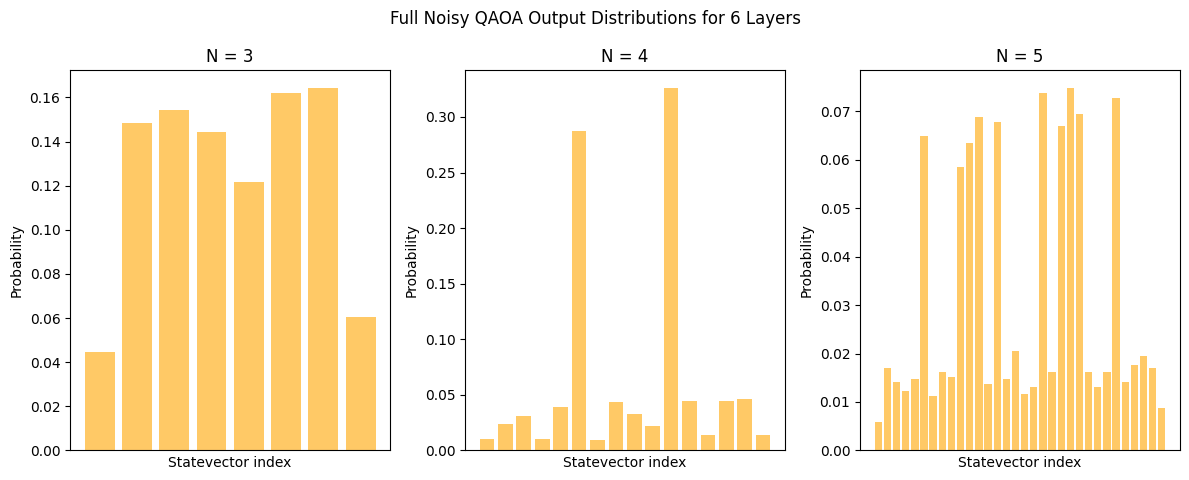

In [ ]:
def get_ground_state_probs_noisy(params, qc, gamma, beta, n_qubits, shots=2048):
    bind_map = {
        **{gamma[i]: params[i] for i in range(len(gamma))},
        **{beta[i]:  params[len(gamma)+i] for i in range(len(beta))}
    }
    qc_bound = qc.assign_parameters(bind_map).copy()
    qc_meas = qc_bound.copy()
    qc_meas.measure_all()

    backend   = AerSimulator()
    qc_t      = transpile(qc_meas, backend)
    noise     = build_noise_model(n_qubits)
    sampler   = Sampler(options={"backend_options": {"noise_model": noise}})
    result    = sampler.run([(qc_t, None, shots)]).result()
    counts    = result[0].data.meas.get_counts()
    total = sum(counts.values())
    probs = {s: c/total for s,c in counts.items()}
    return probs

N_range = range(3, 6)
J, h, p =  1.0, -0.5, 6

all_probs = {}
gs_probs = {}
for N in N_range:
    qc, gamma, beta = create_qaoa_ising_ring(N, J, h, p)
    best_params, _ =  optimize_qaoa_with_noise(n_qubits, J, h, p, shots=2048)
    probs = get_ground_state_probs_noisy(best_params, qc, gamma, beta, N)
    all_probs[N] = probs

    sorted_states = sorted(probs.items(), key=lambda x: x[1], reverse=True)
    num_gs = 2 if N % 2 == 0 else 2 * N
    gs_probs[N] = dict(sorted_states[:num_gs])

fig1, axes1 = plt.subplots(1, 3, figsize=(12, 5))
for ax, N in zip(axes1.flatten(), N_range):
    probs = all_probs[N]
    indices = list(range(len(probs)))
    values = [probs[f"{i:0{N}b}"] for i in indices]
    ax.bar(indices, values, color='orange', alpha=0.6)
    ax.set_title(f"N = {N}")
    ax.set_xticks([])
    ax.set_xlabel("Statevector index")
    ax.set_ylabel("Probability")
fig1.suptitle("Full Noisy QAOA Output Distributions for 6 Layers")
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

We can no longer mindlessly increase the number of layers as this increases more noise now. Still, amidst all this noise-layer counterplay, for low numbers of layers (and because our system is really simple) we can achieve good results most of the time. Increasing the number of shots also helps (but makes the code slower). For the record, the model engineered here is stronger than what is felt on actual hardware today.

Some notes on the code:

To compute the energy expected value in each iteration we first note that the ZZ terms in the Hamiltonian are diagonal in the computational basis so $\langle Z_i Z_j \rangle$ can be directly measured from the bitstring outcomes.

Then from the identity $X = HZH$ comes that the expectation value for X operators can be derived from the same measurements:
$$\langle X_i \rangle = \langle \psi | X_i | \psi \rangle = 2P(|0\rangle_i) - 1 = 1 - 2P(|1\rangle_i)$$

This is one way of handling it. Another way is to construct our hamiltonian using Sparce_Pauli Operators and let qiskit do the work by computing the expectation value of that observable directly (This is the best and fastest method). The next cell contains code using this approach for running on actual hardware.

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService, Session, EstimatorV2
from qiskit_ibm_runtime import SamplerV2 as Sampler
from scipy.optimize import minimize
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import time
from google.colab import userdata

TOKEN = userdata.get('TOKEN')
service = QiskitRuntimeService(channel="ibm_quantum", token=TOKEN)
backend = service.least_busy(operational=True, simulator=False)
print(f"Using backend: {backend.name}")

def create_qaoa_ising_ring(n, J, h, p):
    γ = ParameterVector('γ', p)
    β = ParameterVector('β', p)
    qc = QuantumCircuit(n)
    qc.h(range(n))
    for layer in range(p):
        for i in range(n):
            j = (i+1) % n
            qc.cx(i, j)
            qc.rz(2 * J * γ[layer], j)
            qc.cx(i, j)
        qc.rx(2 * h * β[layer], range(n))
        qc.barrier()
    return qc, γ, β

def build_hamiltonian(n, J, h):
    paulis = []
    coeffs = []
    for i in range(n):
        j = (i + 1) % n
        pauli_str = ['I'] * n
        pauli_str[i] = 'Z'
        pauli_str[j] = 'Z'
        paulis.append(''.join(pauli_str))
        coeffs.append(J)
    for i in range(n):
        pauli_str = ['I'] * n
        pauli_str[i] = 'X'
        paulis.append(''.join(pauli_str))
        coeffs.append(h)
    return SparsePauliOp(paulis, coeffs)

def optimize_qaoa_estimator(n, J, h, p, backend, shots=460):
    qc, γ, β = create_qaoa_ising_ring(n, J, h, p)
    hamiltonian = build_hamiltonian(n, J, h)

    target = backend.target
    pm     = generate_preset_pass_manager(target=target, optimization_level=3)
    qc_isa = pm.run(qc)
    h_isa  = hamiltonian.apply_layout(layout=qc_isa.layout)

    param_order = list(qc_isa.parameters)

    init_params = np.random.uniform(0, np.pi, size=2*p)

    def cost_function(x):

        vals = []
        gamma_list = list(γ)
        beta_list  = list(β)
        for param in param_order:
            if param in gamma_list:
                idx = gamma_list.index(param)
                vals.append(float(x[idx]))
            else:
                idx = beta_list.index(param)
                vals.append(float(x[len(gamma_list) + idx]))

        with Session(backend=backend) as session:
            estimator = EstimatorV2(mode=session)

            # Set number of shots
            estimator.options.default_shots = shots

            # Additional optimization:
            estimator.options.resilience_level = 2

            # TREX measurement error mitigation
            estimator.options.twirling.enable_measure = True
            estimator.options.twirling.num_randomizations = "auto"
            estimator.options.twirling.shots_per_randomization = "auto"

            # Gate twirling
            estimator.options.twirling.enable_gates = True

            # Zero-noise extrapolation (ZNE)
            estimator.options.resilience.zne_mitigation = True
            estimator.options.resilience.zne.noise_factors = [1, 3, 5]
            estimator.options.resilience.zne.extrapolator = ("exponential", "linear")

            # Dynamical decoupling
            estimator.options.dynamical_decoupling.enable = True
            estimator.options.dynamical_decoupling.sequence_type = "XX"

            # Create and submit estimator job
            pub = (qc_isa, [h_isa], [vals])
            job = estimator.run(pubs=[pub])
            result = job.result()
            # Extract the expectation value
            return result[0].data.evs[0]

    res = minimize(cost_function, init_params, method='COBYLA',options={'maxiter': 150, 'disp': True})
    return res.x, res.fun

# Parameters for N=4
N = 4
J, h, p = 1.0, -0.5, 2

print(f"Starting QAOA optimization for N={N} on {backend.name}")
start_time = time.time()
best_params, best_energy, qc, gamma, beta = optimize_qaoa_estimator(N, J, h, p, backend)
elapsed = time.time() - start_time
print(f"Optimization completed in {elapsed:.1f} seconds")
print(f"Final energy: {best_energy:.4f}")
print("Optimized parameters:", best_params)

In [ ]:
def get_state_probs(params, qc, gamma, beta, backend):
    bind_map = {
        **{gamma[i]: params[i] for i in range(len(gamma))},
        **{beta[i]: params[len(gamma)+i] for i in range(len(beta))}
    }
    qc_bound = qc.assign_parameters(bind_map).copy()

    pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
    qc_isa = pm.run(qc_bound)

    with Session(backend=backend) as session:
        sampler = Sampler(mode=session)
        sampler.options.default_shots = 1024
        job = sampler.run(qc_isa)
        result = job.result()
        counts = result.get_counts()

    total = sum(counts.values())
    return {state: count/total for state, count in counts.items()}

print("\nGetting state probabilities for optimized circuit")
probs = get_state_probs(best_params, qc, gamma, beta, backend)

# Print top states
sorted_states = sorted(probs.items(), key=lambda x: x[1], reverse=True)
print("\nTop states:")
for state, prob in sorted_states[:10]:
    print(f"{state}: {prob:.4f}")

# Plot results
plt.figure(figsize=(12, 6))
states = sorted(probs.keys(), key=lambda x: int(x, 2))
values = [probs[state] for state in states]

plt.bar(range(len(states)), values, color='skyblue', alpha=0.8)
plt.xticks(range(len(states)), states, rotation=90)
plt.title(f"N={N} QAOA Results on {backend.name}\nEnergy={best_energy:.4f}")
plt.xlabel("Basis State")
plt.ylabel("Probability")
plt.ylim(0, 1)
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# Plot parameters
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(best_params[:p], 'o-')
plt.title("γ parameters")
plt.xlabel("Layer")
plt.ylabel("Value")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(best_params[p:], 's-')
plt.title("β parameters")
plt.xlabel("Layer")
plt.grid(True)

plt.tight_layout()
plt.show()

This code also implements several error mitigation techniques: TREX measurement error mitigation leverages randomized calibration circuits to correct for misclassification in readout and automatically optimizes the number of randomizations and shots per randomization. Gate twirling suppresses coherent errors by symmetrizing noise through randomized Pauli insertions around each gate. Zero-noise extrapolation executes the same circuit under increased noise levels scaled by factors of 1, 3, and 5 and fits the resulting expectation values with both exponential and linear models to infer the zero-noise result. Dynamical decoupling interleaves tailored pulse sequences between computational layers to refocus qubit coherence and mitigate decoherence from environmental interactions.

Anybody interested in sending these jobs for actual devices should never incorporate all of these techniques at the same time due to constrained runtime. For context, an usual QAOA implementation takes around 150 steps to converge to the right parameters. Even if we reduce the number of shots in each iteration, running 150 circuits in a limited setting (for example the 10 minutes of QPU acess in the open plan) is a bit difficult. For example, one variational solver implementation made for 6 qubits used about 75 minutes of access.

In [ ]:
import qiskit
import qiskit_ibm_runtime
print(qiskit_ibm_runtime.version.get_version_info())
print(qiskit.__version__)

0.40.1
2.1.0
